In [2]:
"""
Notebook to produce figures for my master thesis at the University of Amsterdam.

Part of the data is not public yet. Feel free to email me at s.j.i.melfor@uva.nl if you
are interested in the data.

Author: Selah Melfor

This software is provided under license: Creative Commons Attribution 4.0
International (https://creativecommons.org/licenses/by/4.0/legalcode) and is provided as-is.

"""

# import packages
import os
import json
import pickle
import numpy as np
import bilby
import corner

import astropy.units as u
import astropy.constants as const
from scipy.stats import gaussian_kde
from scipy.spatial.distance import jensenshannon
from pesummary.io import read
from pesummary.utils.samples_dict import MultiAnalysisSamplesDict
from pesummary.utils.bounded_1d_kde import bounded_1d_kde

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec

# set style of plots
plt.style.use("science.mplstyle")

# set colors for plots
COLORS_DICT = {
    "teal"     : "#00707e",
    "darkred"  : "#8a0000",
    "gray"     : "#b0a8a8",
    "blue"     : "#00b9f2",
    "orange"   : "#f2a02a",
    "red"      : "#f94730",
    "green"    : "#c6de81",
    "pink"     : "#f8b7c9",
    "navy"     : "#1c4484",
    "black"    : "#0f0101",
}

# Figure widths in line with journal guidelines
FIG_SIZES = {
    "rectangle_plot"                 : (3.39 * 2 * 0.8, 2.64 * 1.5 * 0.8),
    "square_plot"                    : (2.64 * 1.5 * 0.8, 2.64 * 1.5 * 0.8),
    "rectangle_plot_spectogram"      : (3.39 * 4 * 0.8, 2.64 * 1.2 * 0.8),
    "rectangle_plot_two_a_side"      : (3.39 * 3.5 * 0.8, 2.64 * 1.2 * 0.8),
}

# Linewidths must be >0.5 to fit journal specs
LINEWIDTHS = {
    "interval" : 0.7,
    "curve"    : 0.9,
    "line"     : 0.6,
}

# Lower and upper limits in credible intervals 
CONFIDENCE_LIMITS = {
    "lower_bound" : 5,
    "median"      : 50,
    "upper_bound" : 95,
}

# Levels used for contours
CONTOUR_LEVELS = {
    "min" : 0.0,
    "mid" : 0.5,
    "max" : 0.9,
}

# Display plots
%matplotlib inline 

/home/smelfor/anaconda3/envs/plotting_env/lib/python3.10/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


In [3]:
data_dir = 'data/'
figures_dir = 'figures/'

# data path for the 
case_studies_dir        = data_dir + 'case_studies/'
population_studies_dir  = data_dir + 'population_studies/'
theory_data_dir         = data_dir + 'theoretical_background/'
methodology_data_dir    = data_dir + 'methodology/'
introduction_data_dir   = data_dir + 'introduction/'
discussion_data_dir     = data_dir + 'discussion/'

# save path for the figures
theory_dir                  = figures_dir + 'theoretical_background/'
methodology_dir             = figures_dir + 'methodology/'
results_case_studies_dir    = figures_dir + 'results/case_studies/'
results_population_dir      = figures_dir + 'results/population_studies/'
introduction_dir            = figures_dir + 'introduction/'
discussion_dir              = figures_dir + 'discussion/'

In [9]:
import pandas as pd
import h5py
from astropy.cosmology import Planck18

# path to data for plotting
results_gw230529 = introduction_data_dir + "posteriors/posterior_samples.h5"
results_gw170817 = introduction_data_dir + "posteriors/GW170817_GWTC-1.hdf5"
results_gw190425 = introduction_data_dir + "posteriors/GW190425.h5"
results_gw200105 = introduction_data_dir + "posteriors/IGWN-GWTC3p0-v1-GW200105_162426_PEDataRelease_mixed_cosmo.h5"
results_gw200115 = introduction_data_dir + "posteriors/IGWN-GWTC3p0-v1-GW200115_042309_PEDataRelease_mixed_cosmo.h5"

gw170817 = pd.DataFrame(h5py.File(results_gw170817)["IMRPhenomPv2NRT_highSpin_posterior"][:])
gw190425 = pd.DataFrame(h5py.File(results_gw190425)["C01:IMRPhenomPv2_NRTidal-HS"]["posterior_samples"][:]).sample(10000)
gw200105 = read(results_gw200105)
gw200115 = read(results_gw200115)
gw230529 = read(results_gw230529)

from bilby.gw.conversion import luminosity_distance_to_redshift as dL_to_z

# calculate redshift posterior with Planck15 cosmology
gw170817["redshift"] = dL_to_z(gw170817["luminosity_distance_Mpc"].values, cosmology=Planck18)

# calculate source frame masses of the binary
gw170817["mass_1_source"] = gw170817["m1_detector_frame_Msun"] / (1 + gw170817["redshift"])
gw170817["mass_2_source"] = gw170817["m2_detector_frame_Msun"] / (1 + gw170817["redshift"])

2024-08-08  13:49:37 PESummary WARNING : Could not find f_start in input file and one was not passed from the command line. Using 20.0Hz as default
2024-08-08  13:49:37 PESummary WARNING : Tidal deformability parameters found in the posterior table but they are all exactly 0. Assuming this is a BBH system.
2024-08-08  13:49:37 PESummary WARNING : Posterior samples for lambda_1 and lambda_2 found in the posterior table but lambda_1 is always exactly 0. Assuming this is an NSBH system.
2024-08-08  13:49:37 PESummary WARNING : Could not find f_start in input file and one was not passed from the command line. Using 20.0Hz as default
2024-08-08  13:49:37 PESummary WARNING : Tidal deformability parameters found in the posterior table but they are all exactly 0. Assuming this is a BBH system.
2024-08-08  13:49:37 PESummary WARNING : Posterior samples for lambda_1 and lambda_2 found in the posterior table but lambda_1 is always exactly 0. Assuming this is an NSBH system.
2024-08-08  13:49:37 P

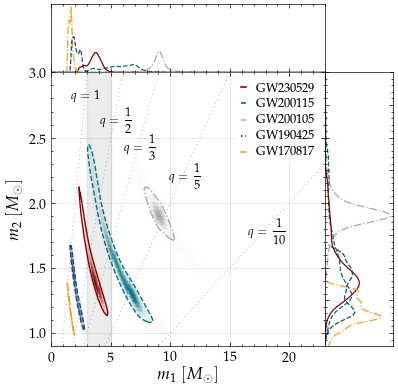

In [15]:
"""
Figure 1: Component Masses

The 1D and 2D posterior probability distributions for the component masses of the
source binary of GW230529 along with other NSBH and BNS events.

"""
# Load samples of NSBH candidates
samples = MultiAnalysisSamplesDict({
    "GW200105" : gw200105.samples_dict["C01:Mixed"],
    "GW200115" : gw200115.samples_dict["C01:Mixed"],
    "GW230529"        : gw230529.samples_dict["Combined_PHM_highSpin"],
})

# Load samples of BNS candidates
gw170817_samples_dict = {
    "mass_1_source" : gw170817["mass_1_source"].values,
    "mass_2_source" : gw170817["mass_2_source"].values,
}
gw190425_samples_dict = {
    "mass_1_source" : gw190425["mass_1_source"].values,
    "mass_2_source" : gw190425["mass_2_source"].values,
}
samples_bns = MultiAnalysisSamplesDict({
    "GW170817"        : gw170817_samples_dict,
    "GW190425"        : gw190425_samples_dict,
})

# Set color for each event
color_per_event = {
    "GW170817"        : COLORS_DICT["orange"],
    "GW190425"        : COLORS_DICT["navy"],
    "GW200105"        : COLORS_DICT["gray"],
    "GW200115"        : COLORS_DICT["teal"],
    "GW230529"        : COLORS_DICT["darkred"],
}

linestyle_per_event = {
    "GW170817"        : '-',
    "GW190425"        : ':',
    "GW200105"        : '-.',
    "GW200115"        : '--',
    "GW230529"        : '-',
}

linestyle_per_event_2 = {
    "GW170817"        : 'solid',
    "GW190425"        : 'dotted',
    "GW200105"        : 'dashdot',
    "GW200115"        : 'dashed',
    "GW230529"        : 'solid',
}

# Amount of smoothing applied to event contours
smoothing = {
    "GW170817"         : 0,
    "GW190425"         : 0,
    "GW190814"         : 0.5,
    "GW200105"          : 0.5,
    "GW200115" : 0.5,
    "GW230529"         : 0.5,
}

# Triangle plot for NSBH events and GW190814 using
# pesummary.utils.samples_dict.MultiAnalysisSamplesDict().plot
fig, ax1, ax3, ax4 = samples.plot(
    ["mass_1_source", "mass_2_source"],
    type             = "triangle",
    labels           = samples.labels,
    fontsize         = {"legend" : 9, "label": 12, "tick": 10},
    colors           = [color_per_event[label] for label in samples.labels],
    fig_kwargs       = {"figsize": (4.5, 4.5)},
    rangex           = (0, 27), 
    levels           = [CONTOUR_LEVELS["max"]],
    linewidths       = [LINEWIDTHS["curve"] for i in range(len(samples))],
    linestyles       = [linestyle_per_event[label] for label in samples.labels],
    plot_density     = True,
    fill             = False,
    smooth           = smoothing,
    npoints          = 500,
    bins             = 300,
)

# Triangle plot for BNS events using
# pesummary.utils.samples_dict.MultiAnalysisSamplesDict().plot
samples_bns.plot(
    ["mass_1_source", "mass_2_source"],
    type             = "triangle",
    labels           = samples_bns.labels,
    fontsize         = {"legend" : 9, "label": 12, "tick": 10},
    colors           = [color_per_event[label] for label in samples_bns.labels],
    fig_kwargs       = {"figsize": (4.5, 4.5)},
    rangex           = (0, 27), 
    levels           = [CONTOUR_LEVELS["max"]],
    linewidths       = [LINEWIDTHS["curve"] for i in range(len(samples_bns))],
    linestyles       = [linestyle_per_event[label] for label in samples.labels],
    plot_density     = True,
    fill             = False,
    smooth           = smoothing,
    npoints          = 500,
    bins             = 1000, # Increased bins used for BNS to produce sensible contours
    existing_figure  = (fig, ax1, ax3, ax4)
)

# # Add vertical lines for the 5th and 95th percentiles (for GW230529 only)
# line_max = 0.4
# m1 = gw230529.samples_dict["Combined_PHM_highSpin"]["mass_1_source"]
# m2 = gw230529.samples_dict["Combined_PHM_highSpin"]["mass_2_source"]
# # ax1.axvline(np.percentile(m1, CONFIDENCE_LIMITS["lower_bound"]), ymax=line_max, color=color_per_event["GW230529"], linewidth=LINEWIDTHS["interval"])
# # ax1.axvline(np.percentile(m1, CONFIDENCE_LIMITS["upper_bound"]), ymax=line_max, color=color_per_event["GW230529"], linewidth=LINEWIDTHS["interval"])
# # ax4.axhline(np.percentile(m2, CONFIDENCE_LIMITS["lower_bound"]), xmax=line_max, color=color_per_event["GW230529"], linewidth=LINEWIDTHS["interval"])
# # ax4.axhline(np.percentile(m2, CONFIDENCE_LIMITS["upper_bound"]), xmax=line_max, color=color_per_event["GW230529"], linewidth=LINEWIDTHS["interval"])

# # Adjust axes
xlow, xhigh = 0, 23
ylow, yhigh = 0.9, 3
ax1.set_xlim((xlow, xhigh))
ax1.set_ylim(0,)
ax3.set_xlim((xlow, xhigh))
ax3.set_ylim((ylow, yhigh))
ax4.set_xlim(0,)
ax4.set_ylim((ylow, yhigh))   

# Plot m2 = q * m1 lines
qs  = [1., 1./2, 1./3, 1./5, 1./10]
m1s = np.arange(xlow, xhigh, 0.01)
for i, q in enumerate(qs):
    ax3.plot(m1s, q * m1s, color="black", linestyle=(0, (1, 4)), alpha=0.4, zorder=0, linewidth=LINEWIDTHS["line"])

# Add mass ratio line annotations
ax3.text(2.90, 2.80, "$\\displaystyle q=1$",             color="k", ha="center", fontsize=9)
ax3.text(5.40, 2.61, "$\\displaystyle q=\\frac{1}{2}$",  color="k", ha="center", fontsize=9)
ax3.text(7.42, 2.40, "$\\displaystyle q=\\frac{1}{3}$",  color="k", ha="center", fontsize=9)
ax3.text(11.2, 2.18, "$\\displaystyle q=\\frac{1}{5}$",  color="k", ha="center", fontsize=9)
ax3.text(18.1, 1.75, "$\\displaystyle q=\\frac{1}{10}$", color="k", ha="center", fontsize=9)

# Disable height ticks of the 1D pdf
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax1.set_yticks([])
ax4.set_xticks([])

ax3.set_xticks([0, 5, 10, 15, 20])
ax3.set_yticks([1, 1.5, 2, 2.5, 3])

# # Add ticks to point in from top and right of 2D plot
# ax3.tick_params(which="major", direction="in", top=True)
# ax3.tick_params(which="minor", direction="in", top=True)
# ax3.tick_params(which="major", direction="in", right=True)
# ax3.tick_params(which="minor", direction="in", right=True)

# Set axes labels
ax3.set_xlabel("$m_1$ $[M_\odot]$", labelpad=-0.005)
ax3.set_ylabel("$m_2$ $[M_\odot]$")

# Add shaded region between 3 and 5 to represent nominal mass gap range
ax3.axvspan(3,5, color="k", alpha=0.075)
ax3.grid(True)

# Add legend
labels = samples_bns.labels + samples.labels # Events in chronological order
handles = np.array([Line2D([], [], color=color_per_event[label], linestyle=linestyle_per_event[label], label=label) for label in reversed(labels)])
leg = ax3.legend(handles=list(handles), loc="upper right", handlelength=1.0, borderpad=0.25, fontsize=9)
ax3.add_artist(leg)
for i in leg.legend_handles:
    i.set_linewidth(1.1)


fig.subplots_adjust(left=0.14, bottom=0.12)
fig.savefig(introduction_dir + "component_masses.png")
fig.savefig(introduction_dir + "component_masses.pdf")

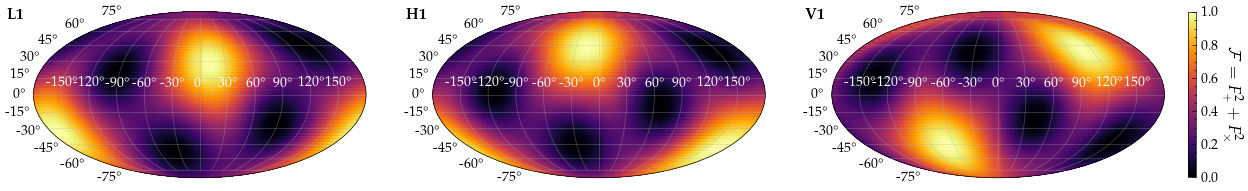

In [154]:
from bilby.gw.detector.networks import InterferometerList
# ifo = InterferometerList(['H1'])
# print(ifo[0].antenna_response(0, 0, 0, 0, mode='plus'))
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 19), subplot_kw={'projection': 'mollweide'})

ra_array = np.linspace(0, 2 * np.pi, 360)
dec_array = np.linspace(-np.pi / 2, -np.pi / 2, 180)

antenna_response = np.zeros(shape=(len(ra_array), len(dec_array)))

from pycbc.detector import Detector



norm = matplotlib.colors.Normalize(vmin=float(0), 
                                    vmax=float(1))
sm = plt.cm.ScalarMappable(cmap='inferno', norm=norm)
cmap = plt.cm.inferno

for i, detector in enumerate(["L1", "H1", "V1"]):
    d = Detector(detector)

    ra, dec = np.meshgrid(np.arange(0, np.pi*2.0, .05), 
                        np.arange(-np.pi / 2.0, np.pi / 2.0, .05))
    ra = ra.flatten()
    dec = dec.flatten()


    fp, fc = d.antenna_pattern(ra, dec, 0, 0)
    ra[ra>np.pi] -= np.pi * 2.0

    sc = axes[i].scatter(ra, dec, color=cmap(norm(fp**2 + fc**2)))
    axes[i].tick_params(axis='x', colors='white')

axes[0].annotate(r"\textbf{L1}",
        xy=(-0.08, 0.95), 
        xycoords='axes fraction',
        size=11,
        weight='black',
        bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

axes[1].annotate(r"\textbf{H1}",
        xy=(-0.08, 0.95), 
        xycoords='axes fraction',
        size=11,
        weight='black',
        bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

axes[2].annotate(r"\textbf{V1}",
        xy=(-0.08, 0.95), 
        xycoords='axes fraction',
        size=11,
        weight='black',
        bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

# sm.set_clim(0, 1)
# cb3 = fig.colorbar(sm3, cax=cax3, orientation="horizontal", ticks=[-1, 0, 1, 2])

colorbar = fig.colorbar(sm,  ax=[axes[i] for i in range(len(axes))], fraction=0.0071, pad=0.02, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
colorbar.set_label(r'$\mathcal{F} = F_{+}^2 + F_{\times}^2$', rotation=270, fontsize=12)
colorbar.ax.get_yaxis().labelpad = 18

fig.savefig(theory_dir + "antenna_pattern.png")
fig.savefig(theory_dir + "antenna_pattern.pdf")

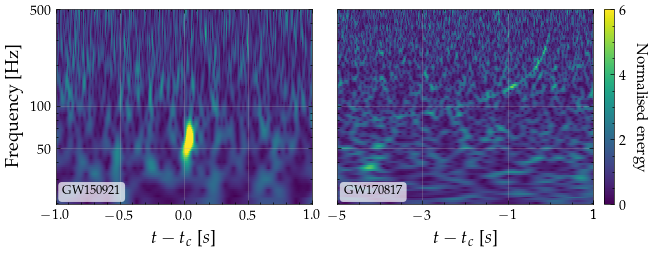

In [31]:
"""
Figure 5.3: Spectrogram of GW170817

The 1D and 2D posterior probability distributions for the component masses of the
source binary of GW230529 along with other NSBH and BNS events.

"""

from pycbc.catalog import Merger

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(3.39 * 4 * 0.8 * (2/3), 2.64 * 1.2 * 0.8), sharey=True)
plt.subplots_adjust(wspace=0.1)

# import data
times_gw170817           = json.load(open(introduction_data_dir + 'spectogram/times_gw170817.txt'))
frequencies_gw170817     = json.load(open(introduction_data_dir + 'spectogram/freqs_gw170817.txt'))
power_gw170817           = json.load(open(introduction_data_dir + 'spectogram/power_gw170817.txt'))

times_gw190521           = json.load(open(introduction_data_dir + 'spectogram/times_gw190521.txt'))
frequencies_gw190521     = json.load(open(introduction_data_dir + 'spectogram/freqs_gw190521.txt'))
power_gw190521           = json.load(open(introduction_data_dir + 'spectogram/power_gw190521.txt'))

merger_gw170817    = Merger("GW170817-v3", source='gwtc-1')
merger_gw190521    = Merger("GW190521")

axes[0].set_yscale("log")
axes[0].set_xlabel("$t - t_c$ [$s$]", fontsize=13)
color_mesh = axes[0].pcolormesh(np.array(times_gw190521['L1']) - merger_gw190521.time, 
                                frequencies_gw190521['L1'], np.array(power_gw190521['L1'])**0.5, vmin=0, vmax=6)
axes[0].set_yticks([50, 100, 500])
axes[0].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axes[0].set_xlim(-1, 1)
axes[0].set_ylim(top=500)

axes[1].set_yscale("log")
axes[1].set_xlabel("$t - t_c$ [$s$]", fontsize=13)
color_mesh = axes[1].pcolormesh(np.array(times_gw170817['H1']) - merger_gw170817.time, 
                                frequencies_gw170817['H1'], np.array(power_gw170817['H1'])**0.5, vmin=0, vmax=6)
axes[1].set_yticks([50, 100, 500])
axes[1].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axes[1].set_xlim(-5, 1)
axes[1].set_xticks([-5, -3, -1, 1, 1])
axes[1].set_ylim(top=500)


fig.supylabel(r"Frequency [Hz]", y=0.5, x=0.055, fontsize=13)

axes[0].annotate(r"GW150921",
            xy=(0.025, 0.05), 
            xycoords='axes fraction',
            size=9,
            bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

axes[1].annotate(r"GW170817",
            xy=(0.025, 0.05), 
            xycoords='axes fraction',
            size=9,
            bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))


colorbar = fig.colorbar(color_mesh,  ax=[axes[i] for i in range(len(axes))], fraction=0.021, pad=0.02, ticks=[0, 2, 4, 6])
colorbar.set_label(r'Normalised energy', rotation=270, fontsize=11)
colorbar.ax.get_yaxis().labelpad = 15


fig.savefig(introduction_dir + "spectrogram.pdf")
fig.savefig(introduction_dir + "spectrogram.png")

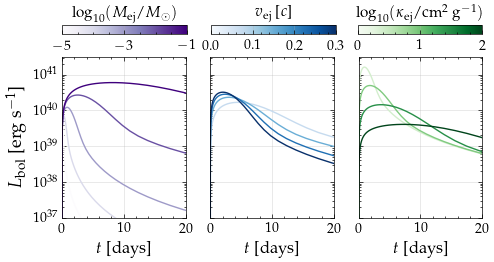

In [149]:
"""
Figure 5.2: Example Kilonova Light Curves

The 1D and 2D posterior probability distributions for the component masses of the
source binary of GW230529 along with other NSBH and BNS events.

"""

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=FIG_SIZES["rectangle_plot"], sharey=True)

# import data
luminosities_mass_ejectas        = json.load(open(theory_data_dir + 'light_curve/m_ejectas.txt'))
luminosities_velocity_ejectas    = json.load(open(theory_data_dir + 'light_curve/v_ejectas.txt'))
luminosities_kappa_ejectas       = json.load(open(theory_data_dir + 'light_curve/kappas.txt'))

times = np.logspace(-3, 2, 100)

cmap1 = plt.cm.Purples
norm1 = matplotlib.colors.Normalize(vmin=np.log10(float(list(luminosities_mass_ejectas.keys())[0])), 
                                    vmax=np.log10(float(list(luminosities_mass_ejectas.keys())[-1])))

for mass_ejecta in luminosities_mass_ejectas.keys():
    ax1.plot(times, luminosities_mass_ejectas[mass_ejecta], color=cmap1(norm1(np.log10(float(mass_ejecta)))))

cax = fig.add_axes([0.125, 0.82, 0.23, 0.03]) # Adjust the position as necessary

sm = plt.cm.ScalarMappable(cmap=cmap1, norm=norm1)
cb1 = fig.colorbar(sm, cax=cax, orientation="horizontal", ticks=[-5, -3, -1])
cb1.set_label(r"$\log_{10}(M_{\rm ej} / M_\odot)$", fontsize=11, loc='center', labelpad=-34)

ax1.set_yscale("log")
ax1.set_xlim(0, 20)
ax1.set_ylim(10**37., 10**41.5)

cmap2 = plt.cm.Blues
norm2 = matplotlib.colors.Normalize(vmin=float(list(luminosities_velocity_ejectas.keys())[0]), 
                                    vmax=float(list(luminosities_velocity_ejectas.keys())[-1]))

for v_ejecta in luminosities_velocity_ejectas.keys():
    ax2.plot(times, luminosities_velocity_ejectas[v_ejecta], color=cmap2(norm2(float(v_ejecta))))

cax2 = fig.add_axes([0.40, 0.82, 0.23, 0.03]) # Adjust the position as necessary

sm2 = plt.cm.ScalarMappable(cmap=cmap2, norm=norm2)
cb2 = fig.colorbar(sm2, cax=cax2, orientation="horizontal", ticks=[0.0, 0.1, 0.2, 0.3])
cb2.set_label(r"$v_{\rm ej}$ [$c$]", fontsize=11, loc='center', labelpad=-34)

ax2.set_yscale("log")
ax2.set_xlim(0, 20)

cmap3 = plt.cm.Greens

norm3 = matplotlib.colors.Normalize(vmin=np.log10(float(list(luminosities_kappa_ejectas.keys())[0])) - 0.5, 
                                    vmax=np.log10(float(list(luminosities_kappa_ejectas.keys())[-1])))

for kappa_ejecta in luminosities_kappa_ejectas.keys():
    ax3.plot(times, luminosities_kappa_ejectas[kappa_ejecta], color=cmap3(norm3(np.log10(float(kappa_ejecta)))))
    
cax3 = fig.add_axes([0.670, 0.82, 0.23, 0.03]) # Adjust the position as necessary

sm3 = plt.cm.ScalarMappable(cmap=cmap3, norm=norm3)
sm3.set_clim(0, 2)
cb3 = fig.colorbar(sm3, cax=cax3, orientation="horizontal", ticks=[-1, 0, 1, 2])
cb3.set_label(r"$\log_{10}(\kappa_{\rm ej}/\text{cm}^2 \text{ g}^{-1})$", fontsize=11, loc='center', labelpad=-35)

ax3.set_yscale("log")
ax3.set_xlim(0, 20)

fig.supylabel(r"$L_{\rm bol}$ [erg s$^{-1}$]", y=0.5, x=0.02, fontsize=13)

ax1.set_xlabel("$t$ [days]", fontsize=12, labelpad=3)
ax2.set_xlabel("$t$ [days]", fontsize=12, labelpad=3)
ax3.set_xlabel("$t$ [days]", fontsize=12, labelpad=3)

ax1.set_box_aspect(1.3)
ax2.set_box_aspect(1.3)
ax3.set_box_aspect(1.3)

fig.savefig(theory_dir + "kilonova_parameter_dependence.pdf")
fig.savefig(theory_dir + "kilonova_parameter_dependence.png")

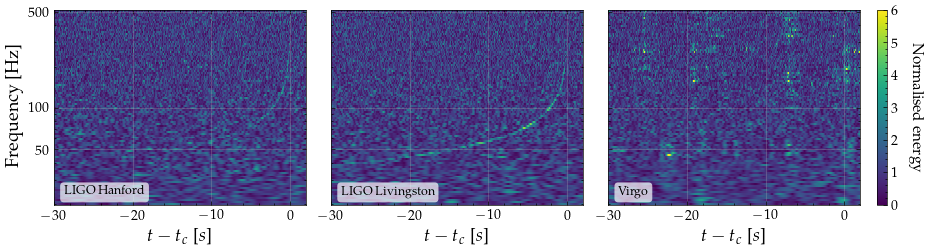

In [83]:
"""
Figure 5.3: Spectrogram of GW170817

The 1D and 2D posterior probability distributions for the component masses of the
source binary of GW230529 along with other NSBH and BNS events.

"""

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=FIG_SIZES["rectangle_plot_spectogram"], sharey=True)
plt.subplots_adjust(wspace=0.1)

# import data
times           = json.load(open(theory_data_dir + 'spectogram/times.txt'))
frequencies     = json.load(open(theory_data_dir + 'spectogram/freqs.txt'))
power           = json.load(open(theory_data_dir + 'spectogram/power.txt'))

merger    = pycbc.catalog.Merger("GW170817-v3", source='gwtc-1')
detectors = ["H1", "L1", "V1"]

for i, (detector, ax) in enumerate(zip(detectors, axes)):
    ax.set_yscale("log")
    ax.set_xlabel("$t - t_c$ [$s$]", fontsize=13)
    color_mesh = ax.pcolormesh(np.array(times[detector]) - merger.time, frequencies[detector], np.array(power[detector])**0.5, vmin=0, vmax=6)
    ax.set_yticks([50, 100, 500])
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())


fig.supylabel(r"Frequency [Hz]", y=0.5, x=0.08, fontsize=13)

axes[0].annotate(r"LIGO Hanford",
            xy=(0.04, 0.05), 
            xycoords='axes fraction',
            size=9,
            bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

axes[1].annotate(r"LIGO Livingston",
            xy=(0.04, 0.05), 
            xycoords='axes fraction',
            size=9,
            bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

axes[2].annotate(r"Virgo",
            xy=(0.04, 0.05), 
            xycoords='axes fraction',
            size=9,
            bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

colorbar = fig.colorbar(color_mesh,  ax=[axes[i] for i in range(len(axes))], fraction=0.021, pad=0.02, ticks=[0, 2, 4, 6])
colorbar.set_label(r'Normalised energy', rotation=270, fontsize=11)
colorbar.ax.get_yaxis().labelpad = 18

fig.savefig(theory_dir + "spectrogram_gw170817.pdf")
fig.savefig(theory_dir + "spectrogram_gw170817.png")

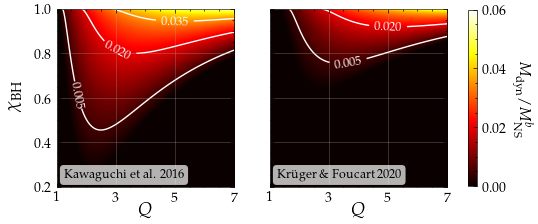

In [157]:
"""
Figure 6.1: Dynamical Ejecta Mass

The 1D and 2D posterior probability distributions for the component masses of the
source binary of GW230529 along with other NSBH and BNS events.

"""

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=FIG_SIZES["rectangle_plot"], sharey=True)

def calculate_r_isco(chi_bh):
    Z1 = 1.0 + (1.0 - chi_bh**2)**(1.0 / 3.0) * (
            (1.0 + chi_bh) ** (1.0 / 3.0) + (1.0 - chi_bh) ** (1.0 / 3.0)
        )
    Z2 = np.sqrt(3.0 * chi_bh**2.0 + Z1**2.0)
    return 3.0 + Z2 - np.sign(chi_bh) * np.sqrt((3.0 - Z1) * (3.0 + Z1 + 2.0 * Z2))

calculate_baryonic_mass = lambda mass, compactness: mass + mass * (0.6 * compactness / (1.0 - 0.5 * compactness))
calculate_compactness = lambda mass, radius: (const.G * (mass * u.Msun).to(u.kg) / ((radius * u.km).to(u.m) * const.c**2))
calculate_symmetric_mass_ratio = lambda mass_1, mass_2: mass_1 * mass_2 / (mass_1 + mass_2)**2

def calculate_kawaguchi_dynamical_mass(inverse_mass_ratio, mass_2, compactness, r_isco, baryonic_mass):
    a1, a2, a3, a4, n1, n2 = 0.04464, 0.002269, 2.431, -0.4159, 0.2497, 1.352

    dynamical_mass = a1 * inverse_mass_ratio**n1 * (1.0 - 2 * compactness) / compactness - \
        a2 * inverse_mass_ratio**n2 * r_isco  + a3 * (1.0 - mass_2 / baryonic_mass) + a4
    return np.clip(dynamical_mass, a_min=0.0, a_max=None)

def calculate_kruger_dynamical_mass(inverse_mass_ratio, compactness, r_isco, baryonic_mass):
    a1, a2, a4, n1, n2 = 7.11595154e-03, 1.43636803e-03, -2.76202990e-02, 8.63604211e-01, 1.68399507e00

    dynamical_mass = a1 * inverse_mass_ratio**n1 * ((1.0 - 2 * compactness) / compactness) - \
        a2 * inverse_mass_ratio**n2 * r_isco + a4
    return np.clip(dynamical_mass, a_min=0.0, a_max=None)

# neutron star characteristics
mass_2 = 1.4
radius_2 = 11

mass_1 = np.arange(mass_2 * 1, mass_2 * 7, 0.01)
spin_1 = np.arange(0.2, 1, 0.001)

compactness = calculate_compactness(mass_2, radius_2)
baryonic_mass = calculate_baryonic_mass(mass_2, compactness)
r_isco = calculate_r_isco(spin_1)

kawaguchi_dynamical_mass = np.zeros(shape=(len(spin_1), len(mass_1)))
kruger_dynamical_mass = np.zeros(shape=(len(spin_1), len(mass_1)))

for i, mass_bh in enumerate(mass_1):
    inverse_mass_ratio = mass_bh / mass_2

    kawaguchi_dynamical_mass[:, i] = calculate_kawaguchi_dynamical_mass(inverse_mass_ratio, mass_2, compactness, r_isco, baryonic_mass)
    kruger_dynamical_mass[:, i] = calculate_kruger_dynamical_mass(inverse_mass_ratio, compactness, r_isco, baryonic_mass)

# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [COLORS_DICT['black'], COLORS_DICT['gray'], COLORS_DICT['darkred']])

norm = matplotlib.colors.Normalize(vmin=float(0), 
                                    vmax=float(0.06))
sm = plt.cm.ScalarMappable(cmap='hot', norm=norm)
sm.set_clim(0, 0.06)

im1 = ax1.imshow(kawaguchi_dynamical_mass, cmap='hot', interpolation='nearest', extent=[1, 7, 1, 0.2], aspect='auto', norm=norm)
ax1.set_yticks([0.2, 0.4, 0.6, 0.8, 1])
ax1.set_xticks([1, 3, 5, 7])

im2 = ax2.imshow(kruger_dynamical_mass, cmap='hot', interpolation='nearest', extent=[1, 7, 1, 0.2], aspect='auto', norm=norm)
ax2.set_xticks([1, 3, 5, 7])
# # cb3 = fig.colorbar(sm3, cax=cax3, orientation="horizontal", ticks=[-1, 0, 1, 2])

colorbar = fig.colorbar(sm,  ax=[ax1, ax2], fraction=0.021, ticks=[0, 0.02, 0.04, 0.06])
colorbar.set_label(r'$M_{\rm dyn}/M_{\rm NS}^b$', rotation=270, fontsize=11)
colorbar.ax.get_yaxis().labelpad = 20

ax1.set_yticks([0.2, 0.4, 0.6, 0.8, 1])
ax1.set_xticks([1, 3, 5, 7])
fig.axes[0].invert_yaxis()

fig.supylabel(r"$\chi_{\rm BH}$", y=0.5, x=0.03, fontsize=13)

ax1.set_box_aspect(1)
ax2.set_box_aspect(1)

ax1.set_xlabel("$Q$", fontsize=13, labelpad=-3)
ax2.set_xlabel("$Q$", fontsize=13, labelpad=-3)

ax1.annotate("Kawaguchi et al. 2016",
            xy=(0.04,0.05), 
            xycoords='axes fraction',
            size=9,
            bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

ax2.annotate(r"Krüger \& Foucart 2020",
            xy=(0.04,0.05), 
            xycoords='axes fraction',
            size=9,
            bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

# CHANGE HERE
levels = [0.005, 0.020, 0.035]
contour1 = ax1.contour(kawaguchi_dynamical_mass, levels=[0.005, 0.020, 0.035], colors='white', extent=[1, 7, 0.2, 1])
ax1.clabel(contour1, inline=True, fontsize=9, manual=[(1, 0.6), (3, 0.8), (5, 0.95)])

levels = [0.005, 0.020]
contour2 = ax2.contour(kruger_dynamical_mass, levels=[0.005, 0.020], colors='white', extent=[1, 7, 0.2, 1])
ax2.clabel(contour2, inline=True, fontsize=9, manual=[(4, 0.6), (5, 0.9)])

fig.savefig(methodology_dir + "dynamical_mass.pdf")
fig.savefig(methodology_dir + "dynamical_mass.png")

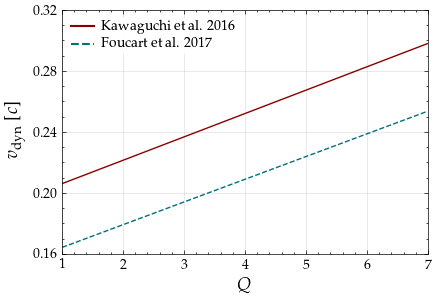

In [3]:
"""
Figure 6.2: Dynamical Ejecta Velocity

The 1D and 2D posterior probability distributions for the component masses of the
source binary of GW230529 along with other NSBH and BNS events.

"""

fig, ax = plt.subplots(figsize=FIG_SIZES["rectangle_plot"])

# define the semi-analytical formulae and the inverse mass ratio range
Q_array = np.arange(1, 8, 0.01)

kawaguchi_vdyn = lambda Q: 0.01533 * Q + 0.1907
foucart_vdyn = lambda Q: 0.0149 * Q + 0.1493

# plot the dynamical velocities
plt.plot(Q_array, kawaguchi_vdyn(Q_array),  color=COLORS_DICT["darkred"], linestyle='-', label='Kawaguchi et al. 2016')
plt.plot(Q_array, foucart_vdyn(Q_array),    color=COLORS_DICT["teal"], linestyle='--', label='Foucart et al. 2017')

# add the legend to the plot
handles = [Line2D([], [], color=COLORS_DICT["darkred"], ls="-"), Line2D([], [], color=COLORS_DICT["teal"], ls="--"),]
labels = ["Kawaguchi et al. 2016", "Foucart et al. 2017"]
legend = plt.legend(handles, labels, loc=(0.02, 0.82))
for i in legend.legend_handles:
    i.set_linewidth(1.5)

ax.add_artist(legend)

# set axis limits and labels
ax.set_xlim(1, 7)
ax.set_ylim(0.16, 0.32)

ax.set_yticks([0.16, 0.20, 0.24, 0.28, 0.32])
fig.supxlabel(r"$Q$", x=0.51, y=-0.02, fontsize=13)
fig.supylabel(r"$v_{\rm dyn}$ [$c$]", y=0.5, x=0.07, fontsize=13)

ax.set_box_aspect(1/1.5)

fig.savefig(methodology_dir + "dynamical_velocity.pdf")
fig.savefig(methodology_dir + "dynamical_velocity.png")

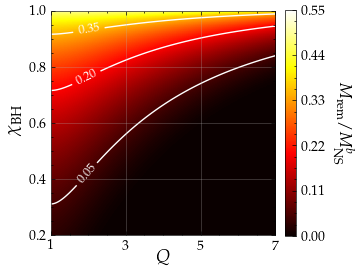

In [158]:
"""
Figure 6.3: Remnant Mass Outside the Black Hole

The 1D and 2D posterior probability distributions for the component masses of the
source binary of GW230529 along with other NSBH and BNS events.

"""

fig, ax = plt.subplots(figsize=FIG_SIZES["square_plot"])

def foucart_remnant_mass(symmetric_mass_ratio, compactness, r_isco, baryonic_mass):
    alpha, beta, gamma, delta = 0.406, 0.139, 0.255, 1.761

    remnant_mass = alpha * (1.0 - 2.0 * compactness) / symmetric_mass_ratio**(1.0 / 3.0) - \
                    beta * r_isco * compactness / symmetric_mass_ratio + gamma
    return np.clip(remnant_mass, a_min=0, a_max=None)**delta * baryonic_mass

# neutron star characteristics
mass_2 = 1.4
radius_2 = 11

mass_1 = np.arange(mass_2 * 1, mass_2 * 7, 0.01)
spin_1 = np.arange(0.2, 1, 0.001)

compactness = calculate_compactness(mass_2, radius_2)
baryonic_mass = calculate_baryonic_mass(mass_2, compactness)

remnant_mass = np.zeros(shape=(len(spin_1), len(mass_1)))

for i, mass_bh in enumerate(mass_1):
    symmetric_mass_ratio = calculate_symmetric_mass_ratio(mass_bh, mass_2)
    r_isco = calculate_r_isco(spin_1)

    remnant_mass[:, i] = foucart_remnant_mass(symmetric_mass_ratio, compactness, r_isco, baryonic_mass)

norm = matplotlib.colors.Normalize(vmin=float(0), 
                                    vmax=float(0.55))
sm = plt.cm.ScalarMappable(cmap='hot', norm=norm)
sm.set_clim(0, 0.55)

im = ax.imshow(remnant_mass, cmap='hot', interpolation='nearest', extent=[1, 7, 1, 0.2], aspect='auto', norm=norm)

colorbar = ax.figure.colorbar(im, fraction=0.046, pad=0.04, ticks=[0, 0.11, 0.22, 0.33, 0.44, 0.55])
colorbar.set_label(r'$M_{\rm rem}/M_{\rm NS}^b$', rotation=270, fontsize=12)
colorbar.ax.get_yaxis().labelpad = 20

levels = [0.005, 0.020, 0.035]
contour = ax.contour(remnant_mass, levels=[0.05, 0.2, 0.35], colors='white', extent=[1, 7, 0.2, 1])
cl = ax1.clabel(contour,  fontsize=9, use_clabeltext=True) #manual=[(1, 0.6), (3, 0.8), (5, 0.95)])

# for label in cl:
#     label.set_rotation(0)

ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1])
ax.set_xticks([1, 3, 5, 7])
fig.axes[0].invert_yaxis()

fig.supxlabel(r"$Q$", x=0.48, y=0.04, fontsize=13)
fig.supylabel(r"$\chi_{\rm BH}$", y=0.5, x=-0.02, fontsize=13)

ax.set_box_aspect(1)

fig.savefig(methodology_dir + "remnant_mass.pdf")
fig.savefig(methodology_dir + "remnant_mass.png")

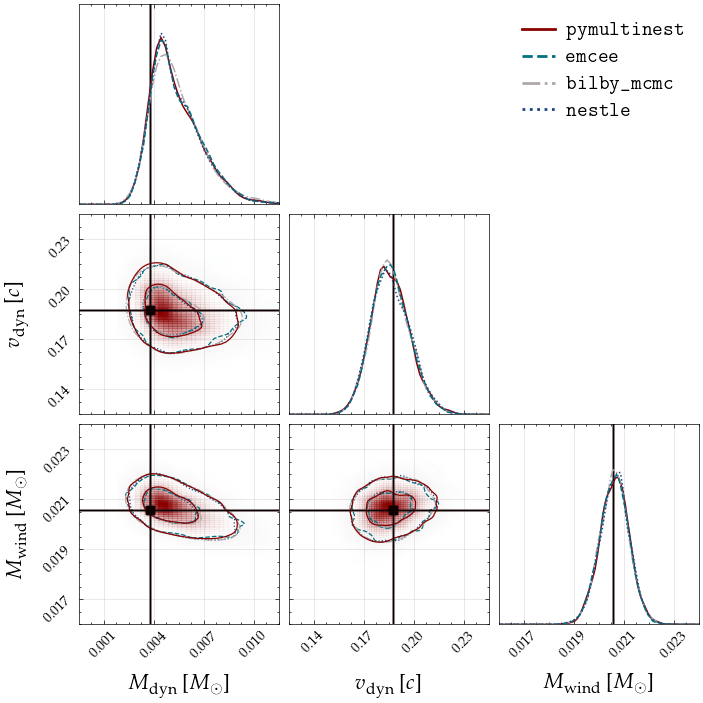

In [4]:
"""
Figure 6.6: Comparison between the different samplers.


The 1D and 2D posterior probability distributions for the component masses of the
source binary of GW230529 along with other NSBH and BNS events.

"""

# load data
samplers_key = ['pymultinest', 'bilby_mcmc', 'emcee', 'nestle']
results_list = [bilby.result.read_in_result(outdir=f'data/methodology/comparison_samplers/{sampler}', label=f'{sampler}') for sampler in samplers_key]
COLORS_SAMPLERS = {'pymultinest': COLORS_DICT['darkred'],
                   'emcee'      : COLORS_DICT['teal'],
                   'bilby_mcmc' : COLORS_DICT['gray'],
                   'nestle'    : COLORS_DICT['navy']}

LINESTYLE_RUNS = {'pymultinest'      : '-',
                  'emcee'     : '--',
                  'bilby_mcmc'     : '-.',
                  'nestle'     : ':'}

direction  = "in"
smoothing  = 1.8
nbins      = 60

posteriors = ['m_ejecta_dyn', 'v_ejecta_dyn', 'm_ejecta_wind']
param_labels = [r'$M_{\rm dyn}$ [$M_\odot$]', r'$v_{\rm dyn}$ [$c$]', r'$M_{\rm wind}$ [$M_\odot$]']
truth_values = [0.003761830857588508, 0.18750512820512819, 0.020580450191741966]

for i, sampler in enumerate(reversed(samplers_key)):
    if i == 0:
        fig = corner.corner(
            np.array([results_list[i].posterior[key] for key in posteriors]).T,
            bins            = nbins,
            labels          = param_labels,
            fill_contours   = False,
            plot_datapoints = False,
            color           = COLORS_SAMPLERS[sampler],
            smooth          = smoothing,
            levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
            plot_kwargs     = dict(linestyle = "-"),
            hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
            contour_kwargs  = dict(linestyles=LINESTYLE_RUNS[sampler], linewidths=[LINEWIDTHS["curve"]]),
            plot_density    = True,
        )

    else:
        corner.corner(
            np.array([results_list[i].posterior[key] for key in posteriors]).T,
            fig             = fig,
            bins            = nbins,
            labels          = param_labels,
            fill_contours   = False,
            plot_datapoints = False,
            color           = COLORS_SAMPLERS[sampler],
            smooth          = smoothing,
            truths          = truth_values,
            truth_color     = COLORS_DICT["black"],
            levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
            plot_kwargs     = dict(linestyle = "-"),
            hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
            contour_kwargs  = dict(linestyles=LINESTYLE_RUNS[sampler], linewidths=[LINEWIDTHS["curve"]]),
            plot_density    = True,
            labelpad        = -0.05,
        )

# Evaluate KDE
kde_mdyn = [gaussian_kde(results_list[i].posterior["m_ejecta_dyn"].to_numpy()) for i in range(len(results_list))]
kde_vdyn = [gaussian_kde(results_list[i].posterior["v_ejecta_dyn"].to_numpy()) for i in range(len(results_list))]
kde_mwind = [gaussian_kde(results_list[i].posterior["m_ejecta_wind"].to_numpy()) for i in range(len(results_list))]

kdes = [kde_mdyn, kde_vdyn, kde_mwind]
kdes_ranges = [np.linspace(-0.010, 0.016, 100), np.linspace(0.125, 0.32, 100), np.linspace(0.014, 0.0240, 100)]

mdyn_ticks = [0.001, 0.004, 0.007, 0.010]
vdyn_ticks = [0.14, 0.17, 0.20, 0.23]
mwind_ticks = [0.0170, 0.019, 0.021, 0.023]

xticks = [mdyn_ticks, vdyn_ticks, mwind_ticks]

for j, axes in enumerate([0, 4, 8]):
    for i, sampler in enumerate(samplers_key):
        fig.get_axes()[axes].plot(kdes_ranges[j], kdes[j][i](kdes_ranges[j]), color=COLORS_SAMPLERS[sampler], linestyle=LINESTYLE_RUNS[sampler], linewidth=1.1)

# mdyn 1D-distribution
fig.get_axes()[0].set_xticks(mdyn_ticks)

# mdyn-vdyn 2D distribution
fig.get_axes()[3].set_xticks(mdyn_ticks)
fig.get_axes()[3].set_yticks(vdyn_ticks)

# vdyn 1D distribution
fig.get_axes()[4].set_xticks(vdyn_ticks)

# mdyn-mwind 2D distribution
fig.get_axes()[6].set_xticks(mdyn_ticks)
fig.get_axes()[6].set_yticks(mwind_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[7].set_xticks(vdyn_ticks)
fig.get_axes()[7].set_yticks(mwind_ticks)

# mwind 1D distribution
fig.get_axes()[8].set_xticks(mwind_ticks)

# Tune x and y limits
mdyn_min, mdyn_max          =  -0.0005, 0.0115
vdyn_min, vdyn_max          =  0.125, 0.245
mwind_min, mwind_max        =  0.016, 0.024

fig.get_axes()[0].set_xlim((mdyn_min, mdyn_max))

fig.get_axes()[3].set_xlim((mdyn_min, mdyn_max))
fig.get_axes()[3].set_ylim((vdyn_min, vdyn_max))

fig.get_axes()[4].set_xlim((vdyn_min, vdyn_max))

fig.get_axes()[6].set_xlim((mdyn_min, mdyn_max))
fig.get_axes()[6].set_ylim((mwind_min, mwind_max))

fig.get_axes()[7].set_xlim((vdyn_min, vdyn_max))
fig.get_axes()[7].set_ylim((mwind_min, mwind_max))

fig.get_axes()[8].set_xlim((mwind_min, mwind_max))

# add the legend to the plot
handles = [Line2D([], [], color=COLORS_DICT["darkred"], ls=LINESTYLE_RUNS['pymultinest']), 
           Line2D([], [], color=COLORS_DICT["teal"], ls=LINESTYLE_RUNS['emcee']),
           Line2D([], [], color=COLORS_DICT["gray"], ls=LINESTYLE_RUNS['bilby_mcmc']),
           Line2D([], [], color=COLORS_DICT["navy"], ls=LINESTYLE_RUNS['nestle'])]
labels = [r'\texttt{pymultinest}', r'\texttt{emcee}', r'\texttt{bilby_mcmc}', r'\texttt{nestle}']
legend = plt.legend(handles, labels, loc=(0.1, 2.5), fontsize=15)
for i in legend.legend_handles:
    i.set_linewidth(2)

fig.savefig(methodology_dir + 'compare_samplers.png')
fig.savefig(methodology_dir + 'compare_samplers.pdf')


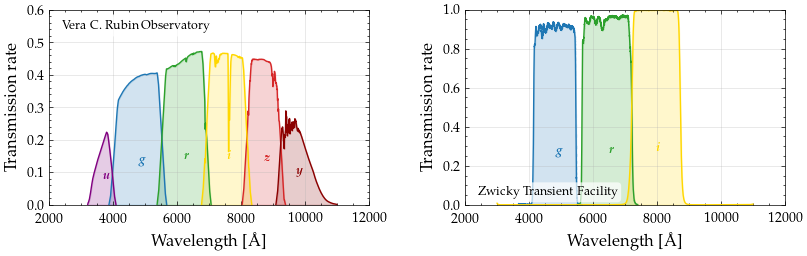

In [89]:
"""
Figure 6.7: Transmission rate of the Zwicky Transient Facility and the Vera C.
Rubin Obervatory.

The 1D and 2D posterior probability distributions for the component masses of the
source binary of GW230529 along with other NSBH and BNS events.

"""

COLORS_FILTERS_DICT = {'u': 'purple',
                       'g': 'tab:blue',
                       'r': 'tab:green',
                       'z': 'tab:red',
                       'i': 'gold',
                       'y': 'darkred'
                       }

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=FIG_SIZES["rectangle_plot_two_a_side"])
plt.subplots_adjust(wspace=0.3)

def plot_filters(telescope, filters, ax):
    file_name = methodology_data_dir + f'filters/{telescope}'

    for filter in filters:
        wavelength, transmission_rate = np.loadtxt(fname=file_name + f'_{filter}.dat').T

        ax.plot(wavelength, transmission_rate, color=COLORS_FILTERS_DICT[filter])
        text_x = np.median(wavelength[np.where(transmission_rate > 0.1)])
        text_y = (np.min(transmission_rate[transmission_rate > 0.1]) + np.max(transmission_rate[transmission_rate > 0.1])) / 2

        ax.annotate(f"$\\boldsymbol{{{filter}}}$",
            xy=(text_x, text_y / 2), 
            xycoords='data',
            size=9,
            weight='bold',
            color=COLORS_FILTERS_DICT[filter])
        #
        ax.fill_between(wavelength, transmission_rate, color=COLORS_FILTERS_DICT[filter], alpha=0.2)
    
    ax.set_xlim(2000, 12000)
    ax.set_xlabel("Wavelength [Å]", fontsize=12, labelpad=4)
    ax.set_ylabel("Transmission rate", fontsize=12, labelpad=4)
    ax.tick_params(axis='x', which='major', pad=6)

plot_filters('LSST', ['g', 'r', 'z', 'i', 'u', 'y'], ax=axes[0])
plot_filters('ZTF', ['g', 'r', 'i'], ax=axes[1])

axes[0].set_ylim(0, 0.6)
axes[0].annotate(r"Vera C. Rubin Observatory",
            xy=(0.04, 0.9), 
            xycoords='axes fraction',
            size=9,
            bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

axes[1].set_ylim(0, 1)
axes[1].annotate(r"Zwicky Transient Facility",
            xy=(0.04, 0.05), 
            xycoords='axes fraction',
            size=9,
            bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

fig.savefig(methodology_dir + "transmission_rate.pdf")
fig.savefig(methodology_dir + "transmission_rate.png")

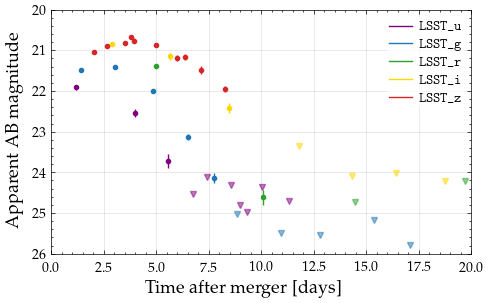

In [54]:
"""
Figure 6.8: 

The 1D and 2D posterior probability distributions for the component masses of the
source binary of GW230529 along with other NSBH and BNS events.

"""

fig, ax = plt.subplots(figsize=FIG_SIZES["rectangle_plot"])

COLORS_FILTERS_DICT = {'u': 'purple',
                       'g': 'tab:blue',
                       'r': 'tab:green',
                       'z': 'tab:red',
                       'i': 'gold',
                       'y': 'darkred'
                       }

times_observed, observations_observed, errors_observed             = pickle.load(open(methodology_data_dir + 'too_simulations/too_observations_observed.pkl', "rb"))
times_not_observed, observations_not_observed, limiting_magnitudes = pickle.load(open(methodology_data_dir + 'too_simulations/too_observations_not_observed.pkl', "rb"))

for band in times_observed.keys():
    ax.plot(times_observed[band], observations_observed[band], 'o', label=f'$\\texttt{{{band}}}$', color=f'{COLORS_FILTERS_DICT[band[-1]]}', markersize=3)
    ax.plot(times_not_observed[band], observations_not_observed[band], 'v', color=f'{COLORS_FILTERS_DICT[band[-1]]}', alpha=0.5, markersize=5)
    ax.errorbar(times_observed[band], observations_observed[band], yerr=errors_observed[band], fmt='none', color=f'{COLORS_FILTERS_DICT[band[-1]]}')

ax.set_ylim(20, 26)
ax.set_xlim(0, 20)
ax.tick_params(axis='x', which='major', pad=6)

# add the legend to the plot
handles = [Line2D([], [], color=COLORS_FILTERS_DICT["u"], ls="-"), 
           Line2D([], [], color=COLORS_FILTERS_DICT["g"], ls="-"),
           Line2D([], [], color=COLORS_FILTERS_DICT["r"], ls="-"),
           Line2D([], [], color=COLORS_FILTERS_DICT["i"], ls="-"),
           Line2D([], [], color=COLORS_FILTERS_DICT["z"], ls="-")]

labels = [r"$\texttt{LSST_u}$", r"$\texttt{LSST_g}$", r"$\texttt{LSST_r}$", r"$\texttt{LSST_i}$", r"$\texttt{LSST_z}$"]
legend = plt.legend(handles, labels, loc=(0.8, 0.60))
for i in legend.legend_handles:
    i.set_linewidth(1)

fig.supxlabel("Time after merger [days]", x=0.48, y=-0.03, fontsize=13)
fig.supylabel(r"Apparent AB magnitude", y=0.5, x=0.04, fontsize=13)
plt.gca().invert_yaxis()

fig.savefig(methodology_dir + "too_simulation.pdf")
fig.savefig(methodology_dir + "too_simulation.png")


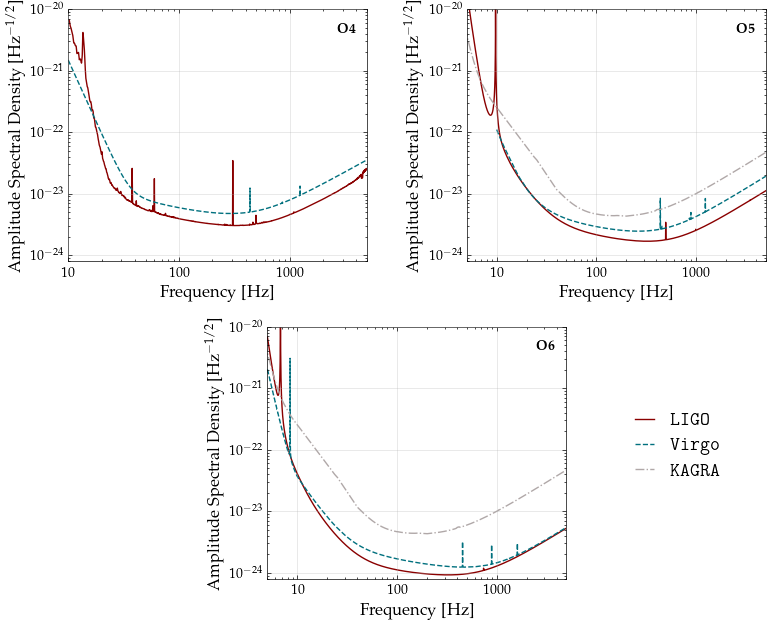

In [4]:
"""
Figure 6.7: 

The 1D and 2D posterior probability distributions for the component masses of the
source binary of GW230529 along with other NSBH and BNS events.

"""

fig = plt.figure(figsize=(9,7.4))
gs = gridspec.GridSpec(4, 4, wspace=1, hspace=0.7, figure=fig)

# O4 run
frequency_ligo_O4, asd_ligo_O4      = np.loadtxt(methodology_data_dir + 'psds/O4/ligo_O4.txt').T
frequency_virgo_O4, asd_virgo_O4    = np.loadtxt(methodology_data_dir + 'psds/O4/virgo_O4.txt').T

ax1 = plt.subplot(gs[:2, :2])
ax1.plot(frequency_ligo_O4, asd_ligo_O4,'-',    label=r'\texttt{LIGO}', color=COLORS_DICT['darkred'])
ax1.plot(frequency_virgo_O4, asd_virgo_O4, '--', label=r'\texttt{Virgo}', color=COLORS_DICT['teal'])
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.tick_params(axis='x', which='major', pad=4)

ax1.set_xlim(10, 5000)
ax1.set_ylim(10**-24.1, 10**-20)

# O5 run
frequency_ligo_O5, asd_ligo_O5      = np.loadtxt(methodology_data_dir + 'psds/O5/ligo_O5.txt').T
frequency_virgo_O5, asd_virgo_O5    = np.loadtxt(methodology_data_dir + 'psds/O5/virgo_O5.txt').T
frequency_kagra_O5, asd_kagra_O5    = np.loadtxt(methodology_data_dir + 'psds/O5/kagra_O5.txt').T

ax2 = plt.subplot(gs[:2, 2:])
ax2.plot(frequency_ligo_O5, asd_ligo_O5, '-',    label=r'\texttt{LIGO}', color=COLORS_DICT['darkred'])
ax2.plot(frequency_virgo_O5, asd_virgo_O5, '--',  label=r'\texttt{Virgo}', color=COLORS_DICT['teal'])
ax2.plot(frequency_kagra_O5, asd_kagra_O5, '-.',  label=r'\texttt{KAGRA}', color=COLORS_DICT['gray'])
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.tick_params(axis='x', which='major', pad=4)
ax2.set_xlim(5, 5000)
ax2.set_ylim(10**-24.1, 10**-20)


# O5 run
frequency_ligo_O5, asd_ligo_O5 = np.loadtxt(methodology_data_dir + 'psds/O6/ligo_O6.txt').T
frequency_virgo_O5, asd_virgo_O5 = np.loadtxt(methodology_data_dir + 'psds/O6/virgo_O6.txt').T
frequency_kagra_O5, asd_kagra_O5 = np.loadtxt(methodology_data_dir + 'psds/O6/kagra_O6.txt').T

ax3 = plt.subplot(gs[2:4, 1:3])
ax3.plot(frequency_ligo_O5, asd_ligo_O5, '-',    	label=r'\texttt{LIGO}', color=COLORS_DICT['darkred'])
ax3.plot(frequency_virgo_O5, asd_virgo_O5**0.5, '--', label=r'\texttt{Virgo}', color=COLORS_DICT['teal'])
ax3.plot(frequency_kagra_O5, asd_kagra_O5, '-.',      label=r'\texttt{KAGRA}', color=COLORS_DICT['gray'])
ax3.set_xscale("log")
ax3.set_yscale("log")
ax3.tick_params(axis='x', which='major', pad=4)
ax3.set_xlim(5, 5000)
ax3.set_ylim(10**-24.1, 10**-20)

for i, axes in enumerate([ax1, ax2, ax3]):
    axes.set_xticks([10, 100, 1000])
    axes.set_xticklabels(labels=[10, 100, 1000])

    axes.set_xlabel('Frequency [Hz]', fontsize=12, labelpad=3)

    axes.set_ylabel('Amplitude Spectral Density [Hz$^{-1/2}$]', fontsize=12, labelpad=4)


ax1.annotate(r"$\textbf{O4}$",
            xy=(0.9, 0.91), 
            xycoords='axes fraction',
            size=10,
            bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

ax2.annotate(r"$\textbf{O5}$",
            xy=(0.9, 0.91), 
            xycoords='axes fraction',
            size=10,
            bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

ax3.annotate(r"$\textbf{O6}$",
            xy=(0.9, 0.91), 
            xycoords='axes fraction',
            size=10,
            bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

# add the legend to the plot
handles = [Line2D([], [], color=COLORS_DICT["darkred"], ls="-"), 
           Line2D([], [], color=COLORS_DICT["teal"], ls="--"),
           Line2D([], [], color=COLORS_DICT["gray"], ls="-.")]

labels = [r"$\texttt{LIGO}$", r"$\texttt{Virgo}$", r"$\texttt{KAGRA}$"]
legend = plt.legend(handles, labels, loc=(1.2, 0.38), fontsize=14)
for i in legend.legend_handles:
    i.set_linewidth(1)

fig.savefig(methodology_dir + "network_asd.pdf")
fig.savefig(methodology_dir + "network_asd.png")

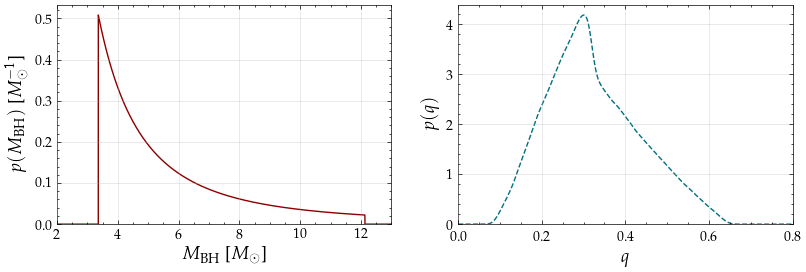

In [160]:
"""
Figure 6.7: Transmission rate of the Zwicky Transient Facility and the Vera C.
Rubin Obervatory.

The 1D and 2D posterior probability distributions for the component masses of the
source binary of GW230529 along with other NSBH and BNS events.

"""

COLORS_FILTERS_DICT = {'u': 'purple',
                       'g': 'tab:blue',
                       'r': 'tab:green',
                       'z': 'tab:red',
                       'i': 'gold',
                       'y': 'darkred'
                       }

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(3.39 * 3.5 * 0.8, 2.64 * 1.2 * 0.9))
plt.subplots_adjust(wspace=0.2)

mass_1_array, p_of_m1 = np.loadtxt(methodology_data_dir + 'prob_functions/p_of_m1.txt').T
q_array, p_of_q = np.loadtxt(methodology_data_dir + 'prob_functions/p_of_q.txt').T

axes[0].plot(mass_1_array, p_of_m1, color=COLORS_DICT['darkred'])
axes[0].set_xlabel(r'$M_{\rm BH}$ [$M_\odot$]', fontsize=13, labelpad=3)
axes[0].set_ylabel(r'$p(M_{\rm BH})$ [$M_\odot^{-1}$]', fontsize=13, labelpad=5)
axes[0].set_xlim(2, 13)
axes[0].set_ylim(0)

axes[1].plot(q_array, p_of_q, '--', color=COLORS_DICT['teal'])
axes[1].set_xlabel(r'$q$', fontsize=13, labelpad=3)
axes[1].set_ylabel(r'$p(q)$', fontsize=13, labelpad=5)
axes[1].set_xlim(0, 0.8)
axes[1].set_xticks([0, 0.2, 0.4, 0.6, 0.8])
axes[1].set_ylim(0)
axes[1].tick_params(axis='x', which='major', pad=5)

fig.savefig(methodology_dir + "mass_distributions.pdf")
fig.savefig(methodology_dir + "mass_distributions.png")

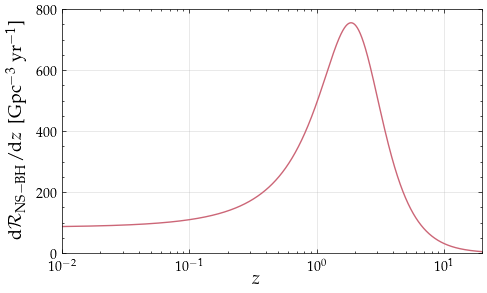

In [53]:
"""
Figure 6.8: 

The 1D and 2D posterior probability distributions for the component masses of the
source binary of GW230529 along with other NSBH and BNS events.

"""

fig, ax = plt.subplots(figsize=FIG_SIZES["rectangle_plot"])

z_array, merger_rate = np.loadtxt(methodology_data_dir + 'prob_functions/merger_rate.txt').T

ax.plot(z_array, merger_rate)
ax.set_xscale("log")
ax.set_xlim(0.01, 20)
ax.set_ylim(0, 800)
ax.set_yticks([0, 200, 400, 600, 800])
ax.tick_params(axis='x', which='major', pad=6)

fig.supxlabel("$z$", x=0.48, y=-0.00, fontsize=13)
fig.supylabel(r"$\text{d}\mathcal{R}_{\rm NS-BH}/\text{d}z\,$ [Gpc$^{-3}$ yr$^{-1}$]", y=0.5, x=0.02, fontsize=13)

fig.savefig(methodology_dir + "merger_rate_distribution.pdf")
fig.savefig(methodology_dir + "merger_rate_distribution.png")

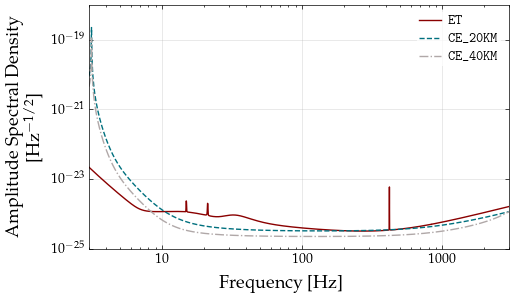

In [89]:

fig, ax = plt.subplots(figsize=FIG_SIZES["rectangle_plot"])

frequency_et, asd_et            = np.loadtxt(methodology_data_dir + 'psds/3G/et.txt').T
frequency_ce_20, asd_ce_20      = np.loadtxt(methodology_data_dir + 'psds/3G/ce2_20km_cb.txt').T
frequency_ce_40, asd_ce_40      = np.loadtxt(methodology_data_dir + 'psds/3G/ce2_40km_cb.txt').T

ax.plot(frequency_et, asd_et, '-',    	label=r'\texttt{LIGO}', color=COLORS_DICT['darkred'])
ax.plot(frequency_ce_20, asd_ce_20, '--', label=r'\texttt{Virgo}', color=COLORS_DICT['teal'])
ax.plot(frequency_ce_40, asd_ce_40, '-.',      label=r'\texttt{KAGRA}', color=COLORS_DICT['gray'])
ax.set_xscale("log")
ax.set_yscale("log")
ax.tick_params(axis='x', which='major', pad=4)
ax.set_xlim(3, 3000)
ax.set_ylim(10**-25, 10**-18)

handles = [Line2D([], [], color=COLORS_DICT["darkred"], ls="-"), 
           Line2D([], [], color=COLORS_DICT["teal"], ls="--"),
           Line2D([], [], color=COLORS_DICT["gray"], ls="-.")]
labels = [r"$\texttt{ET}$", r"$\texttt{CE_20KM}$", r"$\texttt{CE_40KM}$"]

legend = plt.legend(handles, labels, loc=(0.78, 0.75))
for i in legend.legend_handles:
    i.set_linewidth(1)

ax.set_xticks([10, 100, 1000])
ax.set_xticklabels(labels=[10, 100, 1000])

fig.supxlabel('Frequency [Hz]', x=0.48, y=-0.03, fontsize=13)
ax.set_ylabel('Amplitude Spectral Density\n [Hz$^{-1/2}$]', y=0.5, x=-0.0, fontsize=13)

fig.savefig(methodology_dir + "3g_network_asd.pdf")
fig.savefig(methodology_dir + "3g_network_asd.png")

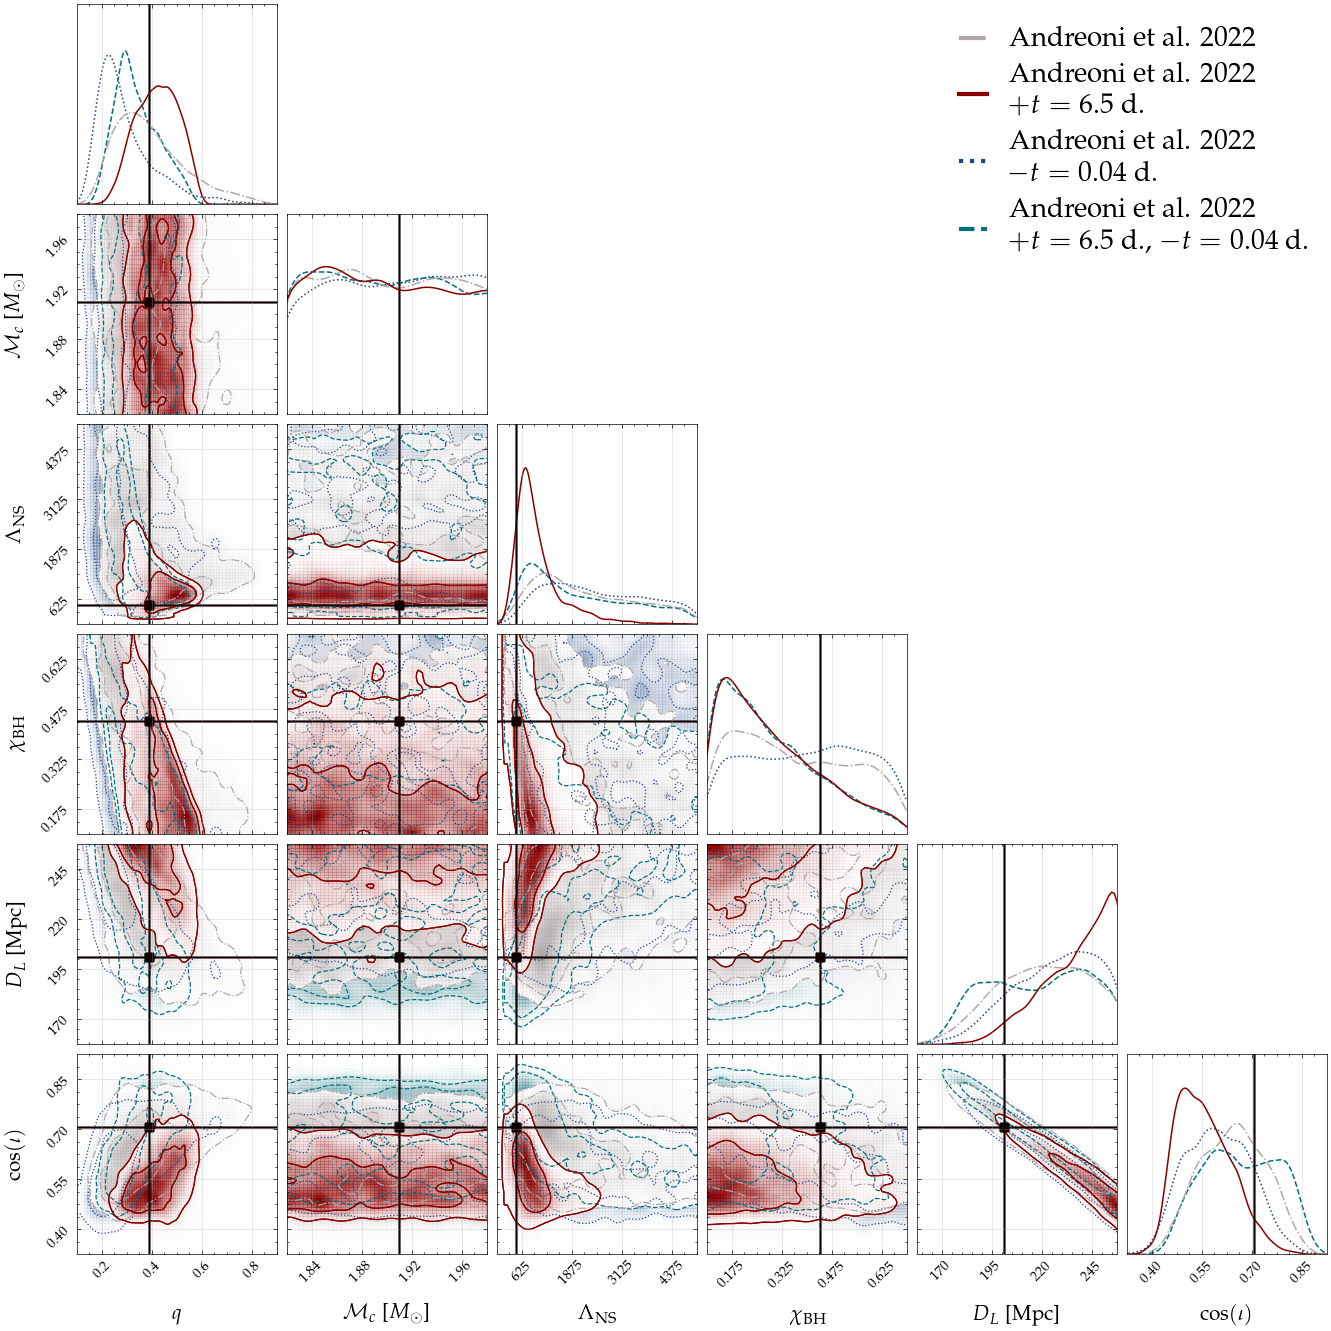

In [5]:
"""
Figure 6.6: Comparison between the different samplers.


The 1D and 2D posterior probability distributions for the component masses of the
source binary of GW230529 along with other NSBH and BNS events.

"""

# load data
label_key = ['andreoni_preferred_strategy_without_early_times', 'andreoni_preferred_strategy_without_early_times_with_late_time_obs',
             'andreoni_preferred_strategy', 'andreoni_preferred_strategy_with_late_time_obs', ]

results_list = [bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_1/{label}/em_run/', label='em') for i, label in enumerate(label_key)]

COLORS_RUNS = {'andreoni_preferred_strategy'                                        : COLORS_DICT['gray'],
               'andreoni_preferred_strategy_with_late_time_obs'                     : COLORS_DICT['darkred'],
               'andreoni_preferred_strategy_without_early_times'                    : COLORS_DICT['navy'],
               'andreoni_preferred_strategy_without_early_times_with_late_time_obs' : COLORS_DICT['teal']}

LINESTYLE_RUNS = {'andreoni_preferred_strategy'                                         : '-.',
                  'andreoni_preferred_strategy_with_late_time_obs'                      : '-',
                  'andreoni_preferred_strategy_without_early_times'                     : ':',
                  'andreoni_preferred_strategy_without_early_times_with_late_time_obs'  : '--'}

direction  = "in"
smoothing  = 1.8
nbins      = 60

posteriors = ['mass_ratio', 'chirp_mass', 'lambda_2', 'chi_1', 'luminosity_distance', 'cos_theta_jn']
param_labels = [r'$q$', r'$\mathcal{M}_c$ [$M_\odot$]', r'$\Lambda_{\rm NS}$', r'$\chi_{\rm BH}$', '$D_L$ [Mpc]', r'$\cos(\iota)$']
truth_values = [0.39, 1.9102896946252306, 490.32033763361954, 0.44, 201, 0.707]

for i, label in enumerate(label_key):

    if i == 0:
        fig = corner.corner(
            np.array([results_list[i].posterior[key] for key in posteriors]).T,
            bins            = nbins,
            labels          = param_labels,
            fill_contours   = False,
            plot_datapoints = False,
            color           = COLORS_RUNS[label],
            smooth          = smoothing,
            levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
            plot_kwargs     = dict(linestyle = LINESTYLE_RUNS[label]),
            hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
            contour_kwargs  = dict(linestyles=LINESTYLE_RUNS[label], linewidths=[LINEWIDTHS["curve"]]),
            plot_density    = True,
        )

    else:

        corner.corner(
            np.array([results_list[i].posterior[key] for key in posteriors]).T,
            fig             = fig,
            bins            = nbins,
            labels          = param_labels,
            fill_contours   = False,
            plot_datapoints = False,
            color           = COLORS_RUNS[label],
            smooth          = smoothing,
            truths          = truth_values,
            truth_color     = COLORS_DICT["black"],
            levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
            plot_kwargs     = dict(linestyle = "-"),
            hist_kwargs     = {"density": True, "linestyle": '-', "linewidth": 0.0},
            contour_kwargs  = dict(linestyles=LINESTYLE_RUNS[label], linewidths=[LINEWIDTHS["curve"]]),
            plot_density    = True,
            labelpad        = -0.05,
        )

# Evaluate KDE
kde_mass_ratio              = [gaussian_kde(results_list[i].posterior["mass_ratio"].to_numpy()) for i in range(len(results_list))]
kde_chirp_mass              = [gaussian_kde(results_list[i].posterior["chirp_mass"].to_numpy()) for i in range(len(results_list))]
kde_lambda_2                = [gaussian_kde(results_list[i].posterior["lambda_2"].to_numpy()) for i in range(len(results_list))]
kde_chi_1                   = [gaussian_kde(results_list[i].posterior["chi_1"].to_numpy()) for i in range(len(results_list))]
kde_luminosity_distance     = [gaussian_kde(results_list[i].posterior["luminosity_distance"].to_numpy()) for i in range(len(results_list))]
kde_cos_theta_jn            = [gaussian_kde(results_list[i].posterior["cos_theta_jn"].to_numpy()) for i in range(len(results_list))]

kdes = [kde_mass_ratio, kde_chirp_mass, kde_lambda_2, kde_chi_1, kde_luminosity_distance, kde_cos_theta_jn]
kdes_ranges = [np.linspace(0.1, 1, 1000), np.linspace(1.8, 2.1, 1000), np.linspace(0, 5000, 1000), 
               np.linspace(0.1, 0.7, 1000), np.linspace(150, 280, 100),  np.linspace(0.1, 1, 1000)]

mass_ratio_ticks            = [0.2, 0.4, 0.6, 0.8]
chirp_mass_ticks            = [1.84, 1.88, 1.92, 1.96]
lambda_2_ticks              = [625, 1875, 3125, 4375]
chi_1_ticks                 = [0.175, 0.325, 0.475, 0.625]
luminosity_distance_ticks   = [170, 195, 220, 245]
cos_theta_jn_ticks          = [0.4, 0.55, 0.7, 0.85]


for j, axes in enumerate([0, 7, 14, 21, 28, 35]):
    for i, label in enumerate(label_key):
        fig.get_axes()[axes].plot(kdes_ranges[j], kdes[j][i](kdes_ranges[j]), color=COLORS_RUNS[label], linestyle=LINESTYLE_RUNS[label], linewidth=1.1)

corner.corner(
            np.array([results_list[i].posterior[key] for key in posteriors]).T,
            fig             = fig,
            bins            = nbins,
            labels          = param_labels,
            fill_contours   = False,
            plot_datapoints = False,
            color           = COLORS_RUNS[label],
            smooth          = smoothing,
            truths          = truth_values,
            truth_color     = COLORS_DICT["black"],
            levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
            plot_kwargs     = dict(linestyle = "-"),
            hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
            contour_kwargs  = dict(linestyles=LINESTYLE_RUNS[label], linewidths=[LINEWIDTHS["curve"]]),
            plot_density    = True,
            labelpad        = -0.05,
        )

# mass_ratio 1D-distribution
fig.get_axes()[0].set_xticks(mass_ratio_ticks)

# mass_ratio-lambda_2 2D distribution
fig.get_axes()[6].set_xticks(mass_ratio_ticks)
fig.get_axes()[6].set_yticks(chirp_mass_ticks)

# lambda_2 1D distribution
fig.get_axes()[7].set_xticks(chirp_mass_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[12].set_xticks(mass_ratio_ticks)
fig.get_axes()[12].set_yticks(lambda_2_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[13].set_xticks(chirp_mass_ticks)
fig.get_axes()[13].set_yticks(lambda_2_ticks)

# mwind 1D distribution
fig.get_axes()[14].set_xticks(lambda_2_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[18].set_xticks(mass_ratio_ticks)
fig.get_axes()[18].set_yticks(chi_1_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[19].set_xticks(chirp_mass_ticks)
fig.get_axes()[19].set_yticks(chi_1_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[20].set_xticks(lambda_2_ticks)
fig.get_axes()[20].set_yticks(chi_1_ticks)

# mwind 1D distribution
fig.get_axes()[21].set_xticks(chi_1_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[24].set_xticks(mass_ratio_ticks)
fig.get_axes()[24].set_yticks(luminosity_distance_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[25].set_xticks(chirp_mass_ticks)
fig.get_axes()[25].set_yticks(luminosity_distance_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[26].set_xticks(lambda_2_ticks)
fig.get_axes()[26].set_yticks(luminosity_distance_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[27].set_xticks(chi_1_ticks)
fig.get_axes()[27].set_yticks(luminosity_distance_ticks)

# mwind 1D distribution
fig.get_axes()[28].set_xticks(luminosity_distance_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[30].set_xticks(mass_ratio_ticks)
fig.get_axes()[30].set_yticks(cos_theta_jn_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[31].set_xticks(chirp_mass_ticks)
fig.get_axes()[31].set_yticks(cos_theta_jn_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[32].set_xticks(lambda_2_ticks)
fig.get_axes()[32].set_yticks(cos_theta_jn_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[33].set_xticks(chi_1_ticks)
fig.get_axes()[33].set_yticks(cos_theta_jn_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[34].set_xticks(luminosity_distance_ticks)
fig.get_axes()[34].set_yticks(cos_theta_jn_ticks)

# mwind 1D distribution
fig.get_axes()[35].set_xticks(cos_theta_jn_ticks)

# Tune x and y limits
mass_ratio_min, mass_ratio_max                       = 0.1, 0.9
chirp_mass_min, chirp_mass_max                       = 1.82, 1.98
lambda_2_min, lambda_2_max                           = 0, 5000
chi_1_min, chi_1_max                                 = 0.1, 0.7
luminosity_distance_min, luminosity_distance_max     = 170 - 12.5, 245 + 12.5
cos_theta_jn_min, cos_theta_jn_max                   = 0.4 - 0.075, 0.85 + 0.075

# mass_ratio 1D-distribution
fig.get_axes()[0].set_xlim([mass_ratio_min, mass_ratio_max])

# mass_ratio-lambda_2 2D distribution
fig.get_axes()[6].set_xlim([mass_ratio_min, mass_ratio_max])
fig.get_axes()[6].set_ylim([chirp_mass_min, chirp_mass_max])

# lambda_2 1D distribution
fig.get_axes()[7].set_xlim([chirp_mass_min, chirp_mass_max])

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[12].set_xlim([mass_ratio_min, mass_ratio_max])
fig.get_axes()[12].set_ylim([lambda_2_min, lambda_2_max])

# vdyn-mwind 2D distribution
fig.get_axes()[13].set_xlim([chirp_mass_min, chirp_mass_max])
fig.get_axes()[13].set_ylim([lambda_2_min, lambda_2_max])

# mwind 1D distribution
fig.get_axes()[14].set_xlim([lambda_2_min, lambda_2_max])

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[18].set_xlim([mass_ratio_min, mass_ratio_max])
fig.get_axes()[18].set_ylim([chi_1_min, chi_1_max])

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[19].set_xlim([chirp_mass_min, chirp_mass_max])
fig.get_axes()[19].set_ylim([chi_1_min, chi_1_max])

# vdyn-mwind 2D distribution
fig.get_axes()[20].set_xlim([lambda_2_min, lambda_2_max])
fig.get_axes()[20].set_ylim([chi_1_min, chi_1_max])

# mwind 1D distribution
fig.get_axes()[21].set_xlim([chi_1_min, chi_1_max])

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[24].set_xlim([mass_ratio_min, mass_ratio_max])
fig.get_axes()[24].set_ylim([luminosity_distance_min, luminosity_distance_max])

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[25].set_xlim([chirp_mass_min, chirp_mass_max])
fig.get_axes()[25].set_ylim([luminosity_distance_min, luminosity_distance_max])

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[26].set_xlim([lambda_2_min, lambda_2_max])
fig.get_axes()[26].set_ylim([luminosity_distance_min, luminosity_distance_max])

# vdyn-mwind 2D distribution
fig.get_axes()[27].set_xlim([chi_1_min, chi_1_max])
fig.get_axes()[27].set_ylim([luminosity_distance_min, luminosity_distance_max])

# mwind 1D distribution
fig.get_axes()[28].set_xlim([luminosity_distance_min, luminosity_distance_max])

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[30].set_xlim([mass_ratio_min, mass_ratio_max])
fig.get_axes()[30].set_ylim([cos_theta_jn_min, cos_theta_jn_max])

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[31].set_xlim([chirp_mass_min, chirp_mass_max])
fig.get_axes()[31].set_ylim([cos_theta_jn_min, cos_theta_jn_max])

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[32].set_xlim([lambda_2_min, lambda_2_max])
fig.get_axes()[32].set_ylim([cos_theta_jn_min, cos_theta_jn_max])

# vdyn-mwind 2D distribution
fig.get_axes()[33].set_xlim([chi_1_min, chi_1_max])
fig.get_axes()[33].set_ylim([cos_theta_jn_min, cos_theta_jn_max])

# vdyn-mwind 2D distribution
fig.get_axes()[34].set_xlim([luminosity_distance_min, luminosity_distance_max])
fig.get_axes()[34].set_ylim([cos_theta_jn_min, cos_theta_jn_max])

# mwind 1D distribution
fig.get_axes()[35].set_xlim([cos_theta_jn_min, cos_theta_jn_max])

labels_legend = ['Andreoni et al. 2022',
                 'Andreoni et al. 2022\n $+ t = 6.5$ d.', 
                 'Andreoni et al. 2022\n\t $- t = 0.04$ d.',
                 'Andreoni et al. 2022\n\t $+ t = 6.5$ d., $- t = 0.04$ d.',
                 ]

labels = ['andreoni_preferred_strategy', 'andreoni_preferred_strategy_with_late_time_obs',
          'andreoni_preferred_strategy_without_early_times', 'andreoni_preferred_strategy_without_early_times_with_late_time_obs']

handles = [Line2D([], [], color=COLORS_RUNS[key], ls=LINESTYLE_RUNS[key]) for key in labels]
legend = plt.legend(handles, labels_legend, loc=(-0.90, 4.97), fontsize=20)
for i in legend.legend_handles:
    i.set_linewidth(3)

matplotlib.rcParams['axes.formatter.useoffset'] = False

fig.savefig(results_case_studies_dir + "case_study_1/em_corner_plot_andreoni_comparison.pdf")
fig.savefig(results_case_studies_dir + "case_study_1/em_corner_plot_andreoni_comparison.png")

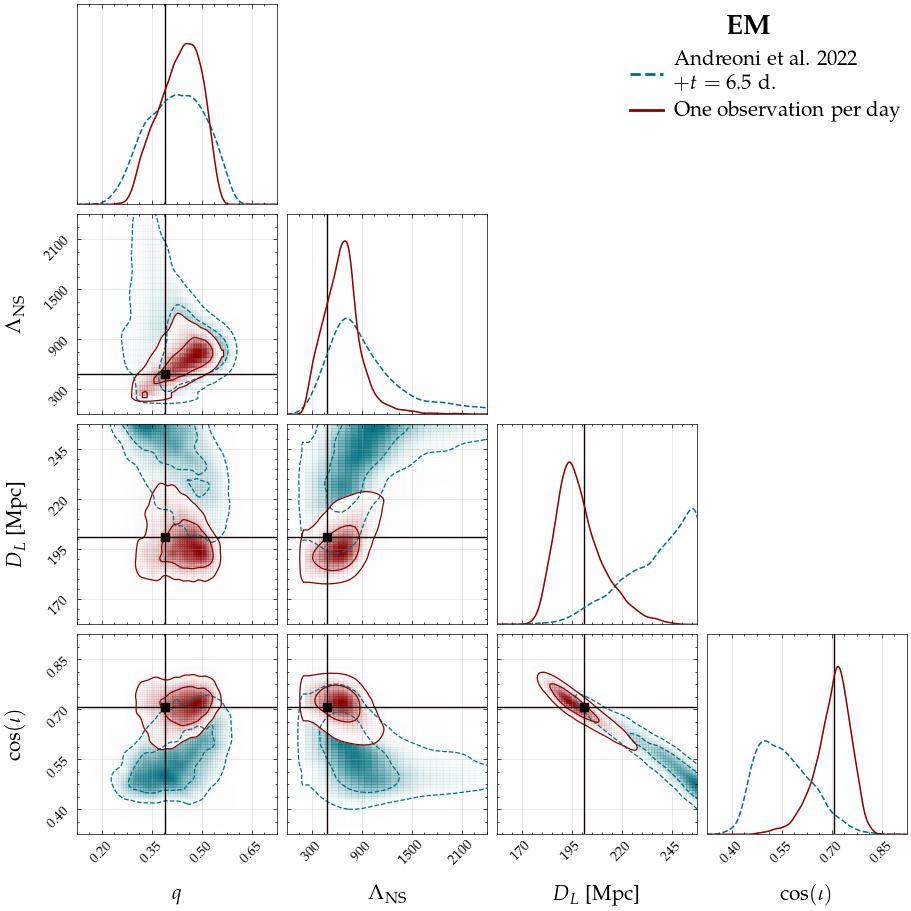

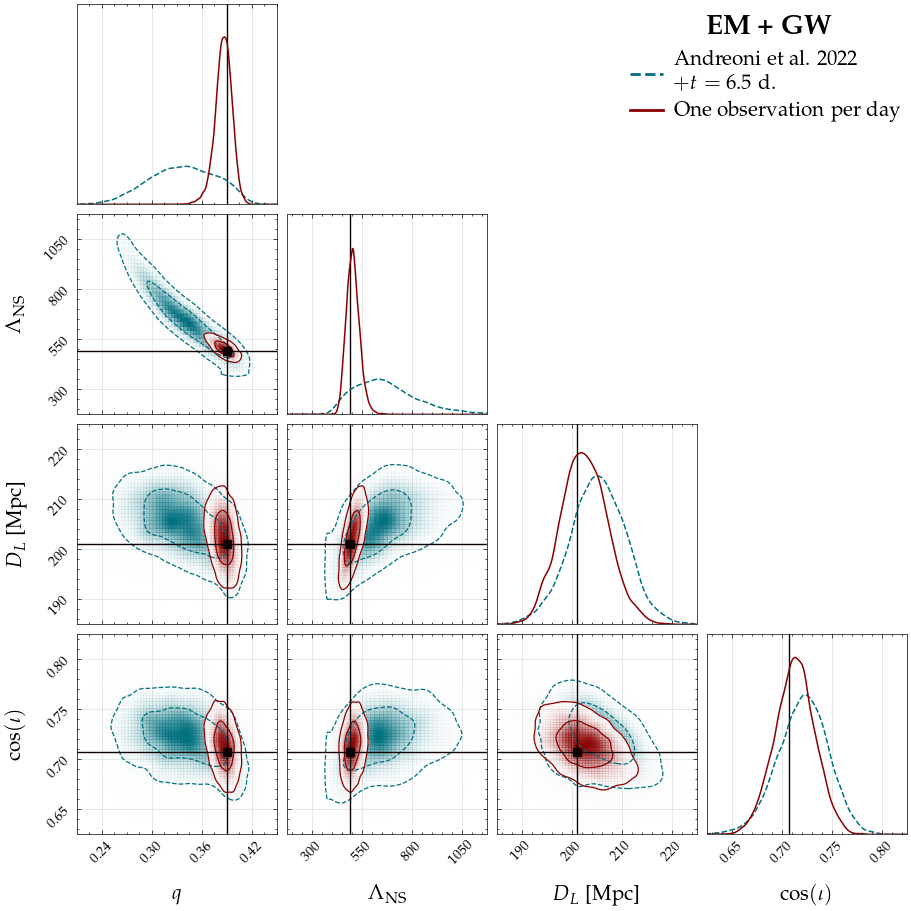

In [15]:
"""
Figure 6.6: Comparison between the different samplers.


The 1D and 2D posterior probability distributions for the component masses of the
source binary of GW230529 along with other NSBH and BNS events.

"""

#fig, axes = plt.subplots(figsize=(12, 7.4 / 2), ncols=2, nrows=1)

# load data
# load data
label_key = ['andreoni_preferred_strategy_with_late_time_obs', 'one_observation_per_day']

results_list = [bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_1/andreoni_preferred_strategy_with_late_time_obs/combined_run/', 
                                            label='em_gw'), 
                bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_1/one_observation_per_day/combined_run/', label='em_gw')]

COLORS_RUNS = {'andreoni_preferred_strategy_with_late_time_obs'      : COLORS_DICT['teal'],
               'one_observation_per_day'     : COLORS_DICT['darkred']}

LINESTYLE_RUNS = {'andreoni_preferred_strategy_with_late_time_obs'     : '--',
                  'one_observation_per_day'    : '-'}

direction  = "in"
smoothing  = 1.8
nbins      = 60
direction  = "in"
smoothing  = 1.8
nbins      = 60

posteriors = ['mass_ratio', 'lambda_2', 'luminosity_distance', 'cos_theta_jn']
param_labels = [r'$q$', r'$\Lambda_{\rm NS}$', r'$D_L$ [Mpc]', r'$\cos(\iota)$']
truth_values = [0.39, 490.32033763361954, 201, 0.707]

for i, label in enumerate(label_key):

    if i == 0:
        fig = corner.corner(
            np.array([results_list[i].posterior[key] for key in posteriors]).T,
            bins            = nbins,
            labels          = param_labels,
            fill_contours   = False,
            plot_datapoints = False,
            color           = COLORS_RUNS[label],
            smooth          = smoothing,
            levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
            plot_kwargs     = dict(linestyle = LINESTYLE_RUNS[label]),
            hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
            contour_kwargs  = dict(linestyles=LINESTYLE_RUNS[label], linewidths=[LINEWIDTHS["curve"]]),
            plot_density    = True,
        )

    else:

        corner.corner(
            np.array([results_list[i].posterior[key] for key in posteriors]).T,
            fig             = fig,
            bins            = nbins,
            labels          = param_labels,
            fill_contours   = False,
            plot_datapoints = False,
            color           = COLORS_RUNS[label],
            smooth          = smoothing,
            truths          = truth_values,
            truth_color     = COLORS_DICT["black"],
            levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
            plot_kwargs     = dict(linestyle = "-"),
            hist_kwargs     = {"density": True, "linestyle": '-', "linewidth": 0.0},
            contour_kwargs  = dict(linestyles=LINESTYLE_RUNS[label], linewidths=[LINEWIDTHS["curve"]]),
            plot_density    = True,
            labelpad        = -0.05,
        )

# Evaluate KDE
kde_mass_ratio              = [gaussian_kde(results_list[i].posterior["mass_ratio"].to_numpy()) for i in range(len(results_list))]
kde_lambda_2                = [gaussian_kde(results_list[i].posterior["lambda_2"].to_numpy()) for i in range(len(results_list))]
kde_luminosity_distance     = [gaussian_kde(results_list[i].posterior["luminosity_distance"].to_numpy()) for i in range(len(results_list))]
kde_cos_theta_jn            = [gaussian_kde(results_list[i].posterior["cos_theta_jn"].to_numpy()) for i in range(len(results_list))]

kdes = [kde_mass_ratio, kde_lambda_2, kde_luminosity_distance, kde_cos_theta_jn]
kdes_ranges = [np.linspace(0.1, 1, 1000), np.linspace(0, 3500, 3000), 
               np.linspace(120, 300, 1000), np.linspace(0.3, 1, 1000)]

mass_ratio_ticks            = [0.24, 0.3, 0.36, 0.42]
lambda_2_ticks              = [300, 550, 800, 1050]
luminosity_distance_ticks   = [190, 200, 210, 220]
cos_theta_jn_ticks          = [0.65, 0.7, 0.75, 0.80]

for j, axes in enumerate([0, 5, 10, 15]):
    for i, label in enumerate(label_key):
        fig.get_axes()[axes].plot(kdes_ranges[j], kdes[j][i](kdes_ranges[j]), color=COLORS_RUNS[label], linestyle=LINESTYLE_RUNS[label], linewidth=1.1)

# mass_ratio 1D-distribution
fig.get_axes()[0].set_xticks(mass_ratio_ticks)

# mass_ratio-lambda_2 2D distribution
fig.get_axes()[4].set_xticks(mass_ratio_ticks)
fig.get_axes()[4].set_yticks(lambda_2_ticks)

# lambda_2 1D distribution
fig.get_axes()[5].set_xticks(lambda_2_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[8].set_xticks(mass_ratio_ticks)
fig.get_axes()[8].set_yticks(luminosity_distance_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[9].set_xticks(lambda_2_ticks)
fig.get_axes()[9].set_yticks(luminosity_distance_ticks)

# mwind 1D distribution
fig.get_axes()[10].set_xticks(luminosity_distance_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[12].set_xticks(mass_ratio_ticks)
fig.get_axes()[12].set_yticks(cos_theta_jn_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[13].set_xticks(lambda_2_ticks)
fig.get_axes()[13].set_yticks(cos_theta_jn_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[14].set_xticks(luminosity_distance_ticks)
fig.get_axes()[14].set_yticks(cos_theta_jn_ticks)

# mwind 1D distribution
fig.get_axes()[15].set_xticks(cos_theta_jn_ticks)

# Tune x and y limits
mass_ratio_min, mass_ratio_max                       = 0.21, 0.45
lambda_2_min, lambda_2_max                           = 300 - 125, 1050 + 125
luminosity_distance_min, luminosity_distance_max     = 185, 225
cos_theta_jn_min, cos_theta_jn_max                   = 0.625, 0.825
# mwind_min, mwind_max        =  0.016, 0.024

# mass_ratio 1D-distribution
fig.get_axes()[0].set_xlim((mass_ratio_min, mass_ratio_max))

# mass_ratio-lambda_2 2D distribution
fig.get_axes()[4].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[4].set_ylim((lambda_2_min, lambda_2_max))

# lambda_2 1D distribution
fig.get_axes()[5].set_xlim((lambda_2_min, lambda_2_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[8].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[8].set_ylim((luminosity_distance_min, luminosity_distance_max))

# vdyn-mwind 2D distribution
fig.get_axes()[9].set_xlim((lambda_2_min, lambda_2_max))
fig.get_axes()[9].set_ylim((luminosity_distance_min, luminosity_distance_max))

# mwind 1D distribution
fig.get_axes()[10].set_xlim((luminosity_distance_min, luminosity_distance_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[12].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[12].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[13].set_xlim((lambda_2_min, lambda_2_max))
fig.get_axes()[13].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# vdyn-mwind 2D distribution
fig.get_axes()[14].set_xlim((luminosity_distance_min, luminosity_distance_max))
fig.get_axes()[14].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# mwind 1D distribution
fig.get_axes()[15].set_xlim((cos_theta_jn_min, cos_theta_jn_max))

# add the legend to the plot
handles = [Line2D([], [], color=COLORS_DICT["darkred"], ls="-"), 
           Line2D([], [], color=COLORS_DICT["teal"], ls="--")]

labels = ['Andreoni et al. 2022\n $+ t = 6.5$ d.', 
          'One observation per day']
legend = plt.legend(reversed(handles), labels, loc=(-0.4, 3.55), fontsize=15)
for i in legend.legend_handles:
    i.set_linewidth(2)

plt.annotate(r"\textbf{EM + GW}",
            xy=(-0, 4), 
            xycoords='axes fraction',
            size=20,
            bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

fig.savefig(results_case_studies_dir + "case_study_1/corner_plot_comparison_combined_too.pdf")
fig.savefig(results_case_studies_dir + "case_study_1/corner_plot_comparison_combined_too.png")

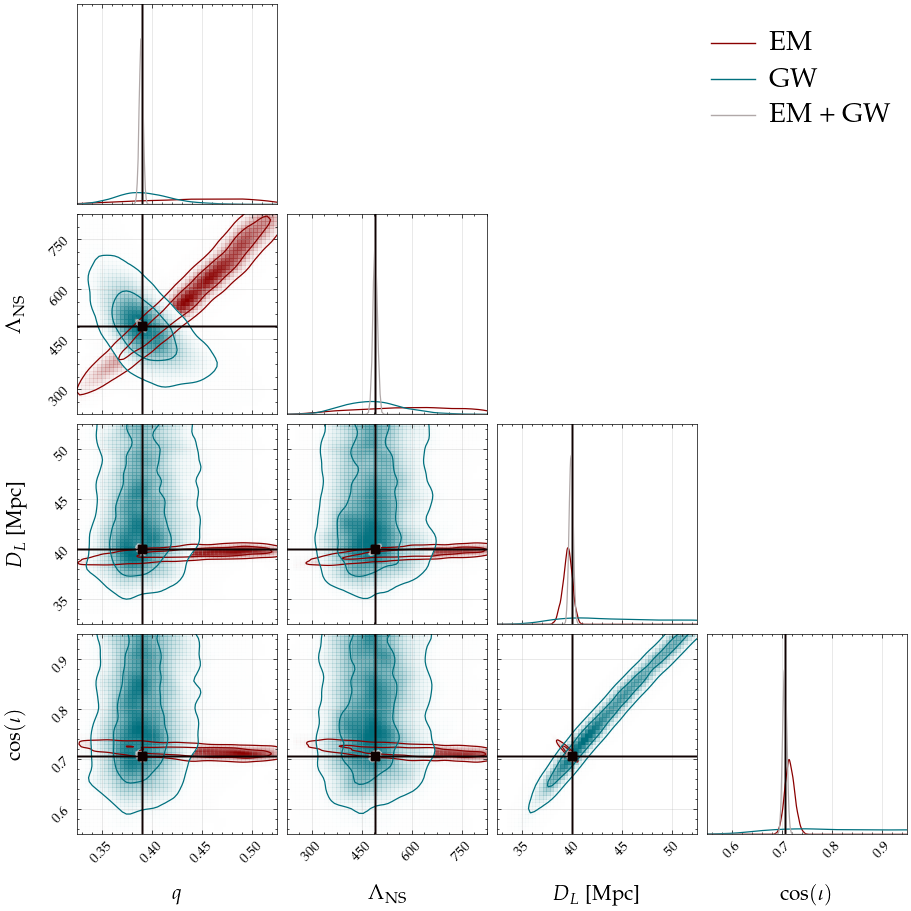

In [6]:
"""
Figure 6.6: Comparison between the different samplers.


The 1D and 2D posterior probability distributions for the component masses of the
source binary of GW230529 along with other NSBH and BNS events.

"""

# load data
folder_key = ['em_run', 'gw_run', 'combined_run']
label_key = ['em', 'gw', 'em_gw']
results_list = [bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_2/40_Mpc/{folder_key[i]}', label=label) for i, label in enumerate(label_key)]
COLORS_RUNS = {'em'         : COLORS_DICT['darkred'],
               'gw'         : COLORS_DICT['teal'],
               'em_gw'      : COLORS_DICT['gray']}

direction  = "in"
smoothing  = 1.8
nbins      = 60

posteriors = ['mass_ratio', 'lambda_2', 'luminosity_distance', 'cos_theta_jn']
param_labels = [r'$q$', r'$\Lambda_{\rm NS}$', r'$D_L$ [Mpc]', r'$\cos(\iota)$']
truth_values = [0.39, 490.32033763361954, 40, 0.707]

for i, label in enumerate(label_key):

    if i == 0:
        fig = corner.corner(
            np.array([results_list[i].posterior[key] for key in posteriors]).T,
            bins            = nbins,
            labels          = param_labels,
            fill_contours   = False,
            plot_datapoints = False,
            color           = COLORS_RUNS[label],
            smooth          = smoothing,
            levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
            plot_kwargs     = dict(linestyle = "-"),
            hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
            contour_kwargs  = dict(linestyles="-", linewidths=[LINEWIDTHS["curve"]]),
            plot_density    = True,
        )

    else:

        corner.corner(
            np.array([results_list[i].posterior[key] for key in posteriors]).T,
            fig             = fig,
            bins            = nbins,
            labels          = param_labels,
            fill_contours   = False,
            plot_datapoints = False,
            color           = COLORS_RUNS[label],
            smooth          = smoothing,
            truths          = truth_values,
            truth_color     = COLORS_DICT["black"],
            levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
            plot_kwargs     = dict(linestyle = "-"),
            hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
            contour_kwargs  = dict(linestyles="-", linewidths=[LINEWIDTHS["curve"]]),
            plot_density    = True,
            labelpad        = -0.05,
        )

# Evaluate KDE
kde_mass_ratio              = [gaussian_kde(results_list[i].posterior["mass_ratio"].to_numpy()) for i in range(len(results_list))]
kde_lambda_2                = [gaussian_kde(results_list[i].posterior["lambda_2"].to_numpy()) for i in range(len(results_list))]
kde_luminosity_distance     = [gaussian_kde(results_list[i].posterior["luminosity_distance"].to_numpy()) for i in range(len(results_list))]
kde_cos_theta_jn            = [gaussian_kde(results_list[i].posterior["cos_theta_jn"].to_numpy()) for i in range(len(results_list))]

kdes = [kde_mass_ratio, kde_lambda_2, kde_luminosity_distance, kde_cos_theta_jn]
kdes_ranges = [np.linspace(0.1, 1, 1000), np.linspace(0, 5000, 1000), 
               np.linspace(20, 60, 1000), np.linspace(0.3, 1, 1000)]

mass_ratio_ticks            = [0.35, 0.40, 0.45, 0.50]
lambda_2_ticks              = [300, 450, 600, 750]
luminosity_distance_ticks   = [35, 40, 45, 50]
cos_theta_jn_ticks          = [0.6, 0.7, 0.8, 0.9]

# xticks = [mdyn_ticks, vdyn_ticks, mwind_ticks]

for j, axes in enumerate([0, 5, 10, 15]):
    for i, label in enumerate(label_key):
        fig.get_axes()[axes].plot(kdes_ranges[j], kdes[j][i](kdes_ranges[j]), color=COLORS_RUNS[label], linestyle="-", linewidth=LINEWIDTHS["curve"])

corner.corner(
            np.array([results_list[i].posterior[key] for key in posteriors]).T,
            fig             = fig,
            bins            = nbins,
            labels          = param_labels,
            fill_contours   = False,
            plot_datapoints = False,
            color           = COLORS_RUNS[label],
            smooth          = smoothing,
            truths          = truth_values,
            truth_color     = COLORS_DICT["black"],
            levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
            plot_kwargs     = dict(linestyle = "-"),
            hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
            contour_kwargs  = dict(linestyles="-", linewidths=[LINEWIDTHS["curve"]]),
            plot_density    = True,
            labelpad        = -0.05,
        )

# mass_ratio 1D-distribution
fig.get_axes()[0].set_xticks(mass_ratio_ticks)

# mass_ratio-lambda_2 2D distribution
fig.get_axes()[4].set_xticks(mass_ratio_ticks)
fig.get_axes()[4].set_yticks(lambda_2_ticks)

# lambda_2 1D distribution
fig.get_axes()[5].set_xticks(lambda_2_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[8].set_xticks(mass_ratio_ticks)
fig.get_axes()[8].set_yticks(luminosity_distance_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[9].set_xticks(lambda_2_ticks)
fig.get_axes()[9].set_yticks(luminosity_distance_ticks)

# mwind 1D distribution
fig.get_axes()[10].set_xticks(luminosity_distance_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[12].set_xticks(mass_ratio_ticks)
fig.get_axes()[12].set_yticks(cos_theta_jn_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[13].set_xticks(lambda_2_ticks)
fig.get_axes()[13].set_yticks(cos_theta_jn_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[14].set_xticks(luminosity_distance_ticks)
fig.get_axes()[14].set_yticks(cos_theta_jn_ticks)

# mwind 1D distribution
fig.get_axes()[15].set_xticks(cos_theta_jn_ticks)

# Tune x and y limits
mass_ratio_min, mass_ratio_max                       = 0.325, 0.525
lambda_2_min, lambda_2_max                           = 225, 825
luminosity_distance_min, luminosity_distance_max     = 32.5, 52.5
cos_theta_jn_min, cos_theta_jn_max                   = 0.55, 0.95

# mass_ratio 1D-distribution
fig.get_axes()[0].set_xlim((mass_ratio_min, mass_ratio_max))

# mass_ratio-lambda_2 2D distribution
fig.get_axes()[4].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[4].set_ylim((lambda_2_min, lambda_2_max))

# lambda_2 1D distribution
fig.get_axes()[5].set_xlim((lambda_2_min, lambda_2_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[8].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[8].set_ylim((luminosity_distance_min, luminosity_distance_max))

# vdyn-mwind 2D distribution
fig.get_axes()[9].set_xlim((lambda_2_min, lambda_2_max))
fig.get_axes()[9].set_ylim((luminosity_distance_min, luminosity_distance_max))

# mwind 1D distribution
fig.get_axes()[10].set_xlim((luminosity_distance_min, luminosity_distance_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[12].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[12].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[13].set_xlim((lambda_2_min, lambda_2_max))
fig.get_axes()[13].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# vdyn-mwind 2D distribution
fig.get_axes()[14].set_xlim((luminosity_distance_min, luminosity_distance_max))
fig.get_axes()[14].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# mwind 1D distribution
fig.get_axes()[15].set_xlim((cos_theta_jn_min, cos_theta_jn_max))

# add the legend to the plot
handles = [Line2D([], [], color=COLORS_DICT["darkred"], ls="-"), 
           Line2D([], [], color=COLORS_DICT["teal"], ls="-"),
           Line2D([], [], color=COLORS_DICT["gray"], ls="-")]

labels = [r'EM', r'GW', r'EM + GW']
legend = plt.legend(handles, labels, loc=(0, 3.5), fontsize=20)
for i in legend.legend_handles:
    i.set_linewidth(1)

fig.savefig(results_case_studies_dir + "case_study_2/corner_plot_40Mpc.pdf")
fig.savefig(results_case_studies_dir + "case_study_2/corner_plot_40Mpc.png")


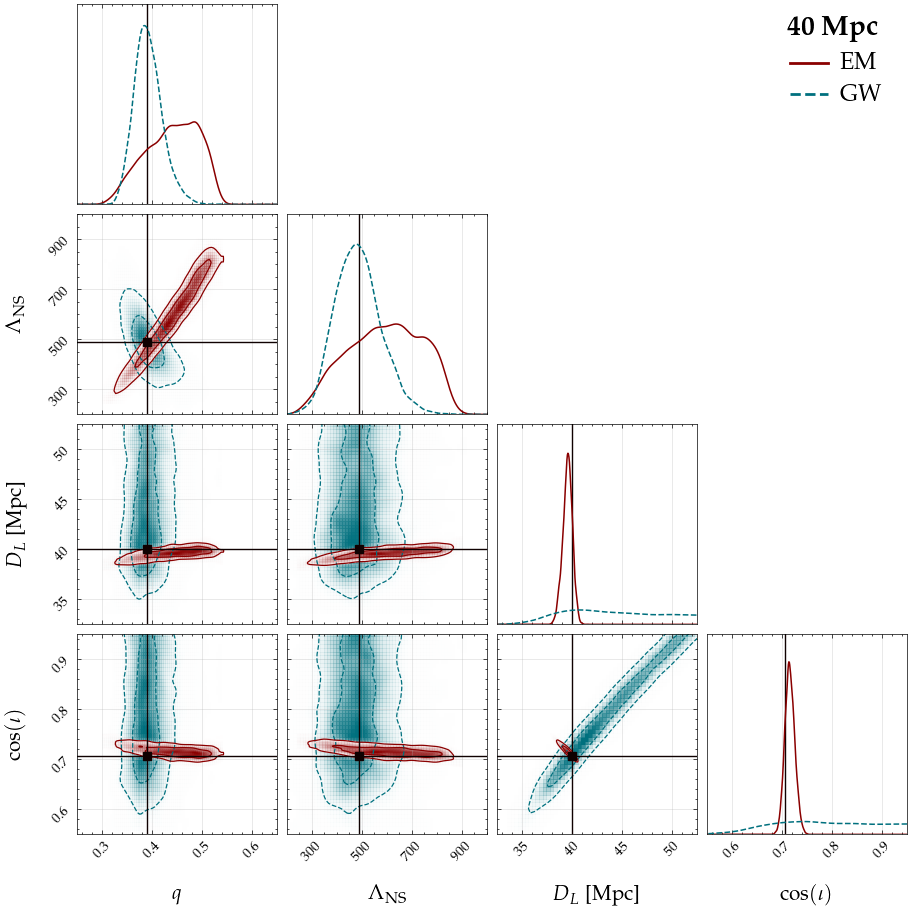

In [30]:
"""
Figure 6.6: Comparison between the different samplers.


The 1D and 2D posterior probability distributions for the component masses of the
source binary of GW230529 along with other NSBH and BNS events.

"""

#fig, axes = plt.subplots(figsize=(12, 7.4 / 2), ncols=2, nrows=1)

# load data

label_key = ['em', 'gw']
results_list = [bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_2/40_Mpc/em_run', label='em'),
                bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_2/40_Mpc/gw_run', label='gw')]
COLORS_RUNS = {'em'               : COLORS_DICT['darkred'],
               'gw'               : COLORS_DICT['teal']}

LINESTYLE_RUNS = {'em'        : '-',
                  'gw'     : '--'}

direction  = "in"
smoothing  = 1.8
nbins      = 60

posteriors = ['mass_ratio', 'lambda_2', 'luminosity_distance', 'cos_theta_jn']
param_labels = [r'$q$', r'$\Lambda_{\rm NS}$', r'$D_L$ [Mpc]', r'$\cos(\iota)$']
truth_values = [0.39, 490.32033763361954, 40, 0.707]

fig = corner.corner(
    np.array([results_list[1].posterior[key] for key in posteriors]).T,
    bins            = nbins,
    labels          = param_labels,
    fill_contours   = False,
    plot_datapoints = False,
    color           = COLORS_RUNS['gw'],
    smooth          = smoothing,
    levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
    plot_kwargs     = dict(linestyle = "-"),
    hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
    contour_kwargs  = dict(linestyles=LINESTYLE_RUNS['gw'], linewidths=[LINEWIDTHS["curve"]]),
    plot_density    = True,
)

corner.corner(
    np.array([results_list[0].posterior[key] for key in posteriors]).T,
    fig             = fig,
    bins            = nbins,
    labels          = param_labels,
    fill_contours   = False,
    plot_datapoints = False,
    color           = COLORS_RUNS['em'],
    smooth          = smoothing,
    truths          = truth_values,
    truth_color     = COLORS_DICT["black"],
    levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
    plot_kwargs     = dict(linestyle = "-"),
    hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
    contour_kwargs  = dict(linestyles=LINESTYLE_RUNS['em'], linewidths=[LINEWIDTHS["curve"]]),
    plot_density    = True,
    labelpad        = -0.05,
)

# Evaluate KDE
kde_mass_ratio              = [gaussian_kde(results_list[i].posterior["mass_ratio"].to_numpy()) for i in range(len(results_list))]
kde_lambda_2                = [gaussian_kde(results_list[i].posterior["lambda_2"].to_numpy()) for i in range(len(results_list))]
kde_luminosity_distance     = [gaussian_kde(results_list[i].posterior["luminosity_distance"].to_numpy()) for i in range(len(results_list))]
kde_cos_theta_jn            = [gaussian_kde(results_list[i].posterior["cos_theta_jn"].to_numpy()) for i in range(len(results_list))]

kdes = [kde_mass_ratio, kde_lambda_2, kde_luminosity_distance, kde_cos_theta_jn]
kdes_ranges = [np.linspace(0.1, 1, 1000), np.linspace(0, 3500, 3000), 
               np.linspace(10, 60, 1000), np.linspace(0.1, 1, 1000)]

mass_ratio_ticks            = [0.3, 0.4, 0.5, 0.6]
lambda_2_ticks              = [300, 500, 700, 900]
luminosity_distance_ticks   = [35, 40, 45, 50]
cos_theta_jn_ticks          = [0.6, 0.7, 0.8, 0.9]

for j, axes in enumerate([0, 5, 10, 15]):
    for i, label in enumerate(label_key):
        fig.get_axes()[axes].plot(kdes_ranges[j], kdes[j][i](kdes_ranges[j]), color=COLORS_RUNS[label], linestyle=LINESTYLE_RUNS[label], linewidth=1.1)

# mass_ratio 1D-distribution
fig.get_axes()[0].set_xticks(mass_ratio_ticks)

# mass_ratio-lambda_2 2D distribution
fig.get_axes()[4].set_xticks(mass_ratio_ticks)
fig.get_axes()[4].set_yticks(lambda_2_ticks)

# lambda_2 1D distribution
fig.get_axes()[5].set_xticks(lambda_2_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[8].set_xticks(mass_ratio_ticks)
fig.get_axes()[8].set_yticks(luminosity_distance_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[9].set_xticks(lambda_2_ticks)
fig.get_axes()[9].set_yticks(luminosity_distance_ticks)

# mwind 1D distribution
fig.get_axes()[10].set_xticks(luminosity_distance_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[12].set_xticks(mass_ratio_ticks)
fig.get_axes()[12].set_yticks(cos_theta_jn_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[13].set_xticks(lambda_2_ticks)
fig.get_axes()[13].set_yticks(cos_theta_jn_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[14].set_xticks(luminosity_distance_ticks)
fig.get_axes()[14].set_yticks(cos_theta_jn_ticks)

# mwind 1D distribution
fig.get_axes()[15].set_xticks(cos_theta_jn_ticks)

# Tune x and y limits
mass_ratio_min, mass_ratio_max                       = 0.25, 0.65
lambda_2_min, lambda_2_max                           = 200, 1000
luminosity_distance_min, luminosity_distance_max     = 35 - 2.5, 50 + 2.5
cos_theta_jn_min, cos_theta_jn_max                   = 0.55, 0.95
# mwind_min, mwind_max        =  0.016, 0.024

# mass_ratio 1D-distribution
fig.get_axes()[0].set_xlim((mass_ratio_min, mass_ratio_max))

# mass_ratio-lambda_2 2D distribution
fig.get_axes()[4].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[4].set_ylim((lambda_2_min, lambda_2_max))

# lambda_2 1D distribution
fig.get_axes()[5].set_xlim((lambda_2_min, lambda_2_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[8].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[8].set_ylim((luminosity_distance_min, luminosity_distance_max))

# vdyn-mwind 2D distribution
fig.get_axes()[9].set_xlim((lambda_2_min, lambda_2_max))
fig.get_axes()[9].set_ylim((luminosity_distance_min, luminosity_distance_max))

# mwind 1D distribution
fig.get_axes()[10].set_xlim((luminosity_distance_min, luminosity_distance_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[12].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[12].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[13].set_xlim((lambda_2_min, lambda_2_max))
fig.get_axes()[13].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# vdyn-mwind 2D distribution
fig.get_axes()[14].set_xlim((luminosity_distance_min, luminosity_distance_max))
fig.get_axes()[14].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# mwind 1D distribution
fig.get_axes()[15].set_xlim((cos_theta_jn_min, cos_theta_jn_max))

# add the legend to the plot
handles = [Line2D([], [], color=COLORS_DICT["darkred"], ls="-"), 
           Line2D([], [], color=COLORS_DICT["teal"], ls="--")]

labels = ['EM', 'GW']
legend = plt.legend(handles, labels, loc=(0.4, 3.62), fontsize=17)
for i in legend.legend_handles:
    i.set_linewidth(2)

plt.annotate(r"\textbf{40 Mpc}",
            xy=(0.4, 4), 
            xycoords='axes fraction',
            size=20,
            bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

fig.savefig(results_case_studies_dir + "case_study_2/corner_plot_comparison_distances_40Mpc.pdf")
fig.savefig(results_case_studies_dir + "case_study_2/corner_plot_comparison_distances_40Mpc.png")


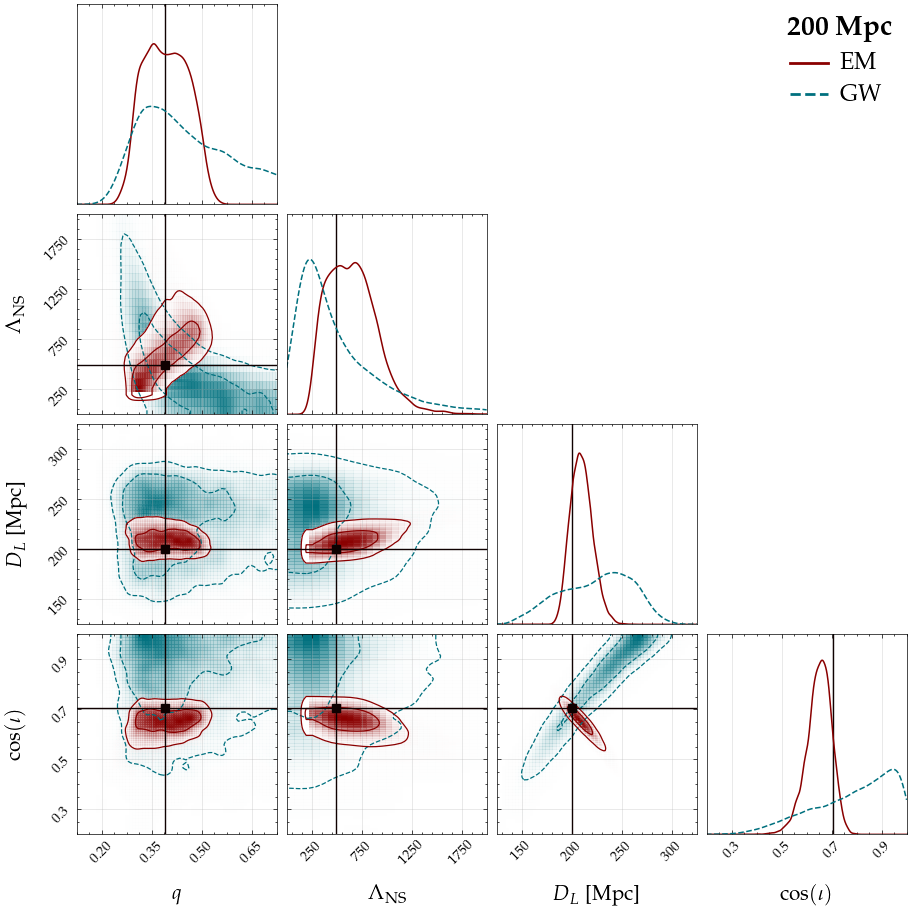

In [33]:
"""
Figure 6.6: Comparison between the different samplers.


The 1D and 2D posterior probability distributions for the component masses of the
source binary of GW230529 along with other NSBH and BNS events.

"""

#fig, axes = plt.subplots(figsize=(12, 7.4 / 2), ncols=2, nrows=1)

# load data

label_key = ['em', 'gw']
results_list = [bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_2/200_Mpc/em_run', label='em'),
                bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_2/200_Mpc/gw_run', label='gw')]
COLORS_RUNS = {'em'               : COLORS_DICT['darkred'],
               'gw'               : COLORS_DICT['teal']}

LINESTYLE_RUNS = {'em'        : '-',
                  'gw'     : '--'}

direction  = "in"
smoothing  = 1.8
nbins      = 60

posteriors = ['mass_ratio', 'lambda_2', 'luminosity_distance', 'cos_theta_jn']
param_labels = [r'$q$', r'$\Lambda_{\rm NS}$', r'$D_L$ [Mpc]', r'$\cos(\iota)$']
truth_values = [0.39, 490.32033763361954, 200, 0.707]

fig = corner.corner(
    np.array([results_list[1].posterior[key] for key in posteriors]).T,
    bins            = nbins,
    labels          = param_labels,
    fill_contours   = False,
    plot_datapoints = False,
    color           = COLORS_RUNS['gw'],
    smooth          = smoothing,
    levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
    plot_kwargs     = dict(linestyle = "-"),
    hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
    contour_kwargs  = dict(linestyles=LINESTYLE_RUNS['gw'], linewidths=[LINEWIDTHS["curve"]]),
    plot_density    = True,
)

corner.corner(
    np.array([results_list[0].posterior[key] for key in posteriors]).T,
    fig             = fig,
    bins            = nbins,
    labels          = param_labels,
    fill_contours   = False,
    plot_datapoints = False,
    color           = COLORS_RUNS['em'],
    smooth          = smoothing,
    truths          = truth_values,
    truth_color     = COLORS_DICT["black"],
    levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
    plot_kwargs     = dict(linestyle = "-"),
    hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
    contour_kwargs  = dict(linestyles=LINESTYLE_RUNS['em'], linewidths=[LINEWIDTHS["curve"]]),
    plot_density    = True,
    labelpad        = -0.05,
)

# Evaluate KDE
kde_mass_ratio              = [gaussian_kde(results_list[i].posterior["mass_ratio"].to_numpy()) for i in range(len(results_list))]
kde_lambda_2                = [gaussian_kde(results_list[i].posterior["lambda_2"].to_numpy()) for i in range(len(results_list))]
kde_luminosity_distance     = [gaussian_kde(results_list[i].posterior["luminosity_distance"].to_numpy()) for i in range(len(results_list))]
kde_cos_theta_jn            = [gaussian_kde(results_list[i].posterior["cos_theta_jn"].to_numpy()) for i in range(len(results_list))]

kdes = [kde_mass_ratio, kde_lambda_2, kde_luminosity_distance, kde_cos_theta_jn]
kdes_ranges = [np.linspace(0.1, 1, 1000), np.linspace(0, 3500, 3000), 
               np.linspace(100, 350, 1000), np.linspace(0.1, 1, 1000)]

mass_ratio_ticks            = [0.2, 0.35, 0.5, 0.65]
lambda_2_ticks              = [250, 750, 1250, 1750]
luminosity_distance_ticks   = [150, 200, 250, 300]
cos_theta_jn_ticks          = [0.3, 0.5, 0.7, 0.9]

for j, axes in enumerate([0, 5, 10, 15]):
    for i, label in enumerate(label_key):
        fig.get_axes()[axes].plot(kdes_ranges[j], kdes[j][i](kdes_ranges[j]), color=COLORS_RUNS[label], linestyle=LINESTYLE_RUNS[label], linewidth=1.1)

# mass_ratio 1D-distribution
fig.get_axes()[0].set_xticks(mass_ratio_ticks)

# mass_ratio-lambda_2 2D distribution
fig.get_axes()[4].set_xticks(mass_ratio_ticks)
fig.get_axes()[4].set_yticks(lambda_2_ticks)

# lambda_2 1D distribution
fig.get_axes()[5].set_xticks(lambda_2_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[8].set_xticks(mass_ratio_ticks)
fig.get_axes()[8].set_yticks(luminosity_distance_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[9].set_xticks(lambda_2_ticks)
fig.get_axes()[9].set_yticks(luminosity_distance_ticks)

# mwind 1D distribution
fig.get_axes()[10].set_xticks(luminosity_distance_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[12].set_xticks(mass_ratio_ticks)
fig.get_axes()[12].set_yticks(cos_theta_jn_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[13].set_xticks(lambda_2_ticks)
fig.get_axes()[13].set_yticks(cos_theta_jn_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[14].set_xticks(luminosity_distance_ticks)
fig.get_axes()[14].set_yticks(cos_theta_jn_ticks)

# mwind 1D distribution
fig.get_axes()[15].set_xticks(cos_theta_jn_ticks)

# Tune x and y limits
mass_ratio_min, mass_ratio_max                       = 0.2 - 0.075, 0.65 + 0.075
lambda_2_min, lambda_2_max                           = 0, 2000
luminosity_distance_min, luminosity_distance_max     = 125, 325
cos_theta_jn_min, cos_theta_jn_max                   = 0.2, 1
# mwind_min, mwind_max        =  0.016, 0.024

# mass_ratio 1D-distribution
fig.get_axes()[0].set_xlim((mass_ratio_min, mass_ratio_max))

# mass_ratio-lambda_2 2D distribution
fig.get_axes()[4].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[4].set_ylim((lambda_2_min, lambda_2_max))

# lambda_2 1D distribution
fig.get_axes()[5].set_xlim((lambda_2_min, lambda_2_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[8].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[8].set_ylim((luminosity_distance_min, luminosity_distance_max))

# vdyn-mwind 2D distribution
fig.get_axes()[9].set_xlim((lambda_2_min, lambda_2_max))
fig.get_axes()[9].set_ylim((luminosity_distance_min, luminosity_distance_max))

# mwind 1D distribution
fig.get_axes()[10].set_xlim((luminosity_distance_min, luminosity_distance_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[12].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[12].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[13].set_xlim((lambda_2_min, lambda_2_max))
fig.get_axes()[13].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# vdyn-mwind 2D distribution
fig.get_axes()[14].set_xlim((luminosity_distance_min, luminosity_distance_max))
fig.get_axes()[14].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# mwind 1D distribution
fig.get_axes()[15].set_xlim((cos_theta_jn_min, cos_theta_jn_max))

# add the legend to the plot
handles = [Line2D([], [], color=COLORS_DICT["darkred"], ls="-"), 
           Line2D([], [], color=COLORS_DICT["teal"], ls="--")]

labels = ['EM', 'GW']
legend = plt.legend(handles, labels, loc=(0.4, 3.62), fontsize=17)
for i in legend.legend_handles:
    i.set_linewidth(2)

plt.annotate(r"\textbf{200 Mpc}",
            xy=(0.4, 4), 
            xycoords='axes fraction',
            size=20,
            bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

fig.savefig(results_case_studies_dir + "case_study_2/corner_plot_comparison_distances_200Mpc.pdf")
fig.savefig(results_case_studies_dir + "case_study_2/corner_plot_comparison_distances_200Mpc.png")


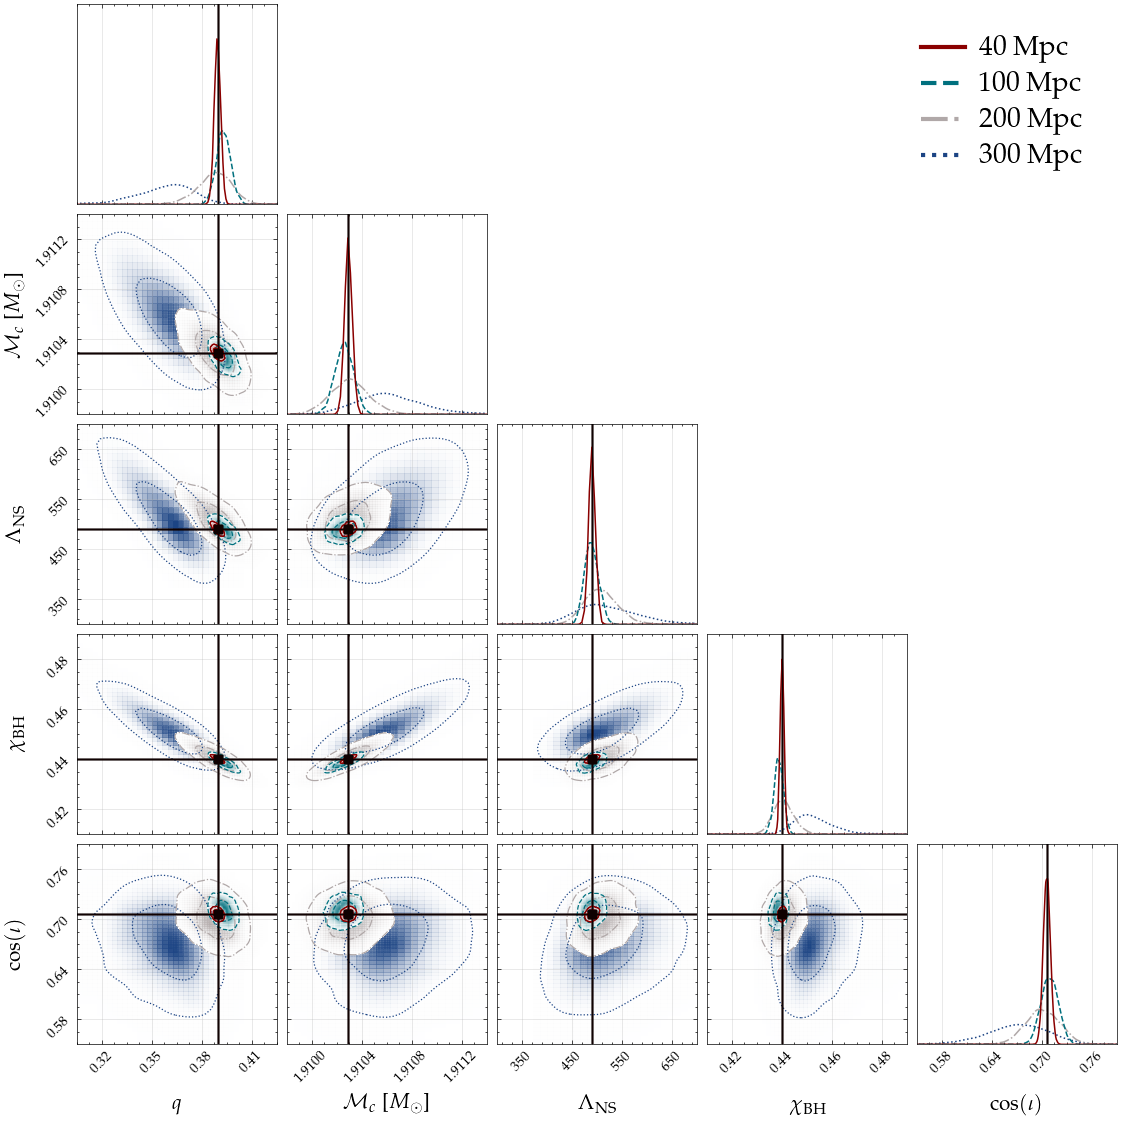

In [19]:
"""
Figure 6.6: Comparison between the different samplers.


The 1D and 2D posterior probability distributions for the component masses of the
source binary of GW230529 along with other NSBH and BNS events.

"""

# load data
label_key = ['300_Mpc', '200_Mpc', '100_Mpc', '40_Mpc']
results_list = [bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_2/{label}/combined_run/', label='em_gw') for i, label in enumerate(label_key)]
COLORS_RUNS = {'40_Mpc'      : COLORS_DICT['darkred'],
               '100_Mpc'     : COLORS_DICT['teal'],
               '200_Mpc'     : COLORS_DICT['gray'],
               '300_Mpc'     : COLORS_DICT['navy']}

LINESTYLE_RUNS = {'40_Mpc'      : '-',
                  '100_Mpc'     : '--',
                  '200_Mpc'     : '-.',
                  '300_Mpc'     : ':'}

direction  = "in"
smoothing  = 1.8
nbins      = 60

posteriors = ['mass_ratio', 'chirp_mass', 'lambda_2', 'chi_1', 'cos_theta_jn']
param_labels = [r'$q$', r'$\mathcal{M}_c$ [$M_\odot$]', r'$\Lambda_{\rm NS}$', r'$\chi_{\rm BH}$', r'$\cos(\iota)$']
truth_values = [0.39, 1.9102896946252306, 490.32033763361954, 0.44, 0.707]

for i, label in enumerate(label_key):

    if i == 0:
        fig = corner.corner(
            np.array([results_list[i].posterior[key] for key in posteriors]).T,
            bins            = nbins,
            labels          = param_labels,
            fill_contours   = False,
            plot_datapoints = False,
            color           = COLORS_RUNS[label],
            smooth          = smoothing,
            levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
            plot_kwargs     = dict(linestyle = LINESTYLE_RUNS[label]),
            hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
            contour_kwargs  = dict(linestyles=LINESTYLE_RUNS[label], linewidths=[LINEWIDTHS["curve"]]),
            plot_density    = True,
        )

    else:

        corner.corner(
            np.array([results_list[i].posterior[key] for key in posteriors]).T,
            fig             = fig,
            bins            = nbins,
            labels          = param_labels,
            fill_contours   = False,
            plot_datapoints = False,
            color           = COLORS_RUNS[label],
            smooth          = smoothing,
            truths          = truth_values,
            truth_color     = COLORS_DICT["black"],
            levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
            plot_kwargs     = dict(linestyle = "-"),
            hist_kwargs     = {"density": True, "linestyle": '-', "linewidth": 0.0},
            contour_kwargs  = dict(linestyles=LINESTYLE_RUNS[label], linewidths=[LINEWIDTHS["curve"]]),
            plot_density    = True,
            labelpad        = -0.05,
        )

# Evaluate KDE
kde_mass_ratio              = [gaussian_kde(results_list[i].posterior["mass_ratio"].to_numpy()) for i in range(len(results_list))]
kde_chirp_mass              = [gaussian_kde(results_list[i].posterior["chirp_mass"].to_numpy()) for i in range(len(results_list))]
kde_lambda_2                = [gaussian_kde(results_list[i].posterior["lambda_2"].to_numpy()) for i in range(len(results_list))]
kde_chi_1                   = [gaussian_kde(results_list[i].posterior["chi_1"].to_numpy()) for i in range(len(results_list))]
kde_cos_theta_jn            = [gaussian_kde(results_list[i].posterior["cos_theta_jn"].to_numpy()) for i in range(len(results_list))]

kdes = [kde_mass_ratio, kde_chirp_mass, kde_lambda_2, kde_chi_1, kde_cos_theta_jn]
kdes_ranges = [np.linspace(0.1, 1, 1000), np.linspace(1.90, 1.92, 1000), np.linspace(0, 5000, 1000), 
               np.linspace(0.3, 0.6, 1000), np.linspace(0.3, 1, 1000)]

mass_ratio_ticks            = [0.32, 0.35, 0.38, 0.41]
chirp_mass_ticks            = [1.9100, 1.9104, 1.9108, 1.9112]
lambda_2_ticks              = [350, 450, 550, 650]
chi_1_ticks                 = [0.42, 0.44, 0.46, 0.48]
cos_theta_jn_ticks          = [0.58, 0.64, 0.70, 0.76]

# xticks = [mdyn_ticks, vdyn_ticks, mwind_ticks]

for j, axes in enumerate([0, 6, 12, 18, 24]):
    for i, label in enumerate(label_key):
        fig.get_axes()[axes].plot(kdes_ranges[j], kdes[j][i](kdes_ranges[j]), color=COLORS_RUNS[label], linestyle=LINESTYLE_RUNS[label], linewidth=1.1)

corner.corner(
            np.array([results_list[i].posterior[key] for key in posteriors]).T,
            fig             = fig,
            bins            = nbins,
            labels          = param_labels,
            fill_contours   = False,
            plot_datapoints = False,
            color           = COLORS_RUNS[label],
            smooth          = smoothing,
            truths          = truth_values,
            truth_color     = COLORS_DICT["black"],
            levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
            plot_kwargs     = dict(linestyle = "-"),
            hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
            contour_kwargs  = dict(linestyles=LINESTYLE_RUNS[label], linewidths=[LINEWIDTHS["curve"]]),
            plot_density    = True,
            labelpad        = -0.05,
        )

# mass_ratio 1D-distribution
fig.get_axes()[0].set_xticks(mass_ratio_ticks)

# mass_ratio-lambda_2 2D distribution
fig.get_axes()[5].set_xticks(mass_ratio_ticks)
fig.get_axes()[5].set_yticks(chirp_mass_ticks)

# lambda_2 1D distribution
fig.get_axes()[6].set_xticks(chirp_mass_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[10].set_xticks(mass_ratio_ticks)
fig.get_axes()[10].set_yticks(lambda_2_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[11].set_xticks(chirp_mass_ticks)
fig.get_axes()[11].set_yticks(lambda_2_ticks)

# mwind 1D distribution
fig.get_axes()[12].set_xticks(lambda_2_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[15].set_xticks(mass_ratio_ticks)
fig.get_axes()[15].set_yticks(chi_1_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[16].set_xticks(chirp_mass_ticks)
fig.get_axes()[16].set_yticks(chi_1_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[17].set_xticks(lambda_2_ticks)
fig.get_axes()[17].set_yticks(chi_1_ticks)

# mwind 1D distribution
fig.get_axes()[18].set_xticks(chi_1_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[20].set_xticks(mass_ratio_ticks)
fig.get_axes()[20].set_yticks(cos_theta_jn_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[21].set_xticks(chirp_mass_ticks)
fig.get_axes()[21].set_yticks(cos_theta_jn_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[22].set_xticks(lambda_2_ticks)
fig.get_axes()[22].set_yticks(cos_theta_jn_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[23].set_xticks(chi_1_ticks)
fig.get_axes()[23].set_yticks(cos_theta_jn_ticks)

# mwind 1D distribution
fig.get_axes()[24].set_xticks(cos_theta_jn_ticks)

# Tune x and y limits
mass_ratio_min, mass_ratio_max                       = 0.305, 0.425
chirp_mass_min, chirp_mass_max                       = 1.9100 - 0.0002, 1.9114
lambda_2_min, lambda_2_max                           = 300, 700
chi_1_min, chi_1_max                                 = 0.41, 0.49
cos_theta_jn_min, cos_theta_jn_max                   = 0.55, 0.79

# mass_ratio 1D-distribution
fig.get_axes()[0].set_xlim((mass_ratio_min, mass_ratio_max))

# mass_ratio-lambda_2 2D distribution
fig.get_axes()[5].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[5].set_ylim((chirp_mass_min, chirp_mass_max))

# lambda_2 1D distribution
fig.get_axes()[6].set_xlim((chirp_mass_min, chirp_mass_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[10].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[10].set_ylim((lambda_2_min, lambda_2_max))

# vdyn-mwind 2D distribution
fig.get_axes()[11].set_xlim((chirp_mass_min, chirp_mass_max))
fig.get_axes()[11].set_ylim((lambda_2_min, lambda_2_max))

# mwind 1D distribution
fig.get_axes()[12].set_xlim((lambda_2_min, lambda_2_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[15].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[15].set_ylim((chi_1_min, chi_1_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[16].set_xlim((chirp_mass_min, chirp_mass_max))
fig.get_axes()[16].set_ylim((chi_1_min, chi_1_max))

# vdyn-mwind 2D distribution
fig.get_axes()[17].set_xlim((lambda_2_min, lambda_2_max))
fig.get_axes()[17].set_ylim((chi_1_min, chi_1_max))

# mwind 1D distribution
fig.get_axes()[18].set_xlim((chi_1_min, chi_1_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[20].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[20].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[21].set_xlim((chirp_mass_min, chirp_mass_max))
fig.get_axes()[21].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[22].set_xlim((lambda_2_min, lambda_2_max))
fig.get_axes()[22].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# vdyn-mwind 2D distribution
fig.get_axes()[23].set_xlim((chi_1_min, chi_1_max))
fig.get_axes()[23].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# mwind 1D distribution
fig.get_axes()[24].set_xlim((cos_theta_jn_min, cos_theta_jn_max))

# add the legend to the plot
handles = [Line2D([], [], color=COLORS_DICT["darkred"], ls=LINESTYLE_RUNS['40_Mpc']), 
           Line2D([], [], color=COLORS_DICT["teal"], ls=LINESTYLE_RUNS['100_Mpc']),
           Line2D([], [], color=COLORS_DICT["gray"], ls=LINESTYLE_RUNS['200_Mpc']),
           Line2D([], [], color=COLORS_DICT["navy"], ls=LINESTYLE_RUNS['300_Mpc'])]

labels = [r'40 Mpc', r'100 Mpc', r'200 Mpc', r'300 Mpc']
legend = plt.legend(handles, labels, loc=(0, 4.35), fontsize=20)
for i in legend.legend_handles:
    i.set_linewidth(3)

fig.savefig(results_case_studies_dir + "case_study_2/corner_plot_combined.pdf")
fig.savefig(results_case_studies_dir + "case_study_2/corner_plot_combined.png")

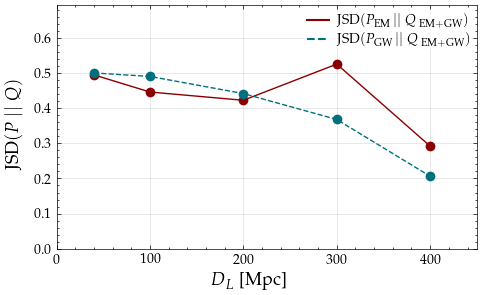

In [27]:

fig, ax = plt.subplots(figsize=FIG_SIZES["rectangle_plot"])

folder_key = ['em_run', 'gw_run', 'combined_run']
distances = ['40_Mpc', '100_Mpc', '200_Mpc', '300_Mpc', '400_Mpc']
label_key = ['em', 'gw', 'em_gw']

results_dict = {distance: {label: bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_2/{distance}/{folder_key[i]}', label=label) 
                   for i, label in enumerate(label_key)} for distance in distances}

def calculate_jsd(results_1, results_2, posterior_keys):
    total_jsd = 0

    def fit_1(x):
            return max(1e-6, kde_1(x))

    def fit_2(x):
        return max(1e-6, kde_2(x))

    for key in posterior_keys:

        posterior_1 = results_1.posterior[key]
        posterior_2 = results_2.posterior[key]

        min_value = np.min([min(posterior_1), min(posterior_2)])
        max_value = np.max([max(posterior_1), max(posterior_2)])

        kde_range = np.linspace(min_value, max_value, 1000)

        kde_1 = gaussian_kde(posterior_1.to_numpy())
        kde_2 = gaussian_kde(posterior_2.to_numpy())

        def fit_1(x):
            return max(1e-6, kde_1(x))

        def fit_2(x):
            return max(1e-6, kde_2(x))

        fit_1 = np.vectorize(fit_1)
        fit_2 = np.vectorize(fit_2)

        total_jsd = total_jsd + jensenshannon(fit_1(kde_range), fit_2(kde_range))**2
    
    return total_jsd / len(posterior_keys)

# gw_jsd = [calculate_jsd(results_dict[distance]['gw'], results_dict[distance]['em_gw'], 
#                         ['mass_ratio', 'lambda_2', 'luminosity_distance', 'cos_theta_jn', 'chirp_mass', 'chi_1']) for distance in distances]

# em_jsd = [calculate_jsd(results_dict[distance]['em'], results_dict[distance]['em_gw'], 
#                         ['mass_ratio', 'lambda_2', 'luminosity_distance', 'cos_theta_jn', 'chirp_mass', 'chi_1']) for distance in distances]

ax.plot([40, 100, 200, 300, 400], em_jsd, '-',color=COLORS_DICT['darkred'])
ax.plot([40, 100, 200, 300, 400], em_jsd, 'o',color=COLORS_DICT['darkred'])
ax.plot([40, 100, 200, 300, 400], gw_jsd, '--',color=COLORS_DICT['teal'])
ax.plot([40, 100, 200, 300, 400], gw_jsd, 'o',color=COLORS_DICT['teal'])

fig.supxlabel("$D_L$ [Mpc]", x=0.48, y=-0.02, fontsize=13)
fig.supylabel(r"JSD$(P\text{ }||\text{ }Q)$", y=0.5, x=0.03, fontsize=13)

handles = [Line2D([], [], color=COLORS_DICT["darkred"], ls="-"), Line2D([], [], color=COLORS_DICT["teal"], ls="--"),]
labels = [r"JSD$(P_\text{EM }||\text{ }Q_{\text{ EM}+\text{GW}})$", r"JSD$(P_\text{GW }||\text{ }Q_{\text{ EM}+\text{GW}})$"]
legend = plt.legend(handles, labels, loc=(0.59, 0.82))
for i in legend.legend_handles:
    i.set_linewidth(1.5)

ax.set_xlim(0, 450)
ax.set_ylim(0, np.log(2))
ax.set_xticks([0, 100, 200, 300, 400])

fig.savefig(results_case_studies_dir + "case_study_2/jsd_distances.pdf")
fig.savefig(results_case_studies_dir + "case_study_2/jsd_distances.png")

<__array_function__ internals>:200: UserWarning: Warning: converting a masked element to nan.
/home/smelfor/anaconda3/envs/plotting_env/lib/python3.8/site-packages/matplotlib/colors.py:1311: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


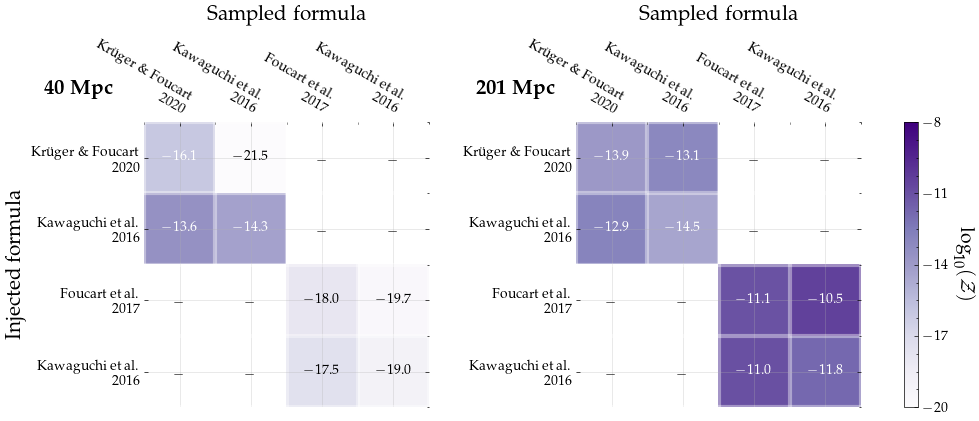

In [36]:
"""
Figure 6.6: Comparison between the different samplers.


The 1D and 2D posterior probability distributions for the component masses of the
source binary of GW230529 along with other NSBH and BNS events.

"""

fig, axes = plt.subplots(figsize=(11, 7.4 / 2), ncols=2, nrows=1)

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current Axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    #cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    #cbar.ax.set_ylabel(cbarlabel, rotation=270, fontsize=12, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)
    
    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(f'${valfmt}$')

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            
            if isinstance(data[i,j], np.ma.MaskedArray):
                text = im.axes.text(j, i, '$-$', **kw)

            else:
                text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts


def calculate_bayes_factors(result_1, result_2):
    log_bayes_factor = result_1.log_evidence - result_2.log_evidence
    log10_bayes_factor = log_bayes_factor / np.log(10)
    return 10**log10_bayes_factor


# load data
samplers_key = ['dynamical_mass_kawaguchi_kawaguchi', 'dynamical_mass_kawaguchi_kruger', 'dynamical_mass_kruger_kruger', 'dynamical_mass_kruger_kawaguchi',
                'dynamical_velocity_foucart_foucart', 'dynamical_velocity_foucart_kawaguchi', 'dynamical_velocity_kawaguchi_kawaguchi', 'dynamical_velocity_kawaguchi_foucart']

results_201Mpc_dict = {formulae: bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_3/201Mpc/{formulae}/em_run_gw_parameters', label=f'em') for formulae in samplers_key}
results_40Mpc_dict = {formulae: bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_3/40Mpc/{formulae}/em_run_gw_parameters', label=f'em') for formulae in samplers_key}

log_10_evidence_201Mpc_array = np.array([[results_201Mpc_dict['dynamical_mass_kruger_kruger'].log_10_evidence, results_201Mpc_dict['dynamical_mass_kruger_kawaguchi'].log_10_evidence, np.nan, np.nan],
                                [results_201Mpc_dict['dynamical_mass_kawaguchi_kruger'].log_10_evidence, results_201Mpc_dict['dynamical_mass_kawaguchi_kawaguchi'].log_10_evidence, np.nan, np.nan],
                                [np.nan, np.nan, results_201Mpc_dict['dynamical_velocity_foucart_foucart'].log_10_evidence, results_201Mpc_dict['dynamical_velocity_foucart_kawaguchi'].log_10_evidence],
                                [np.nan, np.nan, results_201Mpc_dict['dynamical_velocity_kawaguchi_kawaguchi'].log_10_evidence, results_201Mpc_dict['dynamical_velocity_kawaguchi_foucart'].log_10_evidence]])

log_10_evidence_40Mpc_array = np.array([[results_40Mpc_dict['dynamical_mass_kruger_kruger'].log_10_evidence, results_40Mpc_dict['dynamical_mass_kruger_kawaguchi'].log_10_evidence, np.nan, np.nan],
                                [results_40Mpc_dict['dynamical_mass_kawaguchi_kruger'].log_10_evidence, results_40Mpc_dict['dynamical_mass_kawaguchi_kawaguchi'].log_10_evidence, np.nan, np.nan],
                                [np.nan, np.nan, results_40Mpc_dict['dynamical_velocity_foucart_foucart'].log_10_evidence, results_40Mpc_dict['dynamical_velocity_foucart_kawaguchi'].log_10_evidence],
                                [np.nan, np.nan, results_40Mpc_dict['dynamical_velocity_kawaguchi_kawaguchi'].log_10_evidence, results_40Mpc_dict['dynamical_velocity_kawaguchi_foucart'].log_10_evidence]])


labels = ['Krüger \& Foucart\n 2020', 'Kawaguchi et al.\n 2016', 'Foucart et al.\n 2017', 'Kawaguchi et al.\n 2016']

im = heatmap(log_10_evidence_40Mpc_array, labels, labels, ax=axes[0], cmap=plt.cm.Purples, cbarlabel=r'$\log_{10}(\mathcal{Z})$', 
                   norm=matplotlib.colors.Normalize(vmin=-20, vmax=-8), cbar_kw={'ticks': [-20, -15, -13, -11, -9]})
texts = annotate_heatmap(im, valfmt="{x:.1f}")

im = heatmap(log_10_evidence_201Mpc_array, labels, labels, ax=axes[1], cmap=plt.cm.Purples, cbarlabel=r'$\log_{10}(\mathcal{Z})$', 
                   norm=matplotlib.colors.Normalize(vmin=-20, vmax=-8), cbar_kw={'ticks': [-17, -15, -13, -11, -9]})
texts = annotate_heatmap(im, valfmt="{x:.1f}")

colorbar = fig.colorbar(im,  ax=[axes[0], axes[1]], fraction=0.021, ticks=[-20, -17, -14, -11, -8])
colorbar.ax.set_ylabel(ylabel=r'$\log_{10}(\mathcal{Z})$', rotation=270, fontsize=14, va="bottom")

axes[0].annotate(r"\textbf{40 Mpc}",
            xy=(-0.35, 1.1), 
            xycoords='axes fraction',
            size=15,
            bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

axes[0].set_xlabel("Sampled formula", fontsize=15, labelpad=13)
axes[0].xaxis.set_ticks_position('top')
axes[0].xaxis.set_label_position('top')
axes[0].set_ylabel("Injected formula", fontsize=15)

axes[1].annotate(r"\textbf{201 Mpc}",
            xy=(-0.35, 1.1), 
            xycoords='axes fraction',
            size=15,
            bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

axes[1].set_xlabel("Sampled formula", fontsize=15, labelpad=13)
axes[1].xaxis.set_ticks_position('top')
axes[1].xaxis.set_label_position('top')

fig.savefig(results_case_studies_dir + "case_study_3/evidence.pdf")
fig.savefig(results_case_studies_dir + "case_study_3/evidence.png")

<__array_function__ internals>:200: UserWarning: Warning: converting a masked element to nan.
/home/smelfor/anaconda3/envs/plotting_env/lib/python3.8/site-packages/matplotlib/colors.py:1311: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


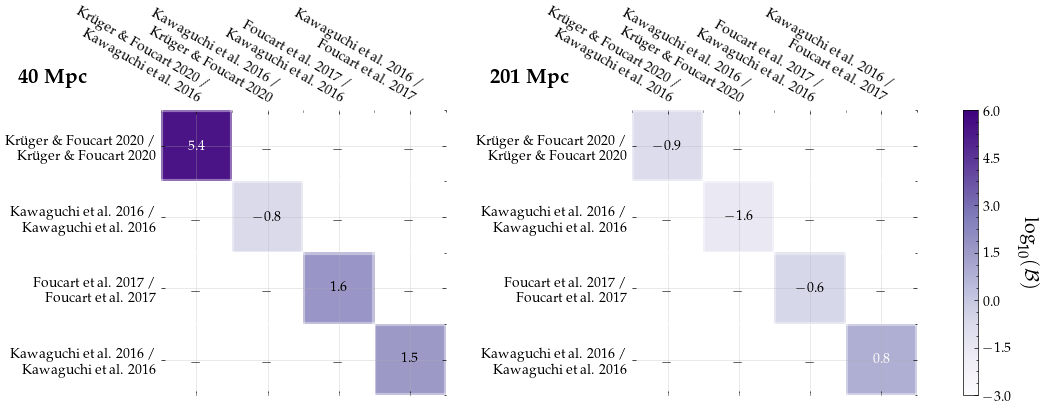

In [38]:
def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/1.1

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)
    
    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(f'${valfmt}$')

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            
            if isinstance(data[i,j], np.ma.MaskedArray):
                text = im.axes.text(j, i, '$-$', **kw)

            else:
                text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

fig, axes = plt.subplots(figsize=(12, 7.4 / 2), ncols=2, nrows=1)

log_10_bf_201Mpc_array = np.array([[results_201Mpc_dict['dynamical_mass_kruger_kruger'].log_10_evidence - results_201Mpc_dict['dynamical_mass_kruger_kawaguchi'].log_10_evidence, np.nan, np.nan, np.nan],
                            [np.nan, results_201Mpc_dict['dynamical_mass_kawaguchi_kawaguchi'].log_10_evidence - results_201Mpc_dict['dynamical_mass_kawaguchi_kruger'].log_10_evidence, np.nan,  np.nan],
                            [np.nan, np.nan, results_201Mpc_dict['dynamical_velocity_foucart_foucart'].log_10_evidence - results_201Mpc_dict['dynamical_velocity_foucart_kawaguchi'].log_10_evidence, np.nan],
                            [np.nan, np.nan, np.nan, results_201Mpc_dict['dynamical_velocity_kawaguchi_kawaguchi'].log_10_evidence - results_201Mpc_dict['dynamical_velocity_kawaguchi_foucart'].log_10_evidence]])

log_10_bf_40Mpc_array = np.array([[results_40Mpc_dict['dynamical_mass_kruger_kruger'].log_10_evidence - results_40Mpc_dict['dynamical_mass_kruger_kawaguchi'].log_10_evidence, np.nan, np.nan, np.nan],
                            [np.nan, results_40Mpc_dict['dynamical_mass_kawaguchi_kawaguchi'].log_10_evidence - results_40Mpc_dict['dynamical_mass_kawaguchi_kruger'].log_10_evidence, np.nan,  np.nan],
                            [np.nan, np.nan, results_40Mpc_dict['dynamical_velocity_foucart_foucart'].log_10_evidence - results_40Mpc_dict['dynamical_velocity_foucart_kawaguchi'].log_10_evidence, np.nan],
                            [np.nan, np.nan, np.nan, results_40Mpc_dict['dynamical_velocity_kawaguchi_kawaguchi'].log_10_evidence - results_40Mpc_dict['dynamical_velocity_kawaguchi_foucart'].log_10_evidence]])


xlabels = ['Krüger \& Foucart 2020 /\n Krüger \& Foucart 2020', 'Kawaguchi et al. 2016 /\n Kawaguchi et al. 2016', 
           'Foucart et al. 2017 /\n Foucart et al. 2017', 'Kawaguchi et al. 2016 /\n Kawaguchi et al. 2016']
ylabels = ['Krüger \& Foucart 2020 /\n Kawaguchi et al. 2016', 'Kawaguchi et al. 2016 / \n Krüger \& Foucart 2020', 
           'Foucart et al. 2017 /\n Kawaguchi et al. 2016', 'Kawaguchi et al. 2016 /\n Foucart et al. 2017']

im = heatmap(log_10_bf_40Mpc_array, xlabels, ylabels, ax=axes[0], cmap=plt.cm.Purples, cbarlabel=r'$\log_{10}(\mathcal{B})$',
             norm=matplotlib.colors.Normalize(vmin=-3, vmax=6))
texts = annotate_heatmap(im, valfmt="{x:.1f}")

im= heatmap(log_10_bf_201Mpc_array, xlabels, ylabels, ax=axes[1], cmap=plt.cm.Purples, cbarlabel=r'$\log_{10}(\mathcal{B})$',
            norm=matplotlib.colors.Normalize(vmin=-3, vmax=6))
texts = annotate_heatmap(im, valfmt="{x:.1f}")

colorbar = fig.colorbar(im,  ax=[axes[0], axes[1]], fraction=0.021, ticks=[-3, -1.5, 0, 1.5, 3, 4.5, 6])
colorbar.ax.set_ylabel(ylabel=r'$\log_{10}(\mathcal{B})$', rotation=270, fontsize=14, va="bottom")

axes[0].annotate(r"\textbf{40 Mpc}",
            xy=(-0.5, 1.1), 
            xycoords='axes fraction',
            size=15,
            bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))


axes[1].annotate(r"\textbf{201 Mpc}",
            xy=(-0.5, 1.1), 
            xycoords='axes fraction',
            size=15,
            bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

fig.savefig(results_case_studies_dir + "case_study_3/bayes_factors.pdf")
fig.savefig(results_case_studies_dir + "case_study_3/bayes_factors.png")

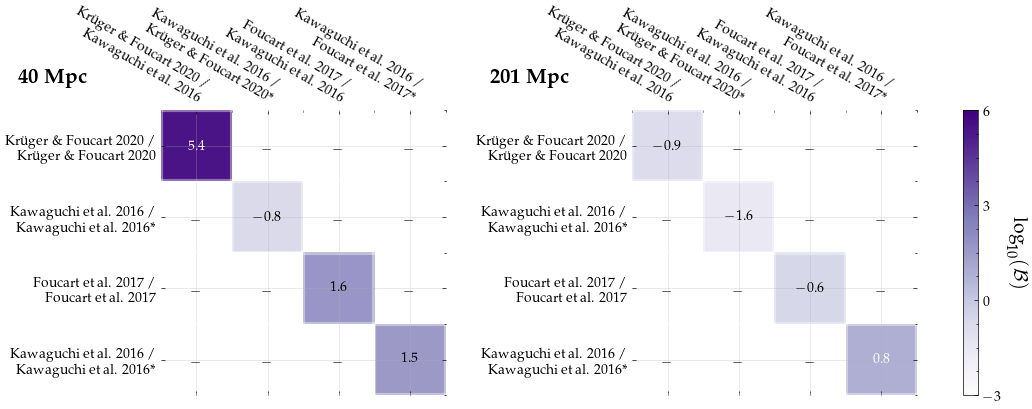

In [40]:
def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/1.1

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)
    
    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(f'${valfmt}$')

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            
            if isinstance(data[i,j], np.ma.MaskedArray):
                text = im.axes.text(j, i, '$-$', **kw)

            else:
                text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

fig, axes = plt.subplots(figsize=(12, 7.4 / 2), ncols=2, nrows=1)

log_10_bf_201Mpc_array = np.array([[results_201Mpc_dict['dynamical_mass_kruger_kruger'].log_10_evidence - results_201Mpc_dict['dynamical_mass_kruger_kawaguchi'].log_10_evidence, np.nan, np.nan, np.nan],
                            [np.nan, results_201Mpc_dict['dynamical_mass_kawaguchi_kawaguchi'].log_10_evidence - results_201Mpc_dict['dynamical_mass_kawaguchi_kruger'].log_10_evidence, np.nan,  np.nan],
                            [np.nan, np.nan, results_201Mpc_dict['dynamical_velocity_foucart_foucart'].log_10_evidence - results_201Mpc_dict['dynamical_velocity_foucart_kawaguchi'].log_10_evidence, np.nan],
                            [np.nan, np.nan, np.nan, results_201Mpc_dict['dynamical_velocity_kawaguchi_kawaguchi'].log_10_evidence - results_201Mpc_dict['dynamical_velocity_kawaguchi_foucart'].log_10_evidence]])

log_10_bf_40Mpc_array = np.array([[results_40Mpc_dict['dynamical_mass_kruger_kruger'].log_10_evidence - results_40Mpc_dict['dynamical_mass_kruger_kawaguchi'].log_10_evidence, np.nan, np.nan, np.nan],
                            [np.nan, results_40Mpc_dict['dynamical_mass_kawaguchi_kawaguchi'].log_10_evidence - results_40Mpc_dict['dynamical_mass_kawaguchi_kruger'].log_10_evidence, np.nan,  np.nan],
                            [np.nan, np.nan, results_40Mpc_dict['dynamical_velocity_foucart_foucart'].log_10_evidence - results_40Mpc_dict['dynamical_velocity_foucart_kawaguchi'].log_10_evidence, np.nan],
                            [np.nan, np.nan, np.nan, results_40Mpc_dict['dynamical_velocity_kawaguchi_kawaguchi'].log_10_evidence - results_40Mpc_dict['dynamical_velocity_kawaguchi_foucart'].log_10_evidence]])


xlabels = ['Krüger \& Foucart 2020 /\n Krüger \& Foucart 2020', 'Kawaguchi et al. 2016 /\n Kawaguchi et al. 2016*', 
           'Foucart et al. 2017 /\n Foucart et al. 2017', 'Kawaguchi et al. 2016 /\n Kawaguchi et al. 2016*']
ylabels = ['Krüger \& Foucart 2020 /\n Kawaguchi et al. 2016', 'Kawaguchi et al. 2016 / \n Krüger \& Foucart 2020*', 
           'Foucart et al. 2017 /\n Kawaguchi et al. 2016', 'Kawaguchi et al. 2016 /\n Foucart et al. 2017*']

im = heatmap(log_10_bf_40Mpc_array, xlabels, ylabels, ax=axes[0], cmap=plt.cm.Purples, cbarlabel=r'$\log_{10}(\mathcal{B})$',
             norm=matplotlib.colors.Normalize(vmin=-3, vmax=6))
texts = annotate_heatmap(im, valfmt="{x:.1f}")

im= heatmap(log_10_bf_201Mpc_array, xlabels, ylabels, ax=axes[1], cmap=plt.cm.Purples, cbarlabel=r'$\log_{10}(\mathcal{B})$',
            norm=matplotlib.colors.Normalize(vmin=-3, vmax=6))
texts = annotate_heatmap(im, valfmt="{x:.1f}")

colorbar = fig.colorbar(im,  ax=[axes[0], axes[1]], fraction=0.021, ticks=[-3, -1.5, 0, 1.5, 3, 4.5, 6])
colorbar.ax.set_ylabel(ylabel=r'$\log_{10}(\mathcal{B})$', rotation=270, fontsize=14, va="bottom")

axes[0].annotate(r"\textbf{40 Mpc}",
            xy=(-0.5, 1.1), 
            xycoords='axes fraction',
            size=15,
            bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))


axes[1].annotate(r"\textbf{201 Mpc}",
            xy=(-0.5, 1.1), 
            xycoords='axes fraction',
            size=15,
            bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

fig.savefig(results_case_studies_dir + "case_study_3/bayes_factors_modified.pdf")
fig.savefig(results_case_studies_dir + "case_study_3/bayes_factors_modified.png")

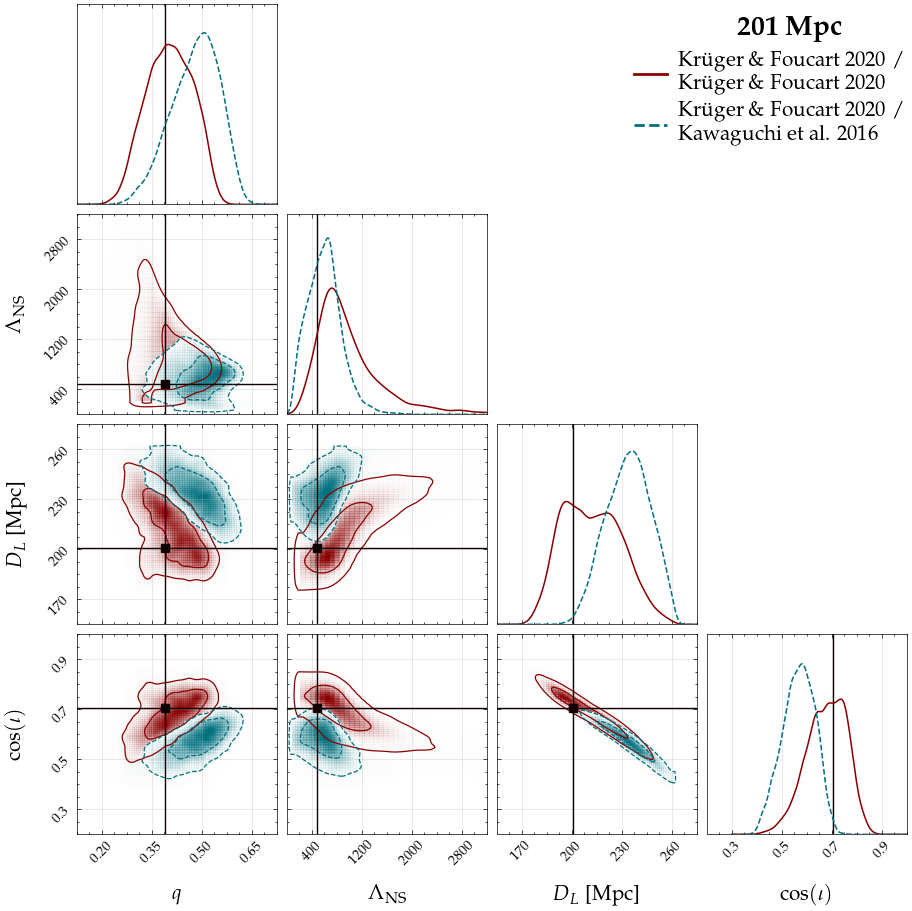

In [56]:
"""
Figure 6.6: Comparison between the different samplers.


The 1D and 2D posterior probability distributions for the component masses of the
source binary of GW230529 along with other NSBH and BNS events.

"""

#fig, axes = plt.subplots(figsize=(12, 7.4 / 2), ncols=2, nrows=1)

# load data

label_key = ['kruger_kruger', 'kruger_kawaguchi']
results_list = [bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_3/201Mpc/dynamical_mass_kruger_kruger/em_run_gw_parameters', 
                                                   label='em'),
                       bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_3/201Mpc/dynamical_mass_kruger_kawaguchi/em_run_gw_parameters', 
                                                   label='em')]
COLORS_RUNS = {'kruger_kruger'               : COLORS_DICT['darkred'],
               'kruger_kawaguchi'         : COLORS_DICT['teal']}

LINESTYLE_RUNS = {'kruger_kruger'        : '-',
                  'kruger_kawaguchi'     : '--'}

direction  = "in"
smoothing  = 1.8
nbins      = 60

posteriors = ['mass_ratio', 'lambda_2', 'luminosity_distance', 'cos_theta_jn']
param_labels = [r'$q$', r'$\Lambda_{\rm NS}$', r'$D_L$ [Mpc]', r'$\cos(\iota)$']
truth_values = [0.39, 490.32033763361954, 201, 0.707]

fig = corner.corner(
    np.array([results_list[0].posterior[key] for key in posteriors]).T,
    bins            = nbins,
    labels          = param_labels,
    fill_contours   = False,
    plot_datapoints = False,
    color           = COLORS_RUNS['kruger_kruger'],
    smooth          = smoothing,
    levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
    plot_kwargs     = dict(linestyle = "-"),
    hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
    contour_kwargs  = dict(linestyles=LINESTYLE_RUNS['kruger_kruger'], linewidths=[LINEWIDTHS["curve"]]),
    plot_density    = True,
)

corner.corner(
    np.array([results_list[1].posterior[key] for key in posteriors]).T,
    fig             = fig,
    bins            = nbins,
    labels          = param_labels,
    fill_contours   = False,
    plot_datapoints = False,
    color           = COLORS_RUNS['kruger_kawaguchi'],
    smooth          = smoothing,
    truths          = truth_values,
    truth_color     = COLORS_DICT["black"],
    levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
    plot_kwargs     = dict(linestyle = "-"),
    hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
    contour_kwargs  = dict(linestyles=LINESTYLE_RUNS['kruger_kawaguchi'], linewidths=[LINEWIDTHS["curve"]]),
    plot_density    = True,
    labelpad        = -0.05,
)

# Evaluate KDE
kde_mass_ratio              = [gaussian_kde(results_list[i].posterior["mass_ratio"].to_numpy()) for i in range(len(results_list))]
kde_lambda_2                = [gaussian_kde(results_list[i].posterior["lambda_2"].to_numpy()) for i in range(len(results_list))]
kde_luminosity_distance     = [gaussian_kde(results_list[i].posterior["luminosity_distance"].to_numpy()) for i in range(len(results_list))]
kde_cos_theta_jn            = [gaussian_kde(results_list[i].posterior["cos_theta_jn"].to_numpy()) for i in range(len(results_list))]

kdes = [kde_mass_ratio, kde_lambda_2, kde_luminosity_distance, kde_cos_theta_jn]
kdes_ranges = [np.linspace(0.1, 1, 1000), np.linspace(0, 3500, 3000), 
               np.linspace(120, 300, 1000), np.linspace(0.3, 1, 1000)]

mass_ratio_ticks            = [0.2, 0.35, 0.5, 0.65]
lambda_2_ticks              = [400, 1200, 2000, 2800]
luminosity_distance_ticks   = [170, 200, 230, 260]
cos_theta_jn_ticks          = [0.3, 0.5, 0.7, 0.9]

for j, axes in enumerate([0, 5, 10, 15]):
    for i, label in enumerate(label_key):
        fig.get_axes()[axes].plot(kdes_ranges[j], kdes[j][i](kdes_ranges[j]), color=COLORS_RUNS[label], linestyle=LINESTYLE_RUNS[label], linewidth=1.1)

# mass_ratio 1D-distribution
fig.get_axes()[0].set_xticks(mass_ratio_ticks)

# mass_ratio-lambda_2 2D distribution
fig.get_axes()[4].set_xticks(mass_ratio_ticks)
fig.get_axes()[4].set_yticks(lambda_2_ticks)

# lambda_2 1D distribution
fig.get_axes()[5].set_xticks(lambda_2_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[8].set_xticks(mass_ratio_ticks)
fig.get_axes()[8].set_yticks(luminosity_distance_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[9].set_xticks(lambda_2_ticks)
fig.get_axes()[9].set_yticks(luminosity_distance_ticks)

# mwind 1D distribution
fig.get_axes()[10].set_xticks(luminosity_distance_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[12].set_xticks(mass_ratio_ticks)
fig.get_axes()[12].set_yticks(cos_theta_jn_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[13].set_xticks(lambda_2_ticks)
fig.get_axes()[13].set_yticks(cos_theta_jn_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[14].set_xticks(luminosity_distance_ticks)
fig.get_axes()[14].set_yticks(cos_theta_jn_ticks)

# mwind 1D distribution
fig.get_axes()[15].set_xticks(cos_theta_jn_ticks)

# Tune x and y limits
mass_ratio_min, mass_ratio_max                       = 0.125, 0.725
lambda_2_min, lambda_2_max                           = 0, 3200
luminosity_distance_min, luminosity_distance_max     = 155, 275
cos_theta_jn_min, cos_theta_jn_max                   = 0.2, 1
# mwind_min, mwind_max        =  0.016, 0.024

# mass_ratio 1D-distribution
fig.get_axes()[0].set_xlim((mass_ratio_min, mass_ratio_max))

# mass_ratio-lambda_2 2D distribution
fig.get_axes()[4].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[4].set_ylim((lambda_2_min, lambda_2_max))

# lambda_2 1D distribution
fig.get_axes()[5].set_xlim((lambda_2_min, lambda_2_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[8].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[8].set_ylim((luminosity_distance_min, luminosity_distance_max))

# vdyn-mwind 2D distribution
fig.get_axes()[9].set_xlim((lambda_2_min, lambda_2_max))
fig.get_axes()[9].set_ylim((luminosity_distance_min, luminosity_distance_max))

# mwind 1D distribution
fig.get_axes()[10].set_xlim((luminosity_distance_min, luminosity_distance_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[12].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[12].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[13].set_xlim((lambda_2_min, lambda_2_max))
fig.get_axes()[13].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# vdyn-mwind 2D distribution
fig.get_axes()[14].set_xlim((luminosity_distance_min, luminosity_distance_max))
fig.get_axes()[14].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# mwind 1D distribution
fig.get_axes()[15].set_xlim((cos_theta_jn_min, cos_theta_jn_max))

# add the legend to the plot
handles = [Line2D([], [], color=COLORS_DICT["darkred"], ls="-"), 
           Line2D([], [], color=COLORS_DICT["teal"], ls="--")]

labels = ['Krüger \& Foucart 2020 /\n Krüger \& Foucart 2020', 'Krüger \& Foucart 2020 /\n Kawaguchi et al. 2016']
legend = plt.legend(handles, labels, loc=(-0.38, 3.43), fontsize=15)
for i in legend.legend_handles:
    i.set_linewidth(2)

plt.annotate(r"\textbf{201 Mpc}",
            xy=(0.15, 4), 
            xycoords='axes fraction',
            size=20,
            bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

fig.savefig(results_case_studies_dir + "case_study_3/corner_plot_comparison_201Mpc.pdf")
fig.savefig(results_case_studies_dir + "case_study_3/corner_plot_comparison_201Mpc.png")


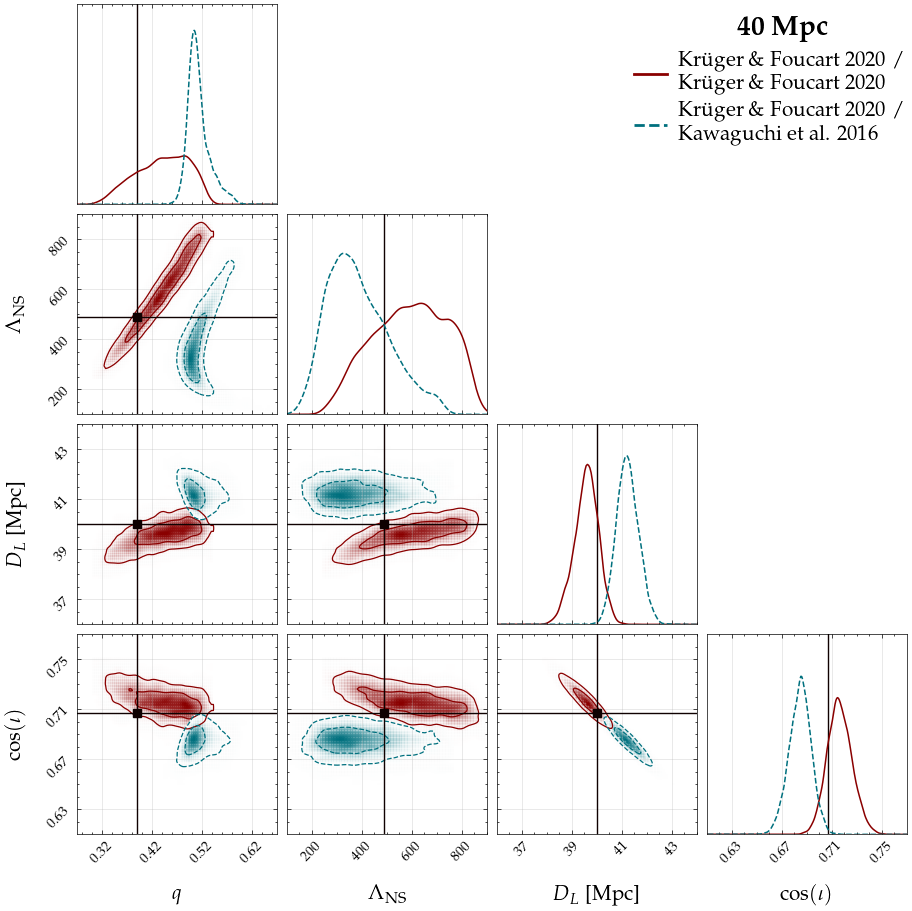

In [62]:
"""
Figure 6.6: Comparison between the different samplers.


The 1D and 2D posterior probability distributions for the component masses of the
source binary of GW230529 along with other NSBH and BNS events.

"""

#fig, axes = plt.subplots(figsize=(12, 7.4 / 2), ncols=2, nrows=1)

# load data

label_key = ['kruger_kruger', 'kruger_kawaguchi']
results_list = [bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_3/40Mpc/dynamical_mass_kruger_kruger/em_run_gw_parameters', 
                                                   label='em'),
                       bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_3/40Mpc/dynamical_mass_kruger_kawaguchi/em_run_gw_parameters', 
                                                   label='em')]
COLORS_RUNS = {'kruger_kruger'               : COLORS_DICT['darkred'],
               'kruger_kawaguchi'         : COLORS_DICT['teal']}

LINESTYLE_RUNS = {'kruger_kruger'        : '-',
                  'kruger_kawaguchi'     : '--'}

direction  = "in"
smoothing  = 1.8
nbins      = 60

posteriors = ['mass_ratio', 'lambda_2', 'luminosity_distance', 'cos_theta_jn']
param_labels = [r'$q$', r'$\Lambda_{\rm NS}$', r'$D_L$ [Mpc]', r'$\cos(\iota)$']
truth_values = [0.39, 490.32033763361954, 40, 0.707]

fig = corner.corner(
    np.array([results_list[0].posterior[key] for key in posteriors]).T,
    bins            = nbins,
    labels          = param_labels,
    fill_contours   = False,
    plot_datapoints = False,
    color           = COLORS_RUNS['kruger_kruger'],
    smooth          = smoothing,
    levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
    plot_kwargs     = dict(linestyle = "-"),
    hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
    contour_kwargs  = dict(linestyles=LINESTYLE_RUNS['kruger_kruger'], linewidths=[LINEWIDTHS["curve"]]),
    plot_density    = True,
)

corner.corner(
    np.array([results_list[1].posterior[key] for key in posteriors]).T,
    fig             = fig,
    bins            = nbins,
    labels          = param_labels,
    fill_contours   = False,
    plot_datapoints = False,
    color           = COLORS_RUNS['kruger_kawaguchi'],
    smooth          = smoothing,
    truths          = truth_values,
    truth_color     = COLORS_DICT["black"],
    levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
    plot_kwargs     = dict(linestyle = "-"),
    hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
    contour_kwargs  = dict(linestyles=LINESTYLE_RUNS['kruger_kawaguchi'], linewidths=[LINEWIDTHS["curve"]]),
    plot_density    = True,
    labelpad        = -0.05,
)

# Evaluate KDE
kde_mass_ratio              = [gaussian_kde(results_list[i].posterior["mass_ratio"].to_numpy()) for i in range(len(results_list))]
kde_lambda_2                = [gaussian_kde(results_list[i].posterior["lambda_2"].to_numpy()) for i in range(len(results_list))]
kde_luminosity_distance     = [gaussian_kde(results_list[i].posterior["luminosity_distance"].to_numpy()) for i in range(len(results_list))]
kde_cos_theta_jn            = [gaussian_kde(results_list[i].posterior["cos_theta_jn"].to_numpy()) for i in range(len(results_list))]

kdes = [kde_mass_ratio, kde_lambda_2, kde_luminosity_distance, kde_cos_theta_jn]
kdes_ranges = [np.linspace(0.1, 1, 1000), np.linspace(0, 3500, 3000), 
               np.linspace(10, 60, 1000), np.linspace(0.3, 1, 1000)]

mass_ratio_ticks            = [0.32, 0.42, 0.52, 0.62]
lambda_2_ticks              = [200, 400, 600, 800]
luminosity_distance_ticks   = [37, 39, 41, 43]
cos_theta_jn_ticks          = [0.63, 0.67, 0.71, 0.75]

for j, axes in enumerate([0, 5, 10, 15]):
    for i, label in enumerate(label_key):
        fig.get_axes()[axes].plot(kdes_ranges[j], kdes[j][i](kdes_ranges[j]), color=COLORS_RUNS[label], linestyle=LINESTYLE_RUNS[label], linewidth=1.1)

# mass_ratio 1D-distribution
fig.get_axes()[0].set_xticks(mass_ratio_ticks)

# mass_ratio-lambda_2 2D distribution
fig.get_axes()[4].set_xticks(mass_ratio_ticks)
fig.get_axes()[4].set_yticks(lambda_2_ticks)

# lambda_2 1D distribution
fig.get_axes()[5].set_xticks(lambda_2_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[8].set_xticks(mass_ratio_ticks)
fig.get_axes()[8].set_yticks(luminosity_distance_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[9].set_xticks(lambda_2_ticks)
fig.get_axes()[9].set_yticks(luminosity_distance_ticks)

# mwind 1D distribution
fig.get_axes()[10].set_xticks(luminosity_distance_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[12].set_xticks(mass_ratio_ticks)
fig.get_axes()[12].set_yticks(cos_theta_jn_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[13].set_xticks(lambda_2_ticks)
fig.get_axes()[13].set_yticks(cos_theta_jn_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[14].set_xticks(luminosity_distance_ticks)
fig.get_axes()[14].set_yticks(cos_theta_jn_ticks)

# mwind 1D distribution
fig.get_axes()[15].set_xticks(cos_theta_jn_ticks)

# Tune x and y limits
mass_ratio_min, mass_ratio_max                       = 0.27, 0.67
lambda_2_min, lambda_2_max                           = 100, 900
luminosity_distance_min, luminosity_distance_max     = 36, 44
cos_theta_jn_min, cos_theta_jn_max                   = 0.63 - 0.02, 0.75 + 0.02
# mwind_min, mwind_max        =  0.016, 0.024

# mass_ratio 1D-distribution
fig.get_axes()[0].set_xlim((mass_ratio_min, mass_ratio_max))

# mass_ratio-lambda_2 2D distribution
fig.get_axes()[4].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[4].set_ylim((lambda_2_min, lambda_2_max))

# lambda_2 1D distribution
fig.get_axes()[5].set_xlim((lambda_2_min, lambda_2_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[8].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[8].set_ylim((luminosity_distance_min, luminosity_distance_max))

# vdyn-mwind 2D distribution
fig.get_axes()[9].set_xlim((lambda_2_min, lambda_2_max))
fig.get_axes()[9].set_ylim((luminosity_distance_min, luminosity_distance_max))

# mwind 1D distribution
fig.get_axes()[10].set_xlim((luminosity_distance_min, luminosity_distance_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[12].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[12].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[13].set_xlim((lambda_2_min, lambda_2_max))
fig.get_axes()[13].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# vdyn-mwind 2D distribution
fig.get_axes()[14].set_xlim((luminosity_distance_min, luminosity_distance_max))
fig.get_axes()[14].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# mwind 1D distribution
fig.get_axes()[15].set_xlim((cos_theta_jn_min, cos_theta_jn_max))

# add the legend to the plot
handles = [Line2D([], [], color=COLORS_DICT["darkred"], ls="-"), 
           Line2D([], [], color=COLORS_DICT["teal"], ls="--")]

labels = ['Krüger \& Foucart 2020 /\n Krüger \& Foucart 2020', 'Krüger \& Foucart 2020 /\n Kawaguchi et al. 2016']
legend = plt.legend(handles, labels, loc=(-0.38, 3.43), fontsize=15)
for i in legend.legend_handles:
    i.set_linewidth(2)

plt.annotate(r"\textbf{40 Mpc}",
            xy=(0.15, 4), 
            xycoords='axes fraction',
            size=20,
            bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

fig.savefig(results_case_studies_dir + "case_study_3/corner_plot_comparison_40Mpc.pdf")
fig.savefig(results_case_studies_dir + "case_study_3/corner_plot_comparison_40Mpc.png")

KeyboardInterrupt: 

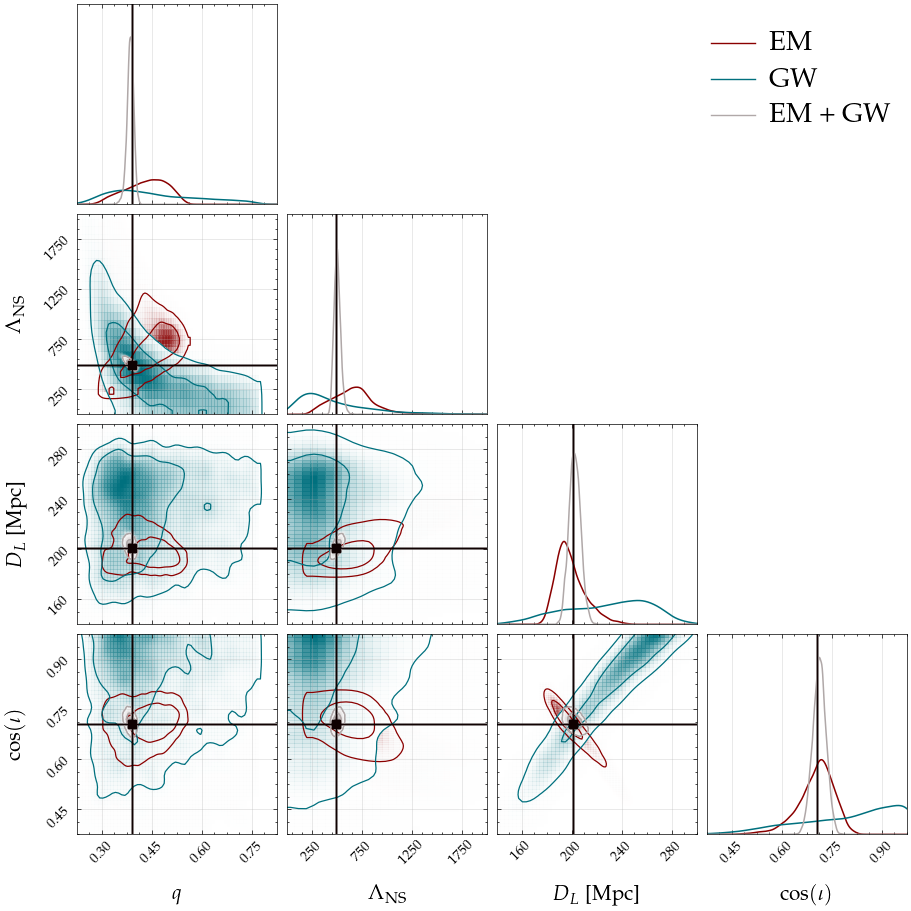

In [16]:
"""
Figure 6.6: Comparison between the different samplers.


The 1D and 2D posterior probability distributions for the component masses of the
source binary of GW230529 along with other NSBH and BNS events.

"""

# load data
folder_key = ['em_run', 'gw_run', 'combined_run']
label_key = ['em', 'gw', 'em_gw']
results_list = [bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_4/O4/{folder_key[i]}', label=label) for i, label in enumerate(label_key)]
COLORS_RUNS = {'em'         : COLORS_DICT['darkred'],
               'gw'         : COLORS_DICT['teal'],
               'em_gw'      : COLORS_DICT['gray']}

direction  = "in"
smoothing  = 1.8
nbins      = 60

posteriors = ['mass_ratio', 'lambda_2', 'luminosity_distance', 'cos_theta_jn']
param_labels = [r'$q$', r'$\Lambda_{\rm NS}$', r'$D_L$ [Mpc]', r'$\cos(\iota)$']
truth_values = [0.39, 490.32033763361954, 201, 0.707]

for i, label in enumerate(label_key):

    if i == 0:
        fig = corner.corner(
            np.array([results_list[i].posterior[key] for key in posteriors]).T,
            bins            = nbins,
            labels          = param_labels,
            fill_contours   = False,
            plot_datapoints = False,
            color           = COLORS_RUNS[label],
            smooth          = smoothing,
            levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
            plot_kwargs     = dict(linestyle = "-"),
            hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
            contour_kwargs  = dict(linestyles="-", linewidths=[LINEWIDTHS["curve"]]),
            plot_density    = True,
        )

    else:

        corner.corner(
            np.array([results_list[i].posterior[key] for key in posteriors]).T,
            fig             = fig,
            bins            = nbins,
            labels          = param_labels,
            fill_contours   = False,
            plot_datapoints = False,
            color           = COLORS_RUNS[label],
            smooth          = smoothing,
            truths          = truth_values,
            truth_color     = COLORS_DICT["black"],
            levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
            plot_kwargs     = dict(linestyle = "-"),
            hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
            contour_kwargs  = dict(linestyles="-", linewidths=[LINEWIDTHS["curve"]]),
            plot_density    = True,
            labelpad        = -0.05,
        )

# Evaluate KDE
kde_mass_ratio              = [gaussian_kde(results_list[i].posterior["mass_ratio"].to_numpy()) for i in range(len(results_list))]
kde_lambda_2                = [gaussian_kde(results_list[i].posterior["lambda_2"].to_numpy()) for i in range(len(results_list))]
kde_luminosity_distance     = [gaussian_kde(results_list[i].posterior["luminosity_distance"].to_numpy()) for i in range(len(results_list))]
kde_cos_theta_jn            = [gaussian_kde(results_list[i].posterior["cos_theta_jn"].to_numpy()) for i in range(len(results_list))]

kdes = [kde_mass_ratio, kde_lambda_2, kde_luminosity_distance, kde_cos_theta_jn]
kdes_ranges = [np.linspace(0.1, 1, 1000), np.linspace(0, 2500, 1000), 
               np.linspace(120, 300, 1000), np.linspace(0.3, 1, 1000)]

mass_ratio_ticks            = [0.3, 0.45, 0.6, 0.75]
lambda_2_ticks              = [250, 750, 1250, 1750]
luminosity_distance_ticks   = [160, 200, 240, 280]
cos_theta_jn_ticks          = [0.45, 0.6, 0.75, 0.9]

# xticks = [mdyn_ticks, vdyn_ticks, mwind_ticks]

for j, axes in enumerate([0, 5, 10, 15]):
    for i, label in enumerate(label_key):
        fig.get_axes()[axes].plot(kdes_ranges[j], kdes[j][i](kdes_ranges[j]), color=COLORS_RUNS[label], linestyle="-", linewidth=1.1)

corner.corner(
            np.array([results_list[i].posterior[key] for key in posteriors]).T,
            fig             = fig,
            bins            = nbins,
            labels          = param_labels,
            fill_contours   = False,
            plot_datapoints = False,
            color           = COLORS_RUNS[label],
            smooth          = smoothing,
            truths          = truth_values,
            truth_color     = COLORS_DICT["black"],
            levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
            plot_kwargs     = dict(linestyle = "-"),
            hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
            contour_kwargs  = dict(linestyles="-", linewidths=[LINEWIDTHS["curve"]]),
            plot_density    = True,
            labelpad        = -0.05,
        )

# mass_ratio 1D-distribution
fig.get_axes()[0].set_xticks(mass_ratio_ticks)

# mass_ratio-lambda_2 2D distribution
fig.get_axes()[4].set_xticks(mass_ratio_ticks)
fig.get_axes()[4].set_yticks(lambda_2_ticks)

# lambda_2 1D distribution
fig.get_axes()[5].set_xticks(lambda_2_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[8].set_xticks(mass_ratio_ticks)
fig.get_axes()[8].set_yticks(luminosity_distance_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[9].set_xticks(lambda_2_ticks)
fig.get_axes()[9].set_yticks(luminosity_distance_ticks)

# mwind 1D distribution
fig.get_axes()[10].set_xticks(luminosity_distance_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[12].set_xticks(mass_ratio_ticks)
fig.get_axes()[12].set_yticks(cos_theta_jn_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[13].set_xticks(lambda_2_ticks)
fig.get_axes()[13].set_yticks(cos_theta_jn_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[14].set_xticks(luminosity_distance_ticks)
fig.get_axes()[14].set_yticks(cos_theta_jn_ticks)

# mwind 1D distribution
fig.get_axes()[15].set_xticks(cos_theta_jn_ticks)

# Tune x and y limits
mass_ratio_min, mass_ratio_max                       = 0.3 - 0.075, 0.75 + 0.075
lambda_2_min, lambda_2_max                           = 0, 2000
luminosity_distance_min, luminosity_distance_max     = 140, 300
cos_theta_jn_min, cos_theta_jn_max                   = 0.45 - 0.075, 0.9 + 0.075
# mwind_min, mwind_max        =  0.016, 0.024

# mass_ratio 1D-distribution
fig.get_axes()[0].set_xlim((mass_ratio_min, mass_ratio_max))

# mass_ratio-lambda_2 2D distribution
fig.get_axes()[4].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[4].set_ylim((lambda_2_min, lambda_2_max))

# lambda_2 1D distribution
fig.get_axes()[5].set_xlim((lambda_2_min, lambda_2_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[8].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[8].set_ylim((luminosity_distance_min, luminosity_distance_max))

# vdyn-mwind 2D distribution
fig.get_axes()[9].set_xlim((lambda_2_min, lambda_2_max))
fig.get_axes()[9].set_ylim((luminosity_distance_min, luminosity_distance_max))

# mwind 1D distribution
fig.get_axes()[10].set_xlim((luminosity_distance_min, luminosity_distance_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[12].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[12].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[13].set_xlim((lambda_2_min, lambda_2_max))
fig.get_axes()[13].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# vdyn-mwind 2D distribution
fig.get_axes()[14].set_xlim((luminosity_distance_min, luminosity_distance_max))
fig.get_axes()[14].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# mwind 1D distribution
fig.get_axes()[15].set_xlim((cos_theta_jn_min, cos_theta_jn_max))

# add the legend to the plot
handles = [Line2D([], [], color=COLORS_DICT["darkred"], ls="-"), 
           Line2D([], [], color=COLORS_DICT["teal"], ls="-"),
           Line2D([], [], color=COLORS_DICT["gray"], ls="-")]

labels = [r'EM', r'GW', r'EM + GW']
legend = plt.legend(handles, labels, loc=(0, 3.5), fontsize=20)
for i in legend.legend_handles:
    i.set_linewidth(1)

fig.savefig(results_case_studies_dir + "case_study_4/corner_plot_O4.pdf")
fig.savefig(results_case_studies_dir + "case_study_4/corner_plot_O4.png")


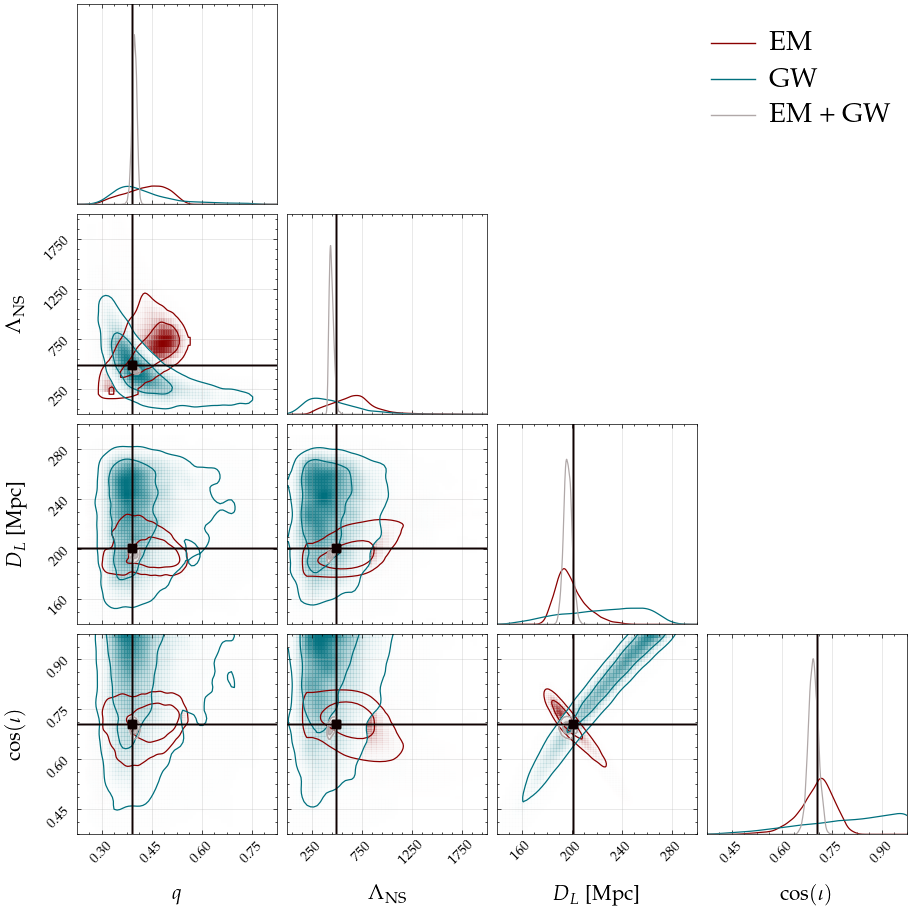

In [273]:
"""
Figure 6.6: Comparison between the different samplers.


The 1D and 2D posterior probability distributions for the component masses of the
source binary of GW230529 along with other NSBH and BNS events.

"""

# load data
folder_key = ['em_run', 'gw_run', 'combined_run']
label_key = ['em', 'gw', 'em_gw']
results_list = [bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_4/O5/{folder_key[i]}', label=label) for i, label in enumerate(label_key)]
COLORS_RUNS = {'em'         : COLORS_DICT['darkred'],
               'gw'         : COLORS_DICT['teal'],
               'em_gw'      : COLORS_DICT['gray']}

direction  = "in"
smoothing  = 1.8
nbins      = 60

posteriors = ['mass_ratio', 'lambda_2', 'luminosity_distance', 'cos_theta_jn']
param_labels = [r'$q$', r'$\Lambda_{\rm NS}$', r'$D_L$ [Mpc]', r'$\cos(\iota)$']
truth_values = [0.39, 490.32033763361954, 201, 0.707]

for i, label in enumerate(label_key):

    if i == 0:
        fig = corner.corner(
            np.array([results_list[i].posterior[key] for key in posteriors]).T,
            bins            = nbins,
            labels          = param_labels,
            fill_contours   = False,
            plot_datapoints = False,
            color           = COLORS_RUNS[label],
            smooth          = smoothing,
            levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
            plot_kwargs     = dict(linestyle = "-"),
            hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
            contour_kwargs  = dict(linestyles="-", linewidths=[LINEWIDTHS["curve"]]),
            plot_density    = True,
        )

    else:

        corner.corner(
            np.array([results_list[i].posterior[key] for key in posteriors]).T,
            fig             = fig,
            bins            = nbins,
            labels          = param_labels,
            fill_contours   = False,
            plot_datapoints = False,
            color           = COLORS_RUNS[label],
            smooth          = smoothing,
            truths          = truth_values,
            truth_color     = COLORS_DICT["black"],
            levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
            plot_kwargs     = dict(linestyle = "-"),
            hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
            contour_kwargs  = dict(linestyles="-", linewidths=[LINEWIDTHS["curve"]]),
            plot_density    = True,
            labelpad        = -0.05,
        )

# Evaluate KDE
kde_mass_ratio              = [gaussian_kde(results_list[i].posterior["mass_ratio"].to_numpy()) for i in range(len(results_list))]
kde_lambda_2                = [gaussian_kde(results_list[i].posterior["lambda_2"].to_numpy()) for i in range(len(results_list))]
kde_luminosity_distance     = [gaussian_kde(results_list[i].posterior["luminosity_distance"].to_numpy()) for i in range(len(results_list))]
kde_cos_theta_jn            = [gaussian_kde(results_list[i].posterior["cos_theta_jn"].to_numpy()) for i in range(len(results_list))]

kdes = [kde_mass_ratio, kde_lambda_2, kde_luminosity_distance, kde_cos_theta_jn]
kdes_ranges = [np.linspace(0.1, 1, 1000), np.linspace(0, 2500, 1000), 
               np.linspace(120, 300, 1000), np.linspace(0.3, 1, 1000)]

mass_ratio_ticks            = [0.3, 0.45, 0.6, 0.75]
lambda_2_ticks              = [250, 750, 1250, 1750]
luminosity_distance_ticks   = [160, 200, 240, 280]
cos_theta_jn_ticks          = [0.45, 0.6, 0.75, 0.9]

# xticks = [mdyn_ticks, vdyn_ticks, mwind_ticks]

for j, axes in enumerate([0, 5, 10, 15]):
    for i, label in enumerate(label_key):
        fig.get_axes()[axes].plot(kdes_ranges[j], kdes[j][i](kdes_ranges[j]), color=COLORS_RUNS[label], linestyle="-", linewidth=LINEWIDTHS["curve"])

corner.corner(
            np.array([results_list[i].posterior[key] for key in posteriors]).T,
            fig             = fig,
            bins            = nbins,
            labels          = param_labels,
            fill_contours   = False,
            plot_datapoints = False,
            color           = COLORS_RUNS[label],
            smooth          = smoothing,
            truths          = truth_values,
            truth_color     = COLORS_DICT["black"],
            levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
            plot_kwargs     = dict(linestyle = "-"),
            hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
            contour_kwargs  = dict(linestyles="-", linewidths=[LINEWIDTHS["curve"]]),
            plot_density    = True,
            labelpad        = -0.05,
        )

# mass_ratio 1D-distribution
fig.get_axes()[0].set_xticks(mass_ratio_ticks)

# mass_ratio-lambda_2 2D distribution
fig.get_axes()[4].set_xticks(mass_ratio_ticks)
fig.get_axes()[4].set_yticks(lambda_2_ticks)

# lambda_2 1D distribution
fig.get_axes()[5].set_xticks(lambda_2_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[8].set_xticks(mass_ratio_ticks)
fig.get_axes()[8].set_yticks(luminosity_distance_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[9].set_xticks(lambda_2_ticks)
fig.get_axes()[9].set_yticks(luminosity_distance_ticks)

# mwind 1D distribution
fig.get_axes()[10].set_xticks(luminosity_distance_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[12].set_xticks(mass_ratio_ticks)
fig.get_axes()[12].set_yticks(cos_theta_jn_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[13].set_xticks(lambda_2_ticks)
fig.get_axes()[13].set_yticks(cos_theta_jn_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[14].set_xticks(luminosity_distance_ticks)
fig.get_axes()[14].set_yticks(cos_theta_jn_ticks)

# mwind 1D distribution
fig.get_axes()[15].set_xticks(cos_theta_jn_ticks)

# Tune x and y limits
mass_ratio_min, mass_ratio_max                       = 0.3 - 0.075, 0.75 + 0.075
lambda_2_min, lambda_2_max                           = 0, 2000
luminosity_distance_min, luminosity_distance_max     = 140, 300
cos_theta_jn_min, cos_theta_jn_max                   = 0.45 - 0.075, 0.9 + 0.075
# mwind_min, mwind_max        =  0.016, 0.024

# mass_ratio 1D-distribution
fig.get_axes()[0].set_xlim((mass_ratio_min, mass_ratio_max))

# mass_ratio-lambda_2 2D distribution
fig.get_axes()[4].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[4].set_ylim((lambda_2_min, lambda_2_max))

# lambda_2 1D distribution
fig.get_axes()[5].set_xlim((lambda_2_min, lambda_2_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[8].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[8].set_ylim((luminosity_distance_min, luminosity_distance_max))

# vdyn-mwind 2D distribution
fig.get_axes()[9].set_xlim((lambda_2_min, lambda_2_max))
fig.get_axes()[9].set_ylim((luminosity_distance_min, luminosity_distance_max))

# mwind 1D distribution
fig.get_axes()[10].set_xlim((luminosity_distance_min, luminosity_distance_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[12].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[12].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[13].set_xlim((lambda_2_min, lambda_2_max))
fig.get_axes()[13].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# vdyn-mwind 2D distribution
fig.get_axes()[14].set_xlim((luminosity_distance_min, luminosity_distance_max))
fig.get_axes()[14].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# mwind 1D distribution
fig.get_axes()[15].set_xlim((cos_theta_jn_min, cos_theta_jn_max))

# add the legend to the plot
handles = [Line2D([], [], color=COLORS_DICT["darkred"], ls="-"), 
           Line2D([], [], color=COLORS_DICT["teal"], ls="-"),
           Line2D([], [], color=COLORS_DICT["gray"], ls="-")]

labels = [r'EM', r'GW', r'EM + GW']
legend = plt.legend(handles, labels, loc=(0, 3.5), fontsize=20)
for i in legend.legend_handles:
    i.set_linewidth(1)

fig.savefig(results_case_studies_dir + "case_study_4/corner_plot_O5.pdf")
fig.savefig(results_case_studies_dir + "case_study_4/corner_plot_O5.png")


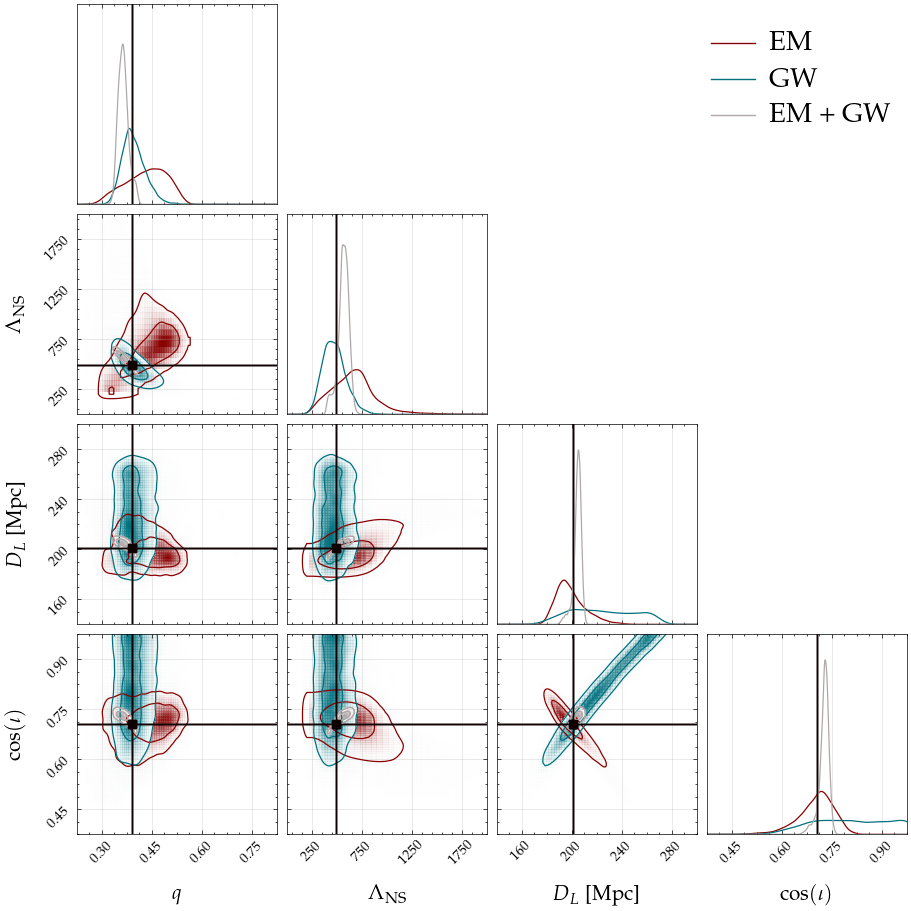

In [22]:
"""
Figure 6.6: Comparison between the different samplers.


The 1D and 2D posterior probability distributions for the component masses of the
source binary of GW230529 along with other NSBH and BNS events.

"""

# load data
folder_key = ['em_run', 'gw_run', 'combined_run']
label_key = ['em', 'gw', 'em_gw']
results_list = [bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_4/O6/{folder_key[i]}', label=label) for i, label in enumerate(label_key)]
COLORS_RUNS = {'em'         : COLORS_DICT['darkred'],
               'gw'         : COLORS_DICT['teal'],
               'em_gw'      : COLORS_DICT['gray']}

direction  = "in"
smoothing  = 1.8
nbins      = 60

posteriors = ['mass_ratio', 'lambda_2', 'luminosity_distance', 'cos_theta_jn']
param_labels = [r'$q$', r'$\Lambda_{\rm NS}$', r'$D_L$ [Mpc]', r'$\cos(\iota)$']
truth_values = [0.39, 490.32033763361954, 201, 0.707]

for i, label in enumerate(label_key):

    if i == 0:
        fig = corner.corner(
            np.array([results_list[i].posterior[key] for key in posteriors]).T,
            bins            = nbins,
            labels          = param_labels,
            fill_contours   = False,
            plot_datapoints = False,
            color           = COLORS_RUNS[label],
            smooth          = smoothing,
            levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
            plot_kwargs     = dict(linestyle = "-"),
            hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
            contour_kwargs  = dict(linestyles="-", linewidths=[LINEWIDTHS["curve"]]),
            plot_density    = True,
        )

    else:

        corner.corner(
            np.array([results_list[i].posterior[key] for key in posteriors]).T,
            fig             = fig,
            bins            = nbins,
            labels          = param_labels,
            fill_contours   = False,
            plot_datapoints = False,
            color           = COLORS_RUNS[label],
            smooth          = smoothing,
            truths          = truth_values,
            truth_color     = COLORS_DICT["black"],
            levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
            plot_kwargs     = dict(linestyle = "-"),
            hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
            contour_kwargs  = dict(linestyles="-", linewidths=[LINEWIDTHS["curve"]]),
            plot_density    = True,
            labelpad        = -0.05,
        )

# Evaluate KDE
kde_mass_ratio              = [gaussian_kde(results_list[i].posterior["mass_ratio"].to_numpy()) for i in range(len(results_list))]
kde_lambda_2                = [gaussian_kde(results_list[i].posterior["lambda_2"].to_numpy()) for i in range(len(results_list))]
kde_luminosity_distance     = [gaussian_kde(results_list[i].posterior["luminosity_distance"].to_numpy()) for i in range(len(results_list))]
kde_cos_theta_jn            = [gaussian_kde(results_list[i].posterior["cos_theta_jn"].to_numpy()) for i in range(len(results_list))]

kdes = [kde_mass_ratio, kde_lambda_2, kde_luminosity_distance, kde_cos_theta_jn]
kdes_ranges = [np.linspace(0.1, 1, 1000), np.linspace(0, 2500, 1000), 
               np.linspace(120, 300, 1000), np.linspace(0.3, 1, 1000)]

mass_ratio_ticks            = [0.3, 0.45, 0.6, 0.75]
lambda_2_ticks              = [250, 750, 1250, 1750]
luminosity_distance_ticks   = [160, 200, 240, 280]
cos_theta_jn_ticks          = [0.45, 0.6, 0.75, 0.9]

# xticks = [mdyn_ticks, vdyn_ticks, mwind_ticks]

for j, axes in enumerate([0, 5, 10, 15]):
    for i, label in enumerate(label_key):
        fig.get_axes()[axes].plot(kdes_ranges[j], kdes[j][i](kdes_ranges[j]), color=COLORS_RUNS[label], linestyle="-", linewidth=LINEWIDTHS["curve"])

corner.corner(
            np.array([results_list[i].posterior[key] for key in posteriors]).T,
            fig             = fig,
            bins            = nbins,
            labels          = param_labels,
            fill_contours   = False,
            plot_datapoints = False,
            color           = COLORS_RUNS[label],
            smooth          = smoothing,
            truths          = truth_values,
            truth_color     = COLORS_DICT["black"],
            levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
            plot_kwargs     = dict(linestyle = "-"),
            hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
            contour_kwargs  = dict(linestyles="-", linewidths=[LINEWIDTHS["curve"]]),
            plot_density    = True,
            labelpad        = -0.05,
        )

# mass_ratio 1D-distribution
fig.get_axes()[0].set_xticks(mass_ratio_ticks)

# mass_ratio-lambda_2 2D distribution
fig.get_axes()[4].set_xticks(mass_ratio_ticks)
fig.get_axes()[4].set_yticks(lambda_2_ticks)

# lambda_2 1D distribution
fig.get_axes()[5].set_xticks(lambda_2_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[8].set_xticks(mass_ratio_ticks)
fig.get_axes()[8].set_yticks(luminosity_distance_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[9].set_xticks(lambda_2_ticks)
fig.get_axes()[9].set_yticks(luminosity_distance_ticks)

# mwind 1D distribution
fig.get_axes()[10].set_xticks(luminosity_distance_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[12].set_xticks(mass_ratio_ticks)
fig.get_axes()[12].set_yticks(cos_theta_jn_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[13].set_xticks(lambda_2_ticks)
fig.get_axes()[13].set_yticks(cos_theta_jn_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[14].set_xticks(luminosity_distance_ticks)
fig.get_axes()[14].set_yticks(cos_theta_jn_ticks)

# mwind 1D distribution
fig.get_axes()[15].set_xticks(cos_theta_jn_ticks)

# Tune x and y limits
mass_ratio_min, mass_ratio_max                       = 0.3 - 0.075, 0.75 + 0.075
lambda_2_min, lambda_2_max                           = 0, 2000
luminosity_distance_min, luminosity_distance_max     = 140, 300
cos_theta_jn_min, cos_theta_jn_max                   = 0.45 - 0.075, 0.9 + 0.075

# mass_ratio 1D-distribution
fig.get_axes()[0].set_xlim((mass_ratio_min, mass_ratio_max))

# mass_ratio-lambda_2 2D distribution
fig.get_axes()[4].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[4].set_ylim((lambda_2_min, lambda_2_max))

# lambda_2 1D distribution
fig.get_axes()[5].set_xlim((lambda_2_min, lambda_2_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[8].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[8].set_ylim((luminosity_distance_min, luminosity_distance_max))

# vdyn-mwind 2D distribution
fig.get_axes()[9].set_xlim((lambda_2_min, lambda_2_max))
fig.get_axes()[9].set_ylim((luminosity_distance_min, luminosity_distance_max))

# mwind 1D distribution
fig.get_axes()[10].set_xlim((luminosity_distance_min, luminosity_distance_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[12].set_xlim((mass_ratio_min, mass_ratio_max))
fig.get_axes()[12].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[13].set_xlim((lambda_2_min, lambda_2_max))
fig.get_axes()[13].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# vdyn-mwind 2D distribution
fig.get_axes()[14].set_xlim((luminosity_distance_min, luminosity_distance_max))
fig.get_axes()[14].set_ylim((cos_theta_jn_min, cos_theta_jn_max))

# mwind 1D distribution
fig.get_axes()[15].set_xlim((cos_theta_jn_min, cos_theta_jn_max))

# add the legend to the plot
handles = [Line2D([], [], color=COLORS_DICT["darkred"], ls="-"), 
           Line2D([], [], color=COLORS_DICT["teal"], ls="-"),
           Line2D([], [], color=COLORS_DICT["gray"], ls="-")]

labels = [r'EM', r'GW', r'EM + GW']
legend = plt.legend(handles, labels, loc=(0, 3.5), fontsize=20)
for i in legend.legend_handles:
    i.set_linewidth(1)

fig.savefig(results_case_studies_dir + "case_study_4/corner_plot_O6.pdf")
fig.savefig(results_case_studies_dir + "case_study_4/corner_plot_O6.png")


[0.4342699839233261, 0.42294808695156405, 0.3049173206991351] [0.4088459941274081, 0.45124121026402125, 0.4458219324403336]


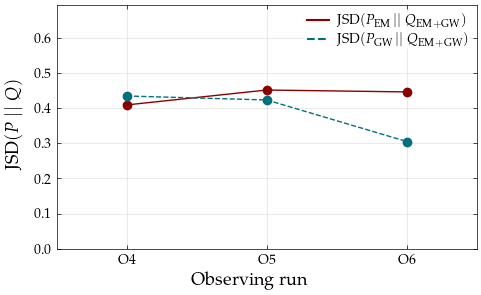

In [15]:

fig, ax = plt.subplots(figsize=FIG_SIZES["rectangle_plot"])

folder_key = ['em_run', 'gw_run', 'combined_run']
label_key = ['em', 'gw', 'em_gw']

results_O4_dict = {label: bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_4/O4/{folder_key[i]}', label=label) 
                   for i, label in enumerate(label_key)}
results_O5_dict = {label: bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_4/O5/{folder_key[i]}', label=label) 
                   for i, label in enumerate(label_key)}
results_O6_dict = {label: bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_4/O6/{folder_key[i]}', label=label) 
                   for i, label in enumerate(label_key)}

def calculate_jsd(results_1, results_2, posterior_keys):
    total_jsd = 0

    def fit_1(x):
            return max(1e-6, kde_1(x))

    def fit_2(x):
        return max(1e-6, kde_2(x))

    for key in posterior_keys:

        posterior_1 = results_1.posterior[key]
        posterior_2 = results_2.posterior[key]

        min_value = np.min([min(posterior_1), min(posterior_2)])
        max_value = np.max([max(posterior_1), max(posterior_2)])

        kde_range = np.linspace(min_value, max_value, 1000)

        kde_1 = gaussian_kde(posterior_1.to_numpy())
        kde_2 = gaussian_kde(posterior_2.to_numpy())

        def fit_1(x):
            return max(1e-6, kde_1(x))

        def fit_2(x):
            return max(1e-6, kde_2(x))

        fit_1 = np.vectorize(fit_1)
        fit_2 = np.vectorize(fit_2)

        total_jsd = total_jsd + jensenshannon(fit_1(kde_range), fit_2(kde_range))**2
    
    return total_jsd / len(posterior_keys)

gw_jsd = [calculate_jsd(results_O4_dict['gw'], results_O4_dict['em_gw'], ['mass_ratio', 'lambda_2', 'luminosity_distance', 'cos_theta_jn', 'chirp_mass', 'chi_1']),
          calculate_jsd(results_O5_dict['gw'], results_O5_dict['em_gw'], ['mass_ratio', 'lambda_2', 'luminosity_distance', 'cos_theta_jn', 'chirp_mass', 'chi_1']),
          calculate_jsd(results_O6_dict['gw'], results_O6_dict['em_gw'], ['mass_ratio', 'lambda_2', 'luminosity_distance', 'cos_theta_jn', 'chirp_mass', 'chi_1'])]
em_jsd = [calculate_jsd(results_O4_dict['em'], results_O4_dict['em_gw'], ['mass_ratio', 'lambda_2', 'luminosity_distance', 'cos_theta_jn', 'chirp_mass', 'chi_1']),
          calculate_jsd(results_O5_dict['em'], results_O5_dict['em_gw'], ['mass_ratio', 'lambda_2', 'luminosity_distance', 'cos_theta_jn', 'chirp_mass', 'chi_1']),
          calculate_jsd(results_O6_dict['em'], results_O6_dict['em_gw'], ['mass_ratio', 'lambda_2', 'luminosity_distance', 'cos_theta_jn', 'chirp_mass', 'chi_1'])]
print(gw_jsd, em_jsd)
ax.plot([0.5, 1.5, 2.5], em_jsd, '-',color=COLORS_DICT['darkred'])
ax.plot([0.5, 1.5, 2.5], em_jsd, 'o',color=COLORS_DICT['darkred'])
ax.plot([0.5, 1.5, 2.5], gw_jsd, '--',color=COLORS_DICT['teal'])
ax.plot([0.5, 1.5, 2.5], gw_jsd, 'o',color=COLORS_DICT['teal'])

ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels(['O4', 'O5', 'O6'])

fig.supxlabel("Observing run", x=0.48, y=-0.02, fontsize=13)
fig.supylabel(r"JSD$(P\text{ }||\text{ }Q)$", y=0.5, x=0.03, fontsize=13)

handles = [Line2D([], [], color=COLORS_DICT["darkred"], ls="-"), Line2D([], [], color=COLORS_DICT["teal"], ls="--"),]
labels = [r"JSD$(P_\text{EM }||\text{ }Q_{\text{EM}+\text{GW}})$", r"JSD$(P_\text{GW }||\text{ }Q_{\text{EM}+\text{GW}})$"]
legend = plt.legend(handles, labels, loc=(0.59, 0.82))
for i in legend.legend_handles:
    i.set_linewidth(1.5)

ax.set_xlim(0, 3)
ax.set_ylim(0, np.log(2))

ax.minorticks_off()

# fig.savefig(results_case_studies_dir + "case_study_4/jsd_networks.pdf")
# fig.savefig(results_case_studies_dir + "case_study_4/jsd_networks.png")

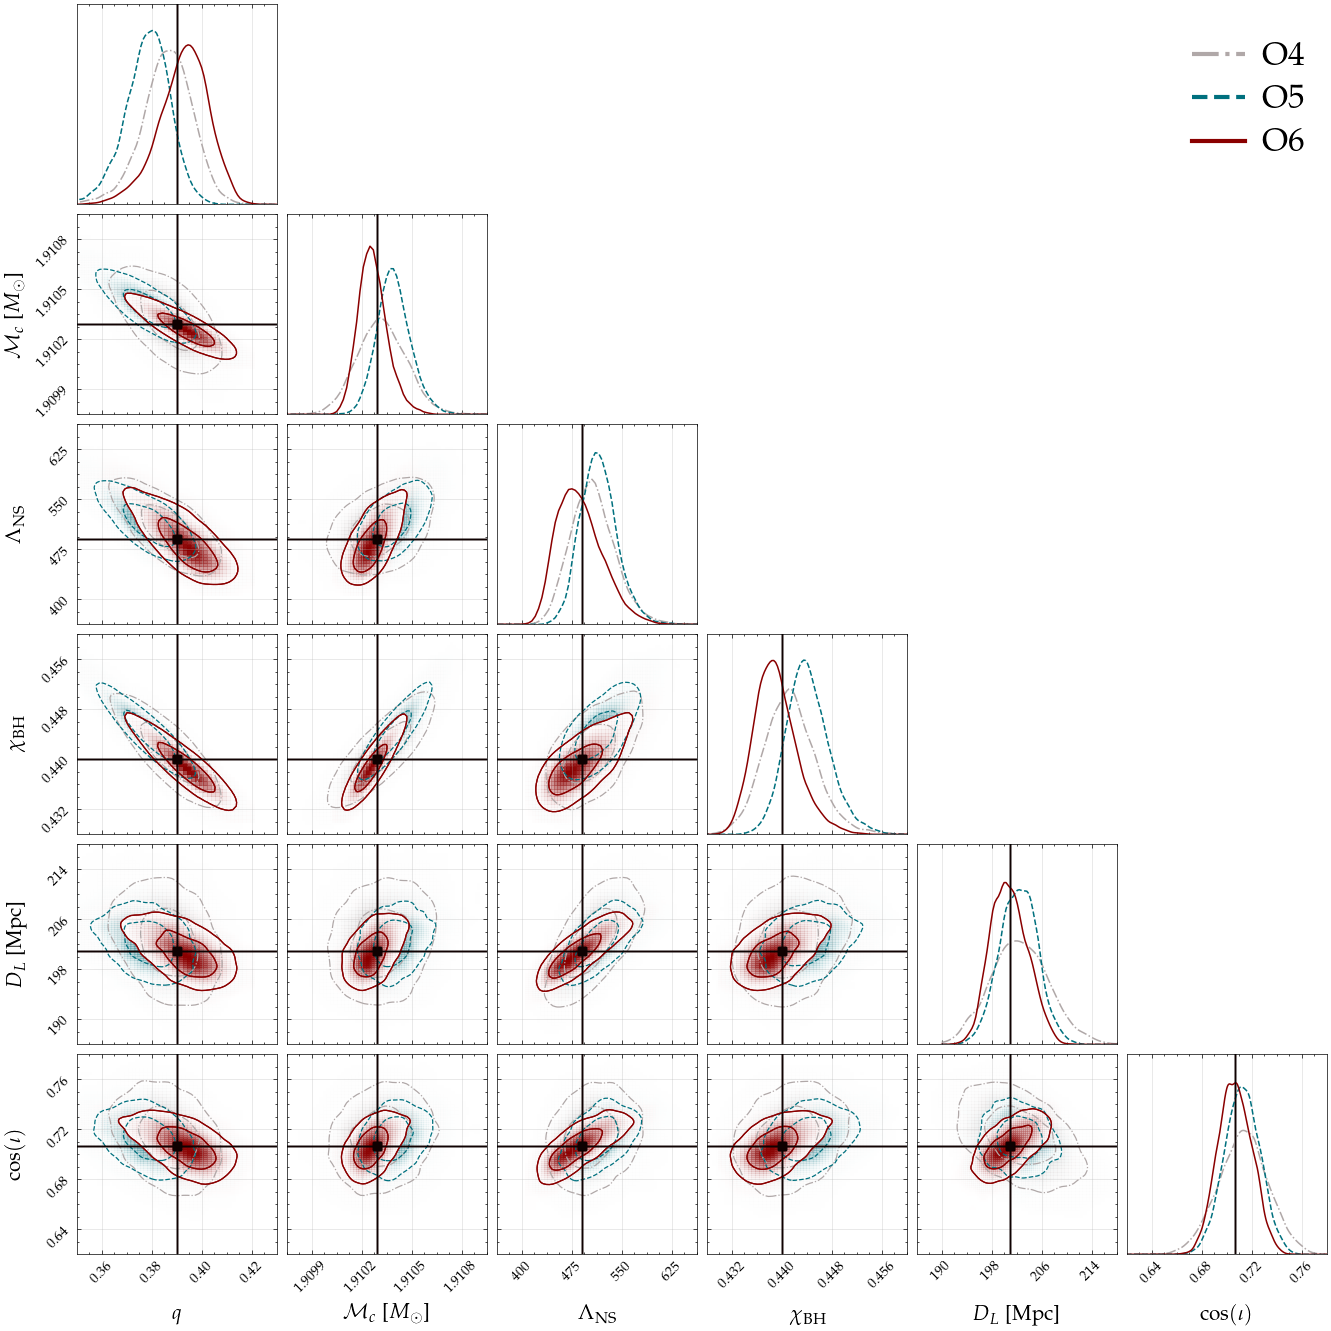

In [12]:
"""
Figure 6.6: Comparison between the different samplers.


The 1D and 2D posterior probability distributions for the component masses of the
source binary of GW230529 along with other NSBH and BNS events.

"""

# load data
label_key = ['O4', 'O5', 'O6']
results_list = [bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_4/{label}/combined_run/', label='em_gw') for i, label in enumerate(label_key)]
COLORS_RUNS = {'O6'      : COLORS_DICT['darkred'],
               'O5'     : COLORS_DICT['teal'],
               'O4'     : COLORS_DICT['gray']}

LINESTYLE_RUNS = {'O6'     : '-',
                  'O5'     : '--',
                  'O4'     : '-.'}

direction  = "in"
smoothing  = 1.8
nbins      = 60

posteriors = ['mass_ratio', 'chirp_mass', 'lambda_2', 'chi_1', 'luminosity_distance', 'cos_theta_jn']
param_labels = [r'$q$', r'$\mathcal{M}_c$ [$M_\odot$]', r'$\Lambda_{\rm NS}$', r'$\chi_{\rm BH}$', '$D_L$ [Mpc]', r'$\cos(\iota)$']
truth_values = [0.39, 1.9102896946252306, 490.32033763361954, 0.44, 201, 0.707]

for i, label in enumerate(label_key):

    if i == 0:
        fig = corner.corner(
            np.array([results_list[i].posterior[key] for key in posteriors]).T,
            bins            = nbins,
            labels          = param_labels,
            fill_contours   = False,
            plot_datapoints = False,
            color           = COLORS_RUNS[label],
            smooth          = smoothing,
            levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
            plot_kwargs     = dict(linestyle = LINESTYLE_RUNS[label]),
            hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
            contour_kwargs  = dict(linestyles=LINESTYLE_RUNS[label], linewidths=[LINEWIDTHS["curve"]]),
            plot_density    = True,
        )

    else:

        corner.corner(
            np.array([results_list[i].posterior[key] for key in posteriors]).T,
            fig             = fig,
            bins            = nbins,
            labels          = param_labels,
            fill_contours   = False,
            plot_datapoints = False,
            color           = COLORS_RUNS[label],
            smooth          = smoothing,
            truths          = truth_values,
            truth_color     = COLORS_DICT["black"],
            levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
            plot_kwargs     = dict(linestyle = "-"),
            hist_kwargs     = {"density": True, "linestyle": '-', "linewidth": 0.0},
            contour_kwargs  = dict(linestyles=LINESTYLE_RUNS[label], linewidths=[LINEWIDTHS["curve"]]),
            plot_density    = True,
            labelpad        = -0.05,
        )

# Evaluate KDE
kde_mass_ratio              = [gaussian_kde(results_list[i].posterior["mass_ratio"].to_numpy()) for i in range(len(results_list))]
kde_chirp_mass              = [gaussian_kde(results_list[i].posterior["chirp_mass"].to_numpy()) for i in range(len(results_list))]
kde_lambda_2                = [gaussian_kde(results_list[i].posterior["lambda_2"].to_numpy()) for i in range(len(results_list))]
kde_chi_1                   = [gaussian_kde(results_list[i].posterior["chi_1"].to_numpy()) for i in range(len(results_list))]
kde_luminosity_distance     = [gaussian_kde(results_list[i].posterior["luminosity_distance"].to_numpy()) for i in range(len(results_list))]
kde_cos_theta_jn            = [gaussian_kde(results_list[i].posterior["cos_theta_jn"].to_numpy()) for i in range(len(results_list))]

kdes = [kde_mass_ratio, kde_chirp_mass, kde_lambda_2, kde_chi_1, kde_luminosity_distance, kde_cos_theta_jn]
kdes_ranges = [np.linspace(0.1, 1, 1000), np.linspace(1.90, 1.92, 1000), np.linspace(0, 5000, 1000), 
               np.linspace(0.3, 0.6, 1000), np.linspace(190, 220, 100),  np.linspace(0.6, 1, 1000)]

mass_ratio_ticks            = [0.36, 0.38, 0.40, 0.42]
chirp_mass_ticks            = (np.array([-0.0001, 0.0002, 0.0005, 0.0008]) + 1.91).tolist()
lambda_2_ticks              = [400, 475, 550, 625]
chi_1_ticks                 = [0.432, 0.440, 0.448, 0.456]
luminosity_distance_ticks   = [190, 198, 206, 214]
cos_theta_jn_ticks          = [0.64, 0.68, 0.72, 0.76]


for j, axes in enumerate([0, 7, 14, 21, 28, 35]):
    for i, label in enumerate(label_key):
        fig.get_axes()[axes].plot(kdes_ranges[j], kdes[j][i](kdes_ranges[j]), color=COLORS_RUNS[label], linestyle=LINESTYLE_RUNS[label], linewidth=1.1)

corner.corner(
            np.array([results_list[i].posterior[key] for key in posteriors]).T,
            fig             = fig,
            bins            = nbins,
            labels          = param_labels,
            fill_contours   = False,
            plot_datapoints = False,
            color           = COLORS_RUNS[label],
            smooth          = smoothing,
            truths          = truth_values,
            truth_color     = COLORS_DICT["black"],
            levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
            plot_kwargs     = dict(linestyle = "-"),
            hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
            contour_kwargs  = dict(linestyles=LINESTYLE_RUNS[label], linewidths=[LINEWIDTHS["curve"]]),
            plot_density    = True,
            labelpad        = -0.05,
        )

# mass_ratio 1D-distribution
fig.get_axes()[0].set_xticks(mass_ratio_ticks)

# mass_ratio-lambda_2 2D distribution
fig.get_axes()[6].set_xticks(mass_ratio_ticks)
fig.get_axes()[6].set_yticks(chirp_mass_ticks)

# lambda_2 1D distribution
fig.get_axes()[7].set_xticks(chirp_mass_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[12].set_xticks(mass_ratio_ticks)
fig.get_axes()[12].set_yticks(lambda_2_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[13].set_xticks(chirp_mass_ticks)
fig.get_axes()[13].set_yticks(lambda_2_ticks)

# mwind 1D distribution
fig.get_axes()[14].set_xticks(lambda_2_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[18].set_xticks(mass_ratio_ticks)
fig.get_axes()[18].set_yticks(chi_1_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[19].set_xticks(chirp_mass_ticks)
fig.get_axes()[19].set_yticks(chi_1_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[20].set_xticks(lambda_2_ticks)
fig.get_axes()[20].set_yticks(chi_1_ticks)

# mwind 1D distribution
fig.get_axes()[21].set_xticks(chi_1_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[24].set_xticks(mass_ratio_ticks)
fig.get_axes()[24].set_yticks(luminosity_distance_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[25].set_xticks(chirp_mass_ticks)
fig.get_axes()[25].set_yticks(luminosity_distance_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[26].set_xticks(lambda_2_ticks)
fig.get_axes()[26].set_yticks(luminosity_distance_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[27].set_xticks(chi_1_ticks)
fig.get_axes()[27].set_yticks(luminosity_distance_ticks)

# mwind 1D distribution
fig.get_axes()[28].set_xticks(luminosity_distance_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[30].set_xticks(mass_ratio_ticks)
fig.get_axes()[30].set_yticks(cos_theta_jn_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[31].set_xticks(chirp_mass_ticks)
fig.get_axes()[31].set_yticks(cos_theta_jn_ticks)

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[32].set_xticks(lambda_2_ticks)
fig.get_axes()[32].set_yticks(cos_theta_jn_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[33].set_xticks(chi_1_ticks)
fig.get_axes()[33].set_yticks(cos_theta_jn_ticks)

# vdyn-mwind 2D distribution
fig.get_axes()[34].set_xticks(luminosity_distance_ticks)
fig.get_axes()[34].set_yticks(cos_theta_jn_ticks)

# mwind 1D distribution
fig.get_axes()[35].set_xticks(cos_theta_jn_ticks)

# Tune x and y limits
mass_ratio_min, mass_ratio_max                       = 0.35, 0.43
chirp_mass_min, chirp_mass_max                       = 1.9100 - 0.00025, 1.91 + 0.00095
lambda_2_min, lambda_2_max                           = 400 - (75 / 2), 625 + (75 / 2)
chi_1_min, chi_1_max                                 = 0.428, 0.460
luminosity_distance_min, luminosity_distance_max     = 186, 218
cos_theta_jn_min, cos_theta_jn_max                   = 0.62, 0.78

# mass_ratio 1D-distribution
fig.get_axes()[0].set_xlim([mass_ratio_min, mass_ratio_max])

# mass_ratio-lambda_2 2D distribution
fig.get_axes()[6].set_xlim([mass_ratio_min, mass_ratio_max])
fig.get_axes()[6].set_ylim([chirp_mass_min, chirp_mass_max])

# lambda_2 1D distribution
fig.get_axes()[7].set_xlim([chirp_mass_min, chirp_mass_max])

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[12].set_xlim([mass_ratio_min, mass_ratio_max])
fig.get_axes()[12].set_ylim([lambda_2_min, lambda_2_max])

# vdyn-mwind 2D distribution
fig.get_axes()[13].set_xlim([chirp_mass_min, chirp_mass_max])
fig.get_axes()[13].set_ylim([lambda_2_min, lambda_2_max])

# mwind 1D distribution
fig.get_axes()[14].set_xlim([lambda_2_min, lambda_2_max])

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[18].set_xlim([mass_ratio_min, mass_ratio_max])
fig.get_axes()[18].set_ylim([chi_1_min, chi_1_max])

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[19].set_xlim([chirp_mass_min, chirp_mass_max])
fig.get_axes()[19].set_ylim([chi_1_min, chi_1_max])

# vdyn-mwind 2D distribution
fig.get_axes()[20].set_xlim([lambda_2_min, lambda_2_max])
fig.get_axes()[20].set_ylim([chi_1_min, chi_1_max])

# mwind 1D distribution
fig.get_axes()[21].set_xlim([chi_1_min, chi_1_max])

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[24].set_xlim([mass_ratio_min, mass_ratio_max])
fig.get_axes()[24].set_ylim([luminosity_distance_min, luminosity_distance_max])

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[25].set_xlim([chirp_mass_min, chirp_mass_max])
fig.get_axes()[25].set_ylim([luminosity_distance_min, luminosity_distance_max])

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[26].set_xlim([lambda_2_min, lambda_2_max])
fig.get_axes()[26].set_ylim([luminosity_distance_min, luminosity_distance_max])

# vdyn-mwind 2D distribution
fig.get_axes()[27].set_xlim([chi_1_min, chi_1_max])
fig.get_axes()[27].set_ylim([luminosity_distance_min, luminosity_distance_max])

# mwind 1D distribution
fig.get_axes()[28].set_xlim([luminosity_distance_min, luminosity_distance_max])

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[30].set_xlim([mass_ratio_min, mass_ratio_max])
fig.get_axes()[30].set_ylim([cos_theta_jn_min, cos_theta_jn_max])

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[31].set_xlim([chirp_mass_min, chirp_mass_max])
fig.get_axes()[31].set_ylim([cos_theta_jn_min, cos_theta_jn_max])

# mass_ratio-luminosity_distance 2D distribution
fig.get_axes()[32].set_xlim([lambda_2_min, lambda_2_max])
fig.get_axes()[32].set_ylim([cos_theta_jn_min, cos_theta_jn_max])

# vdyn-mwind 2D distribution
fig.get_axes()[33].set_xlim([chi_1_min, chi_1_max])
fig.get_axes()[33].set_ylim([cos_theta_jn_min, cos_theta_jn_max])

# vdyn-mwind 2D distribution
fig.get_axes()[34].set_xlim([luminosity_distance_min, luminosity_distance_max])
fig.get_axes()[34].set_ylim([cos_theta_jn_min, cos_theta_jn_max])

# mwind 1D distribution
fig.get_axes()[35].set_xlim([cos_theta_jn_min, cos_theta_jn_max])

# add the legend to the plot
handles = [Line2D([], [], color=COLORS_DICT["gray"], ls=LINESTYLE_RUNS['O4']), 
           Line2D([], [], color=COLORS_DICT["teal"], ls=LINESTYLE_RUNS['O5']),
           Line2D([], [], color=COLORS_DICT["darkred"], ls=LINESTYLE_RUNS['O6'])]

labels = [r'O4', r'O5', r'O6']
legend = plt.legend(handles, labels, loc=(0.30, 5.45), fontsize=24)
for i in legend.legend_handles:
    i.set_linewidth(3)

# matplotlib.rcParams['axes.formatter.useoffset'] = False

fig.savefig(results_case_studies_dir + "case_study_4/gw_network_corner_plot_combined.pdf")
fig.savefig(results_case_studies_dir + "case_study_4/gw_network_corner_plot_combined.png")

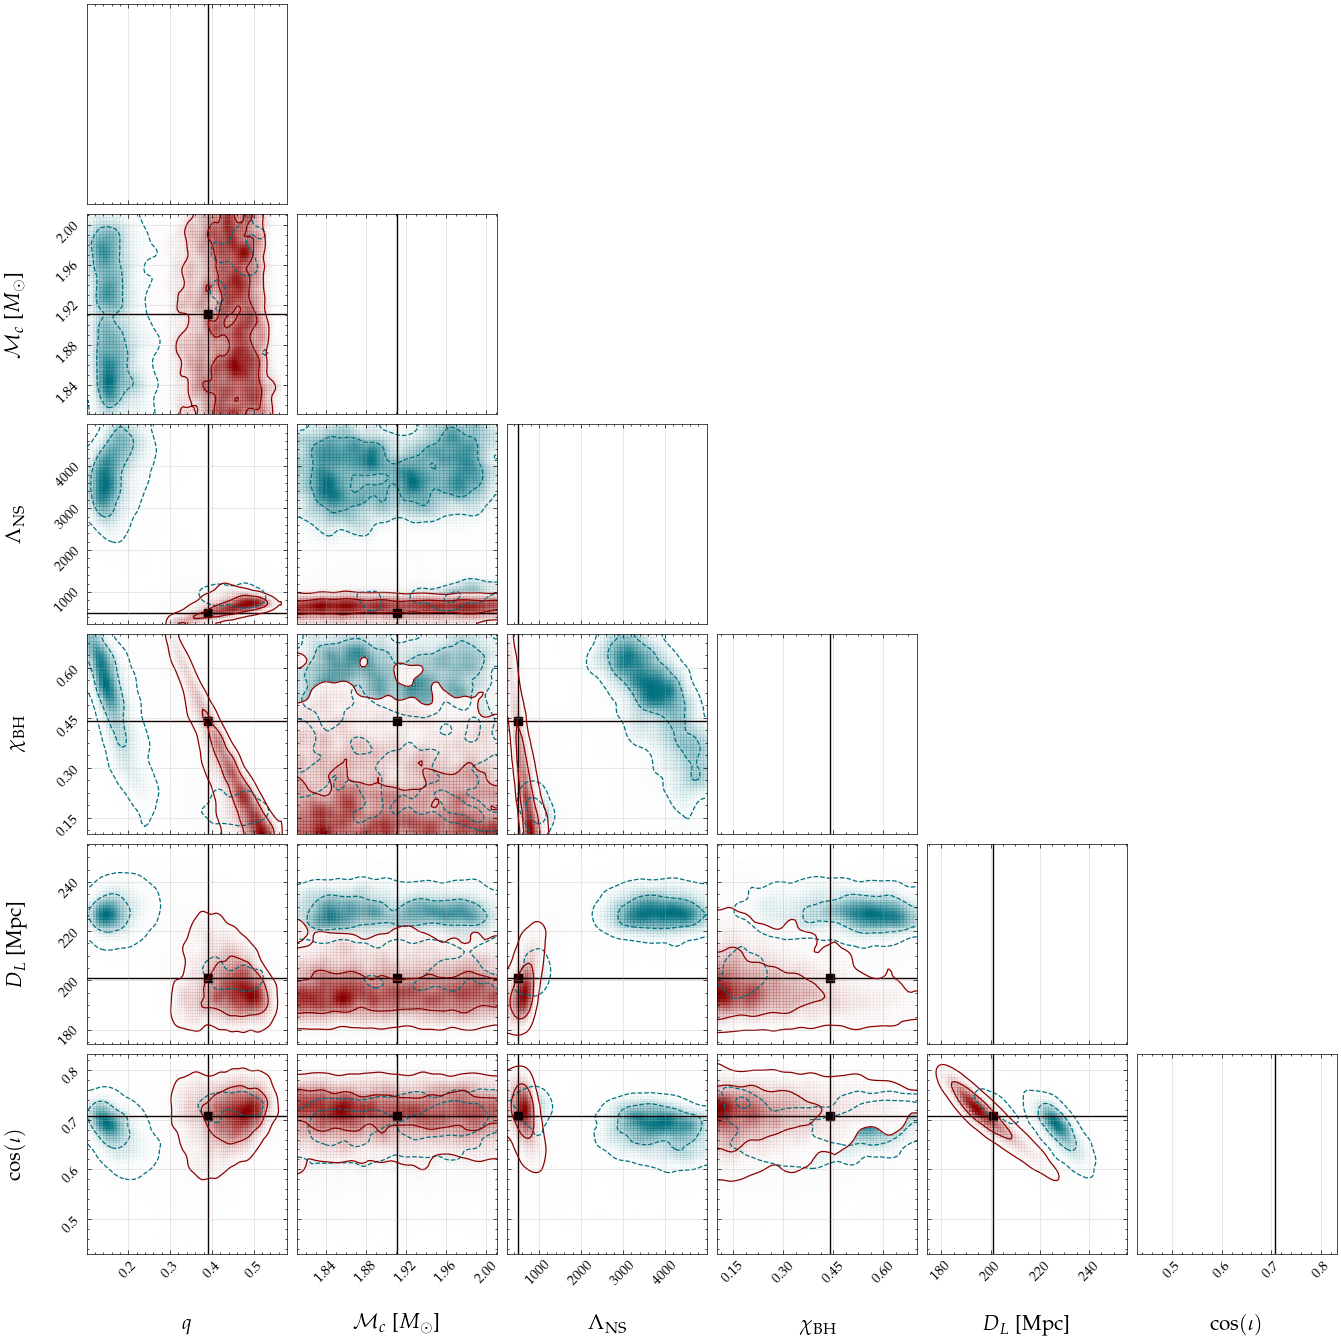

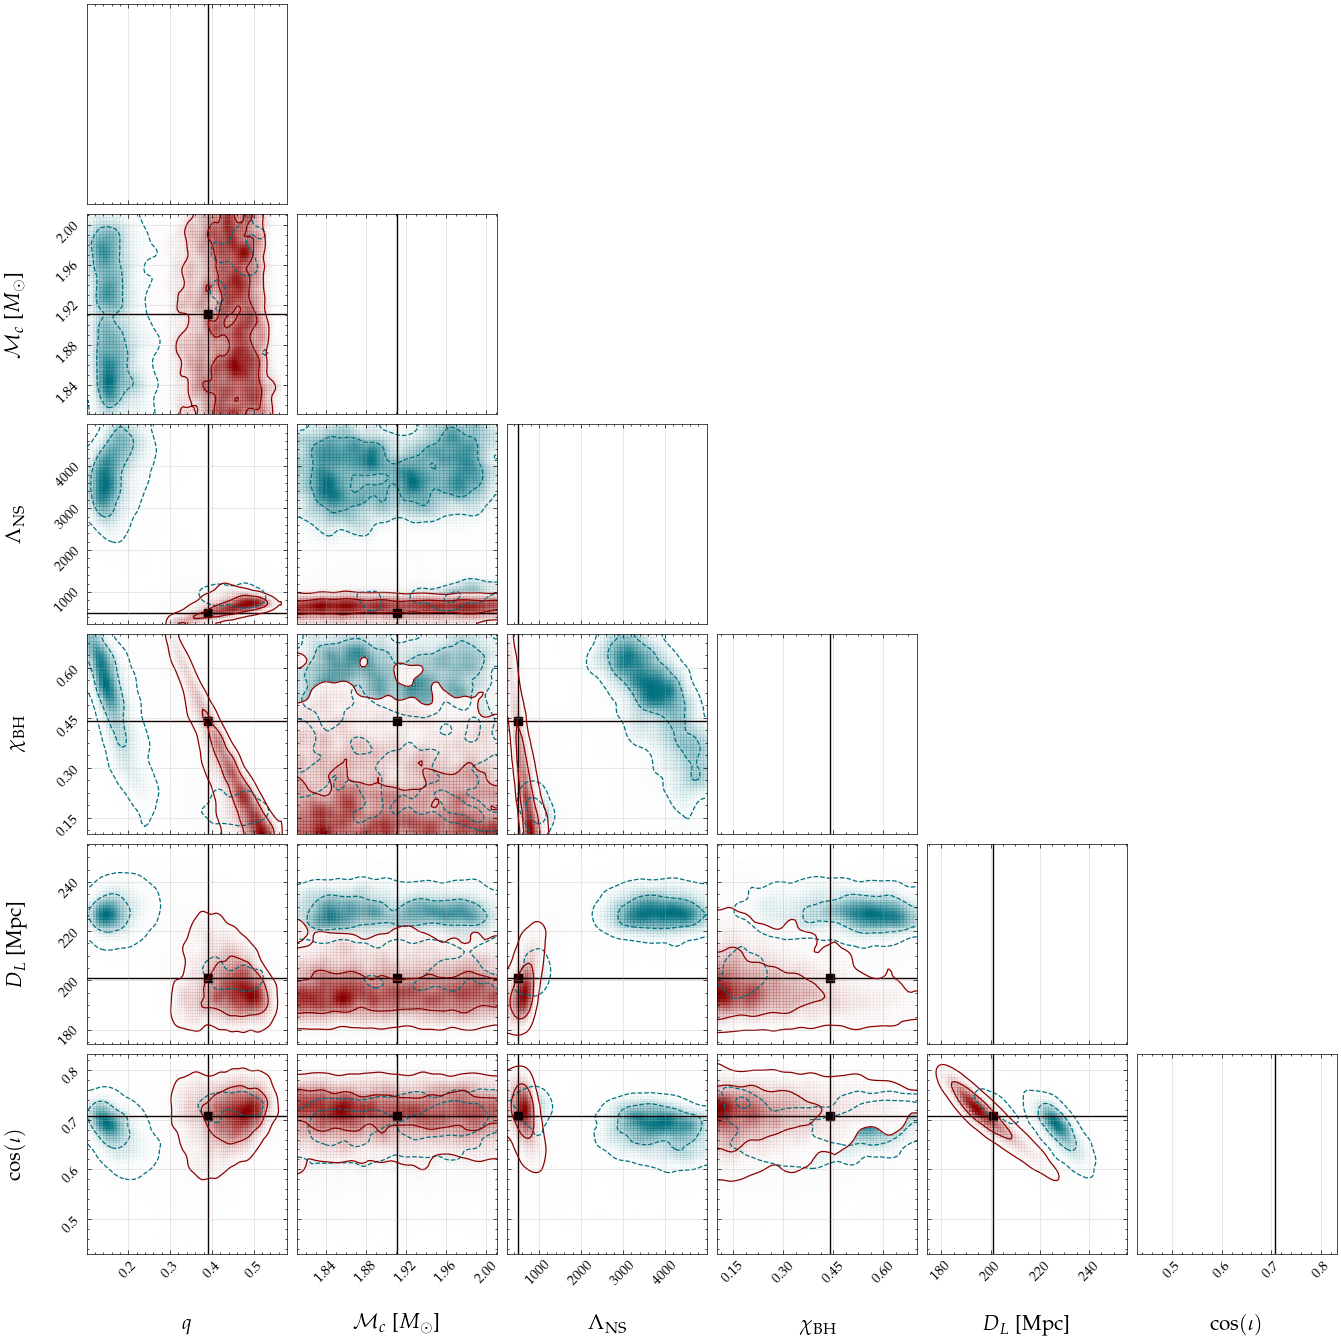

In [4]:
"""
Figure 6.6: Comparison between the different samplers.


The 1D and 2D posterior probability distributions for the component masses of the
source binary of GW230529 along with other NSBH and BNS events.

"""

# load data
label_key = ['errors', 'no_errors']

no_errors_result = bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_5/one_observation_per_day/em_run/', label='em')
errors_result = bilby.result.read_in_result(outdir=f'data/results/case_studies/case_study_5/one_observation_per_day_with_errors/em_run/', label='em')

COLORS_RUNS = {'no_errors'                     : COLORS_DICT['darkred'],
               'errors' : COLORS_DICT['teal']}

LINESTYLE_RUNS = {'no_errors'                      : '-',
                  'errors'  : '--'}

direction  = "in"
smoothing  = 1.8
nbins      = 60

posteriors = ['mass_ratio', 'chirp_mass', 'lambda_2', 'chi_1', 'luminosity_distance', 'cos_theta_jn']
param_labels = [r'$q$', r'$\mathcal{M}_c$ [$M_\odot$]', r'$\Lambda_{\rm NS}$', r'$\chi_{\rm BH}$', '$D_L$ [Mpc]', r'$\cos(\iota)$']
truth_values = [0.39, 1.9102896946252306, 490.32033763361954, 0.44, 201, 0.707]


fig = corner.corner(
    np.array([errors_result.posterior[key] for key in posteriors]).T,
    bins            = nbins,
    labels          = param_labels,
    fill_contours   = False,
    plot_datapoints = False,
    color           = COLORS_RUNS['errors'],
    smooth          = smoothing,
    truths          = truth_values,
    truth_color     = COLORS_DICT["black"],
    levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
    plot_kwargs     = dict(linestyle = "-"),
    hist_kwargs     = {"density": True, "linestyle": '-', "linewidth": 0.0},
    contour_kwargs  = dict(linestyles=LINESTYLE_RUNS['errors'], linewidths=[LINEWIDTHS["curve"]]),
    plot_density    = True,
    labelpad        = -0.05,
)

corner.corner(
    np.array([no_errors_result.posterior[key] for key in posteriors]).T,
    fig             = fig,
    bins            = nbins,
    labels          = param_labels,
    fill_contours   = False,
    plot_datapoints = False,
    color           = COLORS_RUNS['no_errors'],
    smooth          = smoothing,
    levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
    plot_kwargs     = dict(linestyle = LINESTYLE_RUNS['no_errors']),
    hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
    contour_kwargs  = dict(linestyles=LINESTYLE_RUNS['no_errors'], linewidths=[LINEWIDTHS["curve"]]),
    plot_density    = True,
)

# # Evaluate KDE
# kde_mass_ratio              = [gaussian_kde(no_errors_result.posterior["mass_ratio"].to_numpy()), gaussian_kde(errors_result[0])]
# kde_chirp_mass              = [gaussian_kde(no_errors_result.posterior["mass_ratio"].to_numpy()), gaussian_kde(errors_result[1])]
# kde_lambda_2                = [gaussian_kde(no_errors_result.posterior["mass_ratio"].to_numpy()), gaussian_kde(errors_result[3])]
# kde_chi_1                   = [gaussian_kde(no_errors_result.posterior["mass_ratio"].to_numpy()), gaussian_kde(errors_result[2])]
# kde_luminosity_distance     = [gaussian_kde(no_errors_result.posterior["mass_ratio"].to_numpy()), gaussian_kde(errors_result[4])]
# kde_cos_theta_jn            = [gaussian_kde(no_errors_result.posterior["mass_ratio"].to_numpy()), gaussian_kde(errors_result[5])]

# kdes = [kde_mass_ratio, kde_chirp_mass, kde_lambda_2, kde_chi_1, kde_luminosity_distance, kde_cos_theta_jn]
# kdes_ranges = [np.linspace(0.1, 1, 1000), np.linspace(1.8, 2.1, 1000), np.linspace(0, 5000, 1000), 
#                np.linspace(0.1, 0.7, 1000), np.linspace(150, 280, 100),  np.linspace(0.1, 1, 1000)]

# mass_ratio_ticks            = [0.2, 0.4, 0.6, 0.8]
# chirp_mass_ticks            = [1.84, 1.88, 1.92, 1.96]
# lambda_2_ticks              = [625, 1875, 3125, 4375]
# chi_1_ticks                 = [0.175, 0.325, 0.475, 0.625]
# luminosity_distance_ticks   = [170, 195, 220, 245]
# cos_theta_jn_ticks          = [0.4, 0.55, 0.7, 0.85]


# for j, axes in enumerate([0, 7, 14, 21, 28, 35]):
#     for i, label in enumerate(label_key):
#         fig.get_axes()[axes].plot(kdes_ranges[j], kdes[j][i](kdes_ranges[j]), color=COLORS_RUNS[label], linestyle=LINESTYLE_RUNS[label], linewidth=1.1)

# corner.corner(
#             np.array([results_list[i].posterior[key] for key in posteriors]).T,
#             fig             = fig,
#             bins            = nbins,
#             labels          = param_labels,
#             fill_contours   = False,
#             plot_datapoints = False,
#             color           = COLORS_RUNS[label],
#             smooth          = smoothing,
#             truths          = truth_values,
#             truth_color     = COLORS_DICT["black"],
#             levels          = (CONTOUR_LEVELS["mid"], CONTOUR_LEVELS["max"]),
#             plot_kwargs     = dict(linestyle = "-"),
#             hist_kwargs     = {"density": True, "linestyle": "-", "linewidth": 0.0},
#             contour_kwargs  = dict(linestyles=LINESTYLE_RUNS[label], linewidths=[LINEWIDTHS["curve"]]),
#             plot_density    = True,
#             labelpad        = -0.05,
#         )

# # mass_ratio 1D-distribution
# fig.get_axes()[0].set_xticks(mass_ratio_ticks)

# # mass_ratio-lambda_2 2D distribution
# fig.get_axes()[6].set_xticks(mass_ratio_ticks)
# fig.get_axes()[6].set_yticks(chirp_mass_ticks)

# # lambda_2 1D distribution
# fig.get_axes()[7].set_xticks(chirp_mass_ticks)

# # mass_ratio-luminosity_distance 2D distribution
# fig.get_axes()[12].set_xticks(mass_ratio_ticks)
# fig.get_axes()[12].set_yticks(lambda_2_ticks)

# # vdyn-mwind 2D distribution
# fig.get_axes()[13].set_xticks(chirp_mass_ticks)
# fig.get_axes()[13].set_yticks(lambda_2_ticks)

# # mwind 1D distribution
# fig.get_axes()[14].set_xticks(lambda_2_ticks)

# # mass_ratio-luminosity_distance 2D distribution
# fig.get_axes()[18].set_xticks(mass_ratio_ticks)
# fig.get_axes()[18].set_yticks(chi_1_ticks)

# # mass_ratio-luminosity_distance 2D distribution
# fig.get_axes()[19].set_xticks(chirp_mass_ticks)
# fig.get_axes()[19].set_yticks(chi_1_ticks)

# # vdyn-mwind 2D distribution
# fig.get_axes()[20].set_xticks(lambda_2_ticks)
# fig.get_axes()[20].set_yticks(chi_1_ticks)

# # mwind 1D distribution
# fig.get_axes()[21].set_xticks(chi_1_ticks)

# # mass_ratio-luminosity_distance 2D distribution
# fig.get_axes()[24].set_xticks(mass_ratio_ticks)
# fig.get_axes()[24].set_yticks(luminosity_distance_ticks)

# # mass_ratio-luminosity_distance 2D distribution
# fig.get_axes()[25].set_xticks(chirp_mass_ticks)
# fig.get_axes()[25].set_yticks(luminosity_distance_ticks)

# # mass_ratio-luminosity_distance 2D distribution
# fig.get_axes()[26].set_xticks(lambda_2_ticks)
# fig.get_axes()[26].set_yticks(luminosity_distance_ticks)

# # vdyn-mwind 2D distribution
# fig.get_axes()[27].set_xticks(chi_1_ticks)
# fig.get_axes()[27].set_yticks(luminosity_distance_ticks)

# # mwind 1D distribution
# fig.get_axes()[28].set_xticks(luminosity_distance_ticks)

# # mass_ratio-luminosity_distance 2D distribution
# fig.get_axes()[30].set_xticks(mass_ratio_ticks)
# fig.get_axes()[30].set_yticks(cos_theta_jn_ticks)

# # mass_ratio-luminosity_distance 2D distribution
# fig.get_axes()[31].set_xticks(chirp_mass_ticks)
# fig.get_axes()[31].set_yticks(cos_theta_jn_ticks)

# # mass_ratio-luminosity_distance 2D distribution
# fig.get_axes()[32].set_xticks(lambda_2_ticks)
# fig.get_axes()[32].set_yticks(cos_theta_jn_ticks)

# # vdyn-mwind 2D distribution
# fig.get_axes()[33].set_xticks(chi_1_ticks)
# fig.get_axes()[33].set_yticks(cos_theta_jn_ticks)

# # vdyn-mwind 2D distribution
# fig.get_axes()[34].set_xticks(luminosity_distance_ticks)
# fig.get_axes()[34].set_yticks(cos_theta_jn_ticks)

# # mwind 1D distribution
# fig.get_axes()[35].set_xticks(cos_theta_jn_ticks)

# # Tune x and y limits
# mass_ratio_min, mass_ratio_max                       = 0.1, 0.9
# chirp_mass_min, chirp_mass_max                       = 1.82, 1.98
# lambda_2_min, lambda_2_max                           = 0, 5000
# chi_1_min, chi_1_max                                 = 0.1, 0.7
# luminosity_distance_min, luminosity_distance_max     = 170 - 12.5, 245 + 12.5
# cos_theta_jn_min, cos_theta_jn_max                   = 0.4 - 0.075, 0.85 + 0.075

# # mass_ratio 1D-distribution
# fig.get_axes()[0].set_xlim([mass_ratio_min, mass_ratio_max])

# # mass_ratio-lambda_2 2D distribution
# fig.get_axes()[6].set_xlim([mass_ratio_min, mass_ratio_max])
# fig.get_axes()[6].set_ylim([chirp_mass_min, chirp_mass_max])

# # lambda_2 1D distribution
# fig.get_axes()[7].set_xlim([chirp_mass_min, chirp_mass_max])

# # mass_ratio-luminosity_distance 2D distribution
# fig.get_axes()[12].set_xlim([mass_ratio_min, mass_ratio_max])
# fig.get_axes()[12].set_ylim([lambda_2_min, lambda_2_max])

# # vdyn-mwind 2D distribution
# fig.get_axes()[13].set_xlim([chirp_mass_min, chirp_mass_max])
# fig.get_axes()[13].set_ylim([lambda_2_min, lambda_2_max])

# # mwind 1D distribution
# fig.get_axes()[14].set_xlim([lambda_2_min, lambda_2_max])

# # mass_ratio-luminosity_distance 2D distribution
# fig.get_axes()[18].set_xlim([mass_ratio_min, mass_ratio_max])
# fig.get_axes()[18].set_ylim([chi_1_min, chi_1_max])

# # mass_ratio-luminosity_distance 2D distribution
# fig.get_axes()[19].set_xlim([chirp_mass_min, chirp_mass_max])
# fig.get_axes()[19].set_ylim([chi_1_min, chi_1_max])

# # vdyn-mwind 2D distribution
# fig.get_axes()[20].set_xlim([lambda_2_min, lambda_2_max])
# fig.get_axes()[20].set_ylim([chi_1_min, chi_1_max])

# # mwind 1D distribution
# fig.get_axes()[21].set_xlim([chi_1_min, chi_1_max])

# # mass_ratio-luminosity_distance 2D distribution
# fig.get_axes()[24].set_xlim([mass_ratio_min, mass_ratio_max])
# fig.get_axes()[24].set_ylim([luminosity_distance_min, luminosity_distance_max])

# # mass_ratio-luminosity_distance 2D distribution
# fig.get_axes()[25].set_xlim([chirp_mass_min, chirp_mass_max])
# fig.get_axes()[25].set_ylim([luminosity_distance_min, luminosity_distance_max])

# # mass_ratio-luminosity_distance 2D distribution
# fig.get_axes()[26].set_xlim([lambda_2_min, lambda_2_max])
# fig.get_axes()[26].set_ylim([luminosity_distance_min, luminosity_distance_max])

# # vdyn-mwind 2D distribution
# fig.get_axes()[27].set_xlim([chi_1_min, chi_1_max])
# fig.get_axes()[27].set_ylim([luminosity_distance_min, luminosity_distance_max])

# # mwind 1D distribution
# fig.get_axes()[28].set_xlim([luminosity_distance_min, luminosity_distance_max])

# # mass_ratio-luminosity_distance 2D distribution
# fig.get_axes()[30].set_xlim([mass_ratio_min, mass_ratio_max])
# fig.get_axes()[30].set_ylim([cos_theta_jn_min, cos_theta_jn_max])

# # mass_ratio-luminosity_distance 2D distribution
# fig.get_axes()[31].set_xlim([chirp_mass_min, chirp_mass_max])
# fig.get_axes()[31].set_ylim([cos_theta_jn_min, cos_theta_jn_max])

# # mass_ratio-luminosity_distance 2D distribution
# fig.get_axes()[32].set_xlim([lambda_2_min, lambda_2_max])
# fig.get_axes()[32].set_ylim([cos_theta_jn_min, cos_theta_jn_max])

# # vdyn-mwind 2D distribution
# fig.get_axes()[33].set_xlim([chi_1_min, chi_1_max])
# fig.get_axes()[33].set_ylim([cos_theta_jn_min, cos_theta_jn_max])

# # vdyn-mwind 2D distribution
# fig.get_axes()[34].set_xlim([luminosity_distance_min, luminosity_distance_max])
# fig.get_axes()[34].set_ylim([cos_theta_jn_min, cos_theta_jn_max])

# # mwind 1D distribution
# fig.get_axes()[35].set_xlim([cos_theta_jn_min, cos_theta_jn_max])

# labels_legend = ['Andreoni et al. 2022',
#                  'Andreoni et al. 2022\n $+ t = 6.5$ d.', 
#                  'Andreoni et al. 2022\n\t $- t = 0.04$ d.',
#                  'Andreoni et al. 2022\n\t $+ t = 6.5$ d., $- t = 0.04$ d.',
#                  ]

# labels = ['andreoni_preferred_strategy', 'andreoni_preferred_strategy_with_late_time_obs',
#           'andreoni_preferred_strategy_without_early_times', 'andreoni_preferred_strategy_without_early_times_with_late_time_obs']

# handles = [Line2D([], [], color=COLORS_RUNS[key], ls=LINESTYLE_RUNS[key]) for key in labels]
# legend = plt.legend(handles, labels_legend, loc=(-0.90, 4.97), fontsize=20)
# for i in legend.legend_handles:
#     i.set_linewidth(3)

# matplotlib.rcParams['axes.formatter.useoffset'] = False

# fig.savefig(results_case_studies_dir + "case_study_1/em_corner_plot_andreoni_comparison.pdf")
# fig.savefig(results_case_studies_dir + "case_study_1/em_corner_plot_andreoni_comparison.png")

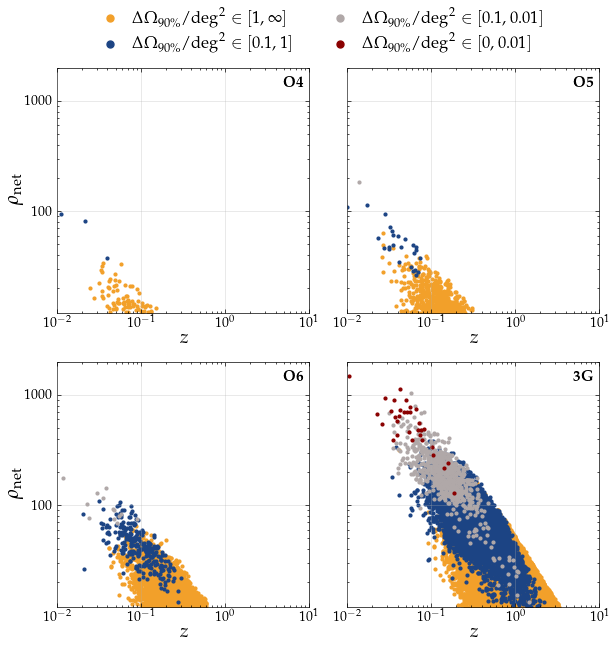

In [4]:
import shelve 
import pandas as pd

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 7), sharey=True)
plt.subplots_adjust(wspace=0.15)

O4_dataframe_10yr = [pd.read_csv(f'data/results/population_studies/population_injections/O4/2_analysed_results_network=O4_t=1yr_snr=12_{i}.txt') for i in range(10)]
O5_dataframe_10yr = [pd.read_csv(f'data/results/population_studies/population_injections/O5/2_analysed_results_network=O5_t=1yr_snr=12_{i}.txt') for i in range(10)]
O6_dataframe_10yr = [pd.concat([pd.read_csv(f'data/results/population_studies/population_injections/O6/folder_{j}/2_analysed_results_network=O6_snr=12_batch_number={i}.txt') for i in range(7)]) for j in range(10)]
G3_dataframe_10yr = [pd.concat([pd.read_csv(f'data/results/population_studies/population_injections/3G/folder_{j}/2_analysed_results_network=3G_snr=12_batch_number={i}.txt') for i in range(12)]) for j in range(10)]

O4_dataframe_1yr = O4_dataframe_10yr[1]
O5_dataframe_1yr = O5_dataframe_10yr[0]
O6_dataframe_1yr = O6_dataframe_10yr[0]
G3_dataframe_1yr = G3_dataframe_10yr[0]

sky_err_slices = reversed([[0, 0.01], [0.01, 0.1], [0.1, 1], [1, np.inf]])
colors = list(reversed([COLORS_DICT['darkred'], COLORS_DICT['gray'], COLORS_DICT['navy'], COLORS_DICT['orange']]))

for i, sky_loc_slice in enumerate(sky_err_slices):

    for j, dataframe in enumerate([pd.concat(O4_dataframe_10yr), pd.concat(O5_dataframe_10yr), pd.concat(O6_dataframe_10yr), pd.concat(G3_dataframe_10yr)]):

        index = np.argwhere((dataframe['err_sky_location_90'] > sky_loc_slice[0]) & (dataframe['err_sky_location_90'] < sky_loc_slice[1]) & (np.abs(np.cos(dataframe['theta_jn'])) < 0.99))
        fig.axes[j].plot(dataframe['redshift'].to_numpy()[index], dataframe['network_SNR'].to_numpy()[index], 'o', markersize=2, color=colors[i])
        fig.axes[j].set_yscale("log")
        fig.axes[j].set_xscale("log")
        fig.axes[j].set_xlim(1e-2, 10)
        fig.axes[j].set_ylim(12, 2000)
        fig.axes[j].set_xlabel('$z$', fontsize=14, labelpad=-2)

        if j % 2 == 0:
            fig.axes[j].set_ylabel(r'$\rho_{\rm net}$', fontsize=14, labelpad=-0.1)


handles = [Line2D([0], [0], color=COLORS_DICT["orange"], marker='o', linestyle='None',  markersize=5), 
           Line2D([], [], color=COLORS_DICT["navy"], marker='o', linestyle='None', markersize=5),
           Line2D([], [], color=COLORS_DICT["gray"], marker='o', linestyle='None', markersize=5),
           Line2D([], [], color=COLORS_DICT["darkred"], marker='o', linestyle='None', markersize=5),
           ]

labels = [r"$\Delta\Omega_{90\%} / \text{deg}^2 \in [1, \infty]$", 
          r"$\Delta\Omega_{90\%} / \text{deg}^2 \in [0.1, 1]$",
          r"$\Delta\Omega_{90\%} / \text{deg}^2 \in [0.1, 0.01]$",
          r"$\Delta\Omega_{90\%} / \text{deg}^2 \in [0, 0.01]$"]

fig.axes[0].annotate(r"\textbf{O4}",
        xy=(0.895, 0.925), 
        xycoords='axes fraction',
        size=11,
        weight='black',
        bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

fig.axes[1].annotate(r"\textbf{O5}",
        xy=(0.895, 0.925), 
        xycoords='axes fraction',
        size=11,
        weight='black',
        bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

fig.axes[2].annotate(r"\textbf{O6}",
        xy=(0.895, 0.925), 
        xycoords='axes fraction',
        size=11,
        weight='black',
        bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

fig.axes[3].annotate(r"\textbf{3G}",
        xy=(0.895, 0.925), 
        xycoords='axes fraction',
        size=11,
        weight='black',
        bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

legend = plt.legend(handles, labels, loc=(-1,2.25), fontsize=14, numpoints=1, ncol=2, prop={'size': 12})

fig.savefig(results_population_dir + "redshift_snr_10yr.pdf")
fig.savefig(results_population_dir + "redshift_snr_10yr.png")

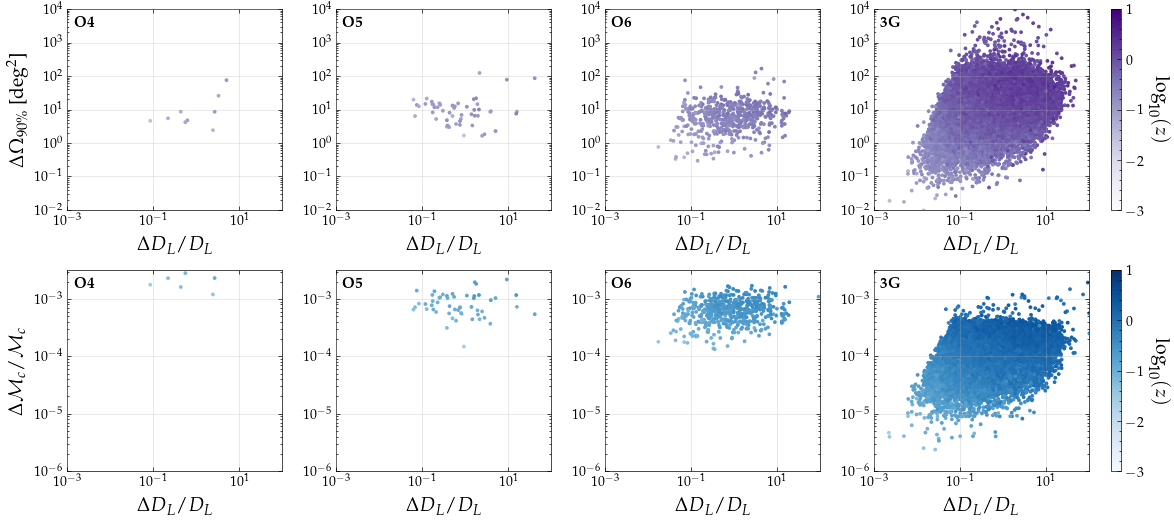

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14.5, 6))
plt.subplots_adjust(wspace=0.25, hspace=0.3)

norm = matplotlib.colors.Normalize(vmin=np.log10(float(1e-3)), 
                                    vmax=np.log10(float(10)))
cmap = plt.cm.Purples
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

for j, dataframe in enumerate([O4_dataframe_1yr, O5_dataframe_1yr, O6_dataframe_1yr, G3_dataframe_1yr]):

        index = np.argwhere(np.abs(np.cos(dataframe['theta_jn'])) < 0.99)

        fig.axes[j].scatter(dataframe['err_luminosity_distance'].to_numpy()[index].flatten() / dataframe['luminosity_distance'].to_numpy()[index].flatten(), 
                        dataframe['err_sky_location_90'].to_numpy()[index], s=3,
                        c=cmap(norm(np.log10(dataframe['redshift'].to_numpy()[index]).flatten())))
        fig.axes[j].set_yscale("log")
        fig.axes[j].set_xscale("log")
        fig.axes[j].set_xlim(1e-3, 1e2)
        fig.axes[j].set_ylim(1e-2, 1e4)
        fig.axes[j].set_xlabel('$\Delta D_L / D_L$', fontsize=14)

fig.axes[0].set_ylabel('$\Delta \Omega_{90\%}$ [deg$^2$]', fontsize=14)

colorbar = fig.colorbar(sm,  ax=[fig.axes[i] for i in range(4)], fraction=0.071, pad=0.02, ticks=[-3, -2, -1, 0, 1 ])
colorbar.set_label(r'$\log_{10}(z)$', rotation=270, fontsize=14)
colorbar.ax.get_yaxis().labelpad = 18

norm = matplotlib.colors.Normalize(vmin=np.log10(float(1e-3)), 
                                    vmax=np.log10(float(10)))
cmap = plt.cm.Blues
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

for j, dataframe in enumerate([O4_dataframe_1yr, O5_dataframe_1yr, O6_dataframe_1yr, G3_dataframe_1yr]):

        index = np.argwhere(np.abs(np.cos(dataframe['theta_jn'])) < 0.99)

        fig.axes[j + 4].scatter(dataframe['err_luminosity_distance'].to_numpy()[index].flatten() / dataframe['luminosity_distance'].to_numpy()[index].flatten(), 
                        dataframe['err_chirp_mass'].to_numpy()[index].flatten() / dataframe['chirp_mass'].to_numpy()[index].flatten(), s=3,
                        c=cmap(norm(np.log10(dataframe['redshift'].to_numpy()[index]).flatten())))
        fig.axes[j + 4].set_yscale("log")
        fig.axes[j + 4].set_xscale("log")
        fig.axes[j + 4].set_xlim(1e-3, 1e2)
        fig.axes[j + 4].set_ylim(1e-6, 10**-2.5)
        fig.axes[j + 4].set_xlabel('$\Delta D_L / D_L$', fontsize=14)

fig.axes[4].set_ylabel('$\Delta \mathcal{M}_c / \mathcal{M}_c$', fontsize=14)

colorbar = fig.colorbar(sm,  ax=[fig.axes[i] for i in range(4, 8)], fraction=0.071, pad=0.02, ticks=[-3, -2, -1, 0, 1 ])
colorbar.set_label(r'$\log_{10}(z)$', rotation=270, fontsize=14)
colorbar.ax.get_yaxis().labelpad = 18

for i in range(2):
        fig.axes[0 + (i * 4)].annotate(r"\textbf{O4}",
                xy=(0.03, 0.915), 
                xycoords='axes fraction',
                size=11,
                weight='black',
                bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

        fig.axes[1 + (i * 4)].annotate(r"\textbf{O5}",
                xy=(0.03, 0.915), 
                xycoords='axes fraction',
                size=11,
                weight='black',
                bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

        fig.axes[2 + (i * 4)].annotate(r"\textbf{O6}",
                xy=(0.03, 0.915), 
                xycoords='axes fraction',
                size=11,
                weight='black',
                bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))
        
        fig.axes[3 + (i * 4)].annotate(r"\textbf{3G}",
                xy=(0.03, 0.915), 
                xycoords='axes fraction',
                size=11,
                weight='black',
                bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

fig.savefig(results_population_dir + "err_luminosity_err_sky_loc_err_chirp_mass_1yr.pdf")
fig.savefig(results_population_dir + "err_luminosity_err_sky_loc_err_chirp_mass_1yr.png")

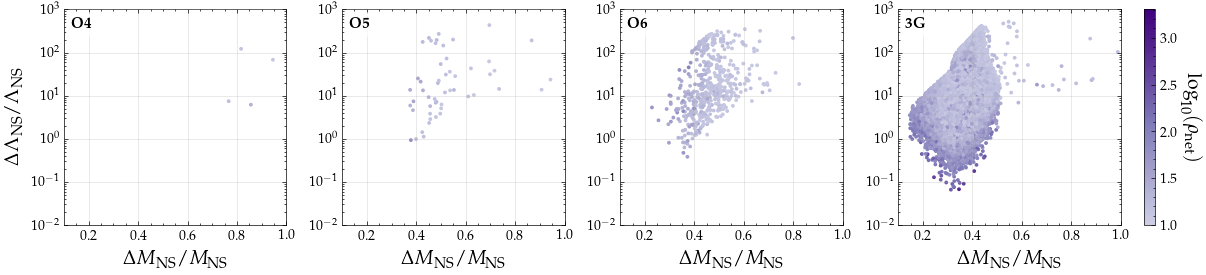

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 2.8))
plt.subplots_adjust(wspace=0.25)

norm = matplotlib.colors.Normalize(vmin=np.log10(float(1)), 
                                    vmax=np.log10(float(2000)))
cmap = plt.cm.Purples
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

for j, dataframe in enumerate([O4_dataframe_1yr, O5_dataframe_1yr, O6_dataframe_1yr, G3_dataframe_1yr]):

        index = np.argwhere(np.abs(np.cos(dataframe['theta_jn'])) < 0.99)

        fig.axes[j].scatter(dataframe['err_mass_2'].to_numpy()[index].flatten() / dataframe['mass_2'].to_numpy()[index].flatten(), 
                            dataframe['err_lambda_2'].to_numpy()[index].flatten() / dataframe['lambda_2'].to_numpy()[index].flatten(), s=3,
                            c=cmap(norm(np.log10(dataframe['network_SNR'].to_numpy()[index]).flatten())))
        fig.axes[j].set_yscale("log")
        fig.axes[j].set_xlim(0.1, 1)
        fig.axes[j].set_ylim(1e-2, 1e3)
        fig.axes[j].set_xlabel(r'$\Delta M_{\rm NS} / M_{\rm NS}$', fontsize=14)

fig.axes[0].set_ylabel(r'$\Delta \Lambda_{\rm NS} / \Lambda_{\rm NS}$', fontsize=14)

colorbar = fig.colorbar(sm,  ax=[fig.axes[i] for i in range(4)], fraction=0.071, pad=0.02)
colorbar.set_label(r'$\log_{10}(\rho_{\rm net})$', rotation=270, fontsize=14)
colorbar.ax.get_yaxis().labelpad = 18
colorbar.ax.set_ylim(1)


for i in range(1):
        fig.axes[0 + (i * 4)].annotate(r"\textbf{O4}",
                xy=(0.03, 0.915), 
                xycoords='axes fraction',
                size=11,
                weight='black',
                bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

        fig.axes[1 + (i * 4)].annotate(r"\textbf{O5}",
                xy=(0.03, 0.915), 
                xycoords='axes fraction',
                size=11,
                weight='black',
                bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

        fig.axes[2 + (i * 4)].annotate(r"\textbf{O6}",
                xy=(0.03, 0.915), 
                xycoords='axes fraction',
                size=11,
                weight='black',
                bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))
        
        fig.axes[3 + (i * 4)].annotate(r"\textbf{3G}",
                xy=(0.03, 0.915), 
                xycoords='axes fraction',
                size=11,
                weight='black',
                bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

fig.savefig(results_population_dir + "err_lambda2_err_mass2_1yr.pdf")
fig.savefig(results_population_dir + "err_lambda2_err_mass2_1yr.png")

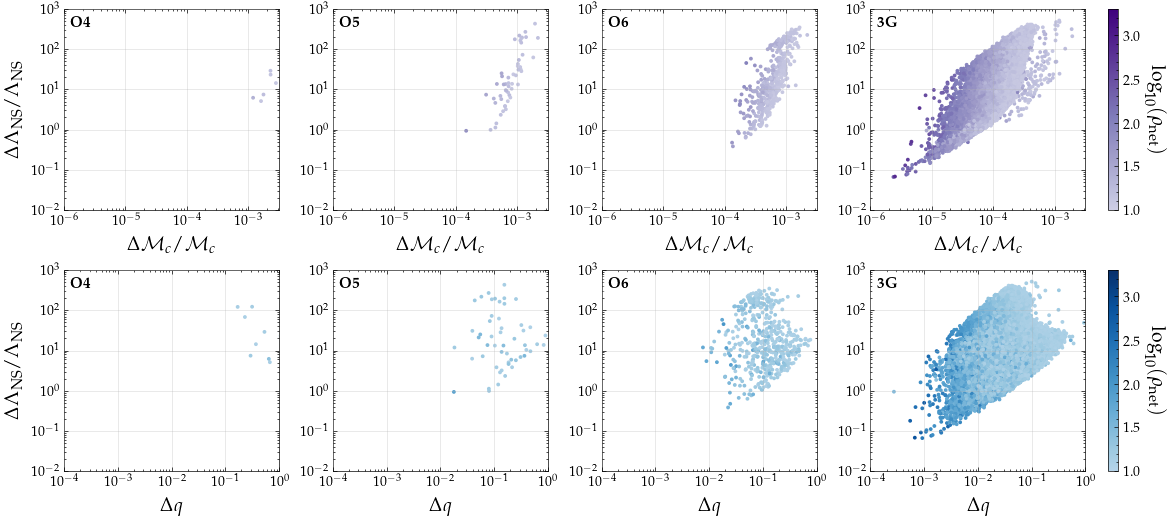

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14.5, 6))
plt.subplots_adjust(wspace=0.25, hspace=0.3)

norm = matplotlib.colors.Normalize(vmin=np.log10(float(1)), 
                                    vmax=np.log10(float(2000)))
cmap = plt.cm.Purples
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

for j, dataframe in enumerate([O4_dataframe_1yr, O5_dataframe_1yr, O6_dataframe_1yr, G3_dataframe_1yr]):

        index = np.argwhere(np.abs(np.cos(dataframe['theta_jn'])) < 0.99)

        fig.axes[j].scatter(dataframe['err_chirp_mass'].to_numpy()[index].flatten() / dataframe['chirp_mass'].to_numpy()[index].flatten(), 
                            dataframe['err_lambda_2'].to_numpy()[index].flatten() / dataframe['lambda_2'].to_numpy()[index].flatten(), s=3,
                            c=cmap(norm(np.log10(dataframe['network_SNR'].to_numpy()[index]).flatten())))
        fig.axes[j].set_yscale("log")
        fig.axes[j].set_xscale("log")
        fig.axes[j].set_xlim(1e-6, 10**-2.5)
        fig.axes[j].set_ylim(1e-2, 10**3)
        fig.axes[j].set_xlabel(r'$\Delta \mathcal{M}_c / \mathcal{M}_c$', fontsize=14)

fig.axes[0].set_ylabel(r'$\Delta \Lambda_{\rm NS} / \Lambda_{\rm NS}$', fontsize=14)

colorbar = fig.colorbar(sm,  ax=[fig.axes[i] for i in range(4)], fraction=0.071, pad=0.02)
colorbar.set_label(r'$\log_{10}(\rho_{\rm net})$', rotation=270, fontsize=14)
colorbar.ax.get_yaxis().labelpad = 18
colorbar.ax.set_ylim(1)

norm = matplotlib.colors.Normalize(vmin=np.log10(float(1)), 
                                    vmax=np.log10(float(2000)))
cmap = plt.cm.Blues
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

for j, dataframe in enumerate([O4_dataframe_1yr, O5_dataframe_1yr, O6_dataframe_1yr, G3_dataframe_1yr]):

        index = np.argwhere(np.abs(np.cos(dataframe['theta_jn'])) < 0.99)

        fig.axes[j + 4].scatter(dataframe['err_mass_ratio'].to_numpy()[index].flatten(), 
                            dataframe['err_lambda_2'].to_numpy()[index].flatten() / dataframe['lambda_2'].to_numpy()[index].flatten(), s=3,
                            c=cmap(norm(np.log10(dataframe['network_SNR'].to_numpy()[index]).flatten())))
        fig.axes[j + 4].set_yscale("log")
        fig.axes[j + 4].set_xscale("log")
        fig.axes[j + 4].set_xlim(1e-4, 1)
        fig.axes[j + 4].set_ylim(1e-2, 10**3)
        fig.axes[j + 4].set_xlabel('$\Delta q$', fontsize=14)

fig.axes[4].set_ylabel(r'$\Delta \Lambda_{\rm NS} / \Lambda_{\rm NS}$', fontsize=14)

colorbar = fig.colorbar(sm,  ax=[fig.axes[i] for i in range(4, 8)], fraction=0.071, pad=0.02)
colorbar.set_label(r'$\log_{10}(\rho_{\rm net})$', rotation=270, fontsize=14)
colorbar.ax.get_yaxis().labelpad = 18
colorbar.ax.set_ylim(1)

for i in range(2):
        fig.axes[0 + (i * 4)].annotate(r"\textbf{O4}",
                xy=(0.03, 0.915), 
                xycoords='axes fraction',
                size=11,
                weight='black',
                bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

        fig.axes[1 + (i * 4)].annotate(r"\textbf{O5}",
                xy=(0.03, 0.915), 
                xycoords='axes fraction',
                size=11,
                weight='black',
                bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

        fig.axes[2 + (i * 4)].annotate(r"\textbf{O6}",
                xy=(0.03, 0.915), 
                xycoords='axes fraction',
                size=11,
                weight='black',
                bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))
        
        fig.axes[3 + (i * 4)].annotate(r"\textbf{3G}",
                xy=(0.03, 0.915), 
                xycoords='axes fraction',
                size=11,
                weight='black',
                bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none", alpha=0.7))

fig.savefig(results_population_dir + "err_chirp_err_lambda2_err_q_1yr.png")
fig.savefig(results_population_dir + "err_chirp_err_lambda2_err_q_1yr.pdf")

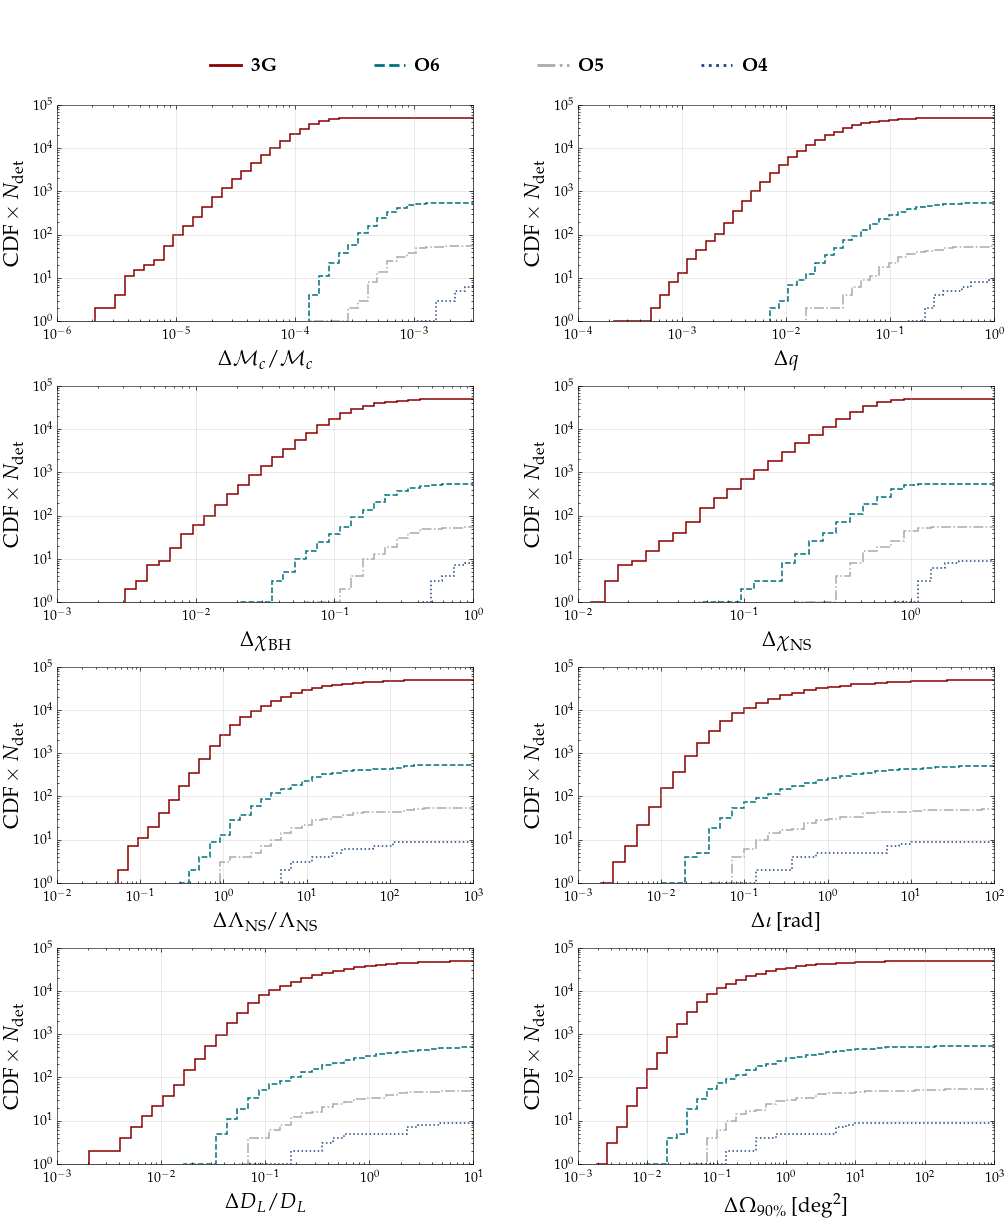

In [7]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(11 * 1.1, 11 * 1.25))
plt.subplots_adjust(wspace=0.25, hspace=0.3)

color = [COLORS_DICT['navy'], COLORS_DICT['gray'], COLORS_DICT['teal'], COLORS_DICT['darkred']]
linestyle = [':', '-.', '--', '-']

for j, dataframe in enumerate([O4_dataframe_1yr, O5_dataframe_1yr, O6_dataframe_1yr, G3_dataframe_1yr]):
    fig.axes[0].hist(dataframe['err_chirp_mass'] / dataframe['chirp_mass'], density=False, histtype='step', cumulative=True,  
                     bins=np.logspace(np.log10(1e-6),np.log10(10**-2), 50), linestyle=linestyle[j], color=color[j], linewidth=1.1)
    fig.axes[0].set_xlim(1e-6, 10**-2.5)
    fig.axes[0].set_ylim(1, 10**5)
    fig.axes[0].set_xscale('log')
    fig.axes[0].set_yscale('log')
    fig.axes[0].set_ylabel(r'$\text{CDF} \times N_{\rm det}$')
    fig.axes[0].set_xlabel(r'$\Delta \mathcal{M}_c / \mathcal{M}_c$')
    fig.axes[0].tick_params(axis='x', which='major', pad=6)

    fig.axes[1].hist(dataframe['err_mass_ratio'], density=False, histtype='step', cumulative=True,  
                     bins=np.logspace(np.log10(1e-4),np.log10(2), 50), linestyle=linestyle[j], color=color[j], linewidth=1.1)
    fig.axes[1].set_xlim(1e-4, 10**0)
    fig.axes[1].set_ylim(1, 10**5)
    fig.axes[1].set_xscale('log')
    fig.axes[1].set_yscale('log')
    fig.axes[1].set_ylabel(r'$\text{CDF} \times N_{\rm det}$')
    fig.axes[1].set_xlabel(r'$\Delta q$')
    fig.axes[1].tick_params(axis='x', which='major', pad=6)
    
    fig.axes[2].hist(dataframe['err_a_1'], density=False, histtype='step', cumulative=True,  
                     bins=np.logspace(np.log10(1e-3), np.log10(10), 50), linestyle=linestyle[j], color=color[j], linewidth=1.1)
    fig.axes[2].set_xlim(1e-3, 10**0)
    fig.axes[2].set_ylim(1, 10**5)
    fig.axes[2].set_xscale('log')
    fig.axes[2].set_yscale('log')
    fig.axes[2].set_ylabel(r'$\text{CDF} \times N_{\rm det}$')
    fig.axes[2].set_xlabel(r'$\Delta \chi_{\rm BH}$')
    fig.axes[2].tick_params(axis='x', which='major', pad=6)

    fig.axes[3].hist(dataframe['err_a_2'], density=False, histtype='step', cumulative=True,  
                     bins=np.logspace(np.log10(1e-2), np.log10(100), 50), linestyle=linestyle[j], color=color[j], linewidth=1.1)
    fig.axes[3].set_xlim(1e-2, 10**0.5)
    fig.axes[3].set_ylim(1, 10**5)
    fig.axes[3].set_xscale('log')
    fig.axes[3].set_yscale('log')
    fig.axes[3].set_ylabel(r'$\text{CDF} \times N_{\rm det}$')
    fig.axes[3].set_xlabel(r'$\Delta \chi_{\rm NS}$')
    fig.axes[3].tick_params(axis='x', which='major', pad=6)


    fig.axes[4].hist(dataframe['err_lambda_2'] / dataframe['lambda_2'], density=False, histtype='step', cumulative=True,  
                     bins=np.logspace(np.log10(1e-2), np.log10(1e4), 50), linestyle=linestyle[j], color=color[j], linewidth=1.1)
    fig.axes[4].set_xlim(1e-2, 1e3)
    fig.axes[4].set_ylim(1, 10**5)
    fig.axes[4].set_xscale('log')
    fig.axes[4].set_yscale('log')
    fig.axes[4].set_ylabel(r'$\text{CDF} \times N_{\rm det}$')
    fig.axes[4].set_xlabel(r'$\Delta \Lambda_{\rm NS} / \Lambda_{\rm NS}$')
    fig.axes[4].tick_params(axis='x', which='major', pad=6)

    fig.axes[5].hist(dataframe['err_theta_jn'], density=False, histtype='step', cumulative=True,  
                     bins=np.logspace(np.log10(1e-4), np.log10(1e3), 50), linestyle=linestyle[j], color=color[j], linewidth=1.1)
    fig.axes[5].set_xlim(1e-3, 1e2)
    fig.axes[5].set_ylim(1, 10**5)
    fig.axes[5].set_xscale('log')
    fig.axes[5].set_yscale('log')
    fig.axes[5].set_ylabel(r'$\text{CDF} \times N_{\rm det}$')
    fig.axes[5].set_xlabel(r'$\Delta \iota$ [rad]')
    fig.axes[5].tick_params(axis='x', which='major', pad=6)

    fig.axes[6].hist(dataframe['err_luminosity_distance'] / dataframe['luminosity_distance'], density=False, histtype='step', cumulative=True,  
                     bins=np.logspace(np.log10(1e-3), np.log10(1e2), 50), linestyle=linestyle[j], color=color[j], linewidth=1.1)
    fig.axes[6].set_xlim(1e-3, 1e1)
    fig.axes[6].set_ylim(1, 10**5)
    fig.axes[6].set_xscale('log')
    fig.axes[6].set_yscale('log')
    fig.axes[6].set_ylabel(r'$\text{CDF} \times N_{\rm det}$')
    fig.axes[6].set_xlabel(r'$\Delta D_L / D_L$')
    fig.axes[6].tick_params(axis='x', which='major', pad=6)

    fig.axes[7].hist(dataframe['err_theta_jn'], density=False, histtype='step', cumulative=True,  
                     bins=np.logspace(np.log10(1e-3), np.log10(1e4), 50), linestyle=linestyle[j], color=color[j], linewidth=1.1)
    fig.axes[7].set_xlim(1e-3, 1e3)
    fig.axes[7].set_ylim(1, 10**5)
    fig.axes[7].set_xscale('log')
    fig.axes[7].set_yscale('log')
    fig.axes[7].set_ylabel(r'$\text{CDF} \times N_{\rm det}$')
    fig.axes[7].set_xlabel(r'$\Delta \Omega_{90\%}$ [deg$^2$]')
    fig.axes[7].tick_params(axis='x', which='major', pad=6)

handles = reversed([Line2D([], [], color=COLORS_DICT["navy"], linestyle=':'), 
           Line2D([], [], color=COLORS_DICT["gray"], linestyle='-.'),
           Line2D([], [], color=COLORS_DICT["teal"], linestyle='--'),
           Line2D([], [], color=COLORS_DICT["darkred"], linestyle='-'),
           ])

labels = [r"$\textbf{3G}$", 
          r"\textbf{O6}",
          r"\textbf{O5}",
          r"\textbf{O4}"]

legend = fig.legend(handles, labels, loc=(0.205, 0.935), fontsize=14, numpoints=1, ncol=4, columnspacing=5)
for i in legend.legend_handles:
    i.set_linewidth(2)

fig.savefig(results_population_dir + "hist_fundamental_parameters.png")
fig.savefig(results_population_dir + "hist_fundamental_parameters.pdf")

In [1]:
fig, ax = plt.subplots(figsize=[7, (4 / 7) * 8])

color = list(reversed([COLORS_DICT['orange'], COLORS_DICT['gray'], COLORS_DICT['teal'], COLORS_DICT['darkred']]))

for j, dataframe in enumerate(reversed([pd.concat(O4_dataframe_10yr), pd.concat(O5_dataframe_10yr), pd.concat(O6_dataframe_10yr), pd.concat(G3_dataframe_10yr)])):
    ax.plot(dataframe['err_sky_location_90'], dataframe['peak_r_band'], 'o', color=color[j], markersize=2)
    ax.set_xlim(1e-3, 1e3)
    ax.set_ylim(18, 38)
    ax.set_xscale('log')
    ax.vlines([9.6, 96], ymin=18, ymax=38, linestyle='--', color='black', linewidth=0.5)
    ax.vlines([47, 470], ymin=18, ymax=38, linestyle='-.', color='black', linewidth=0.5)

    ax.hlines([25.372689062979553], xmin=1e-3, xmax=1e3, linestyle='--', color='black', linewidth=0.5)
    ax.hlines([21.85], xmin=1e-3, xmax=1e3, linestyle='-.', color='black', linewidth=0.5)

ax.set_xlabel(r'$\Delta \Omega_{90\%}$ [deg$^2$]', fontsize=13)
ax.set_ylabel(r'Peak AB magnitude', fontsize=13)

ax.annotate(r"\textbf{ZTF} ($r-\text{filter}$) $m_{\rm lim}$",
                xy=(10**-2.93, 21.67), 
                xycoords='data',
                size=8,
                weight='black')

ax.annotate(r"\textbf{LSST} ($r-\text{filter}$) $m_{\rm lim}$",
                xy=(10**-2.93, 25.372689062979553 - 0.18), 
                xycoords='data',
                size=8,
                weight='black')

ax.annotate(r"$\textbf{LSST} - \text{FOV}$",
                xy=(9.9, 21.5), 
                xycoords='data',
                size=8,
                weight='black',
                rotation=-90)

ax.annotate(r"$\textbf{ZTF} - \text{FOV}$",
                xy=(47.4, 21.5), 
                xycoords='data',
                size=8,
                weight='black',
                rotation=-90)

ax.annotate(r"$\textbf{LSST} - 10 \times \text{FOV}$",
                xy=(100.4, 37.5), 
                xycoords='data',
                size=8,
                weight='black',
                rotation=-90)

ax.annotate(r"$\textbf{ZTF} - 10 \times \text{FOV}$",
                xy=(500, 37.5), 
                xycoords='data',
                size=8,
                weight='black',
                rotation=-90)

plt.gca().invert_yaxis()

ax.set_yticks([38, 34, 30, 26, 22, 18])

labels = [r"$\textbf{3G}$", 
          r"\textbf{O6}",
          r"\textbf{O5}",
          r"\textbf{O4}"]

handles = reversed([Line2D([], [], color=COLORS_DICT["orange"], marker='o', linestyle='None',  markersize=4), 
           Line2D([], [], color=COLORS_DICT["gray"], marker='o', linestyle='None',  markersize=4),
           Line2D([], [], color=COLORS_DICT["teal"], marker='o', linestyle='None',  markersize=4),
           Line2D([], [], color=COLORS_DICT["darkred"], marker='o', linestyle='None',  markersize=4),
           ])

legend = plt.legend(handles, labels, loc='lower left', fontsize=11, numpoints=1)
for i in legend.legend_handles:
    i.set_linewidth(2)

ax.tick_params(axis='x', which='major', pad=6)

fig.savefig(results_population_dir + "kn_detections.png")
fig.savefig(results_population_dir + "kn_detections.pdf")

NameError: name 'plt' is not defined

In [7]:
R0_UPPER = 85 + 116
R0_MEDIAN = 85
R0_LOWER = 85 - 57

LSST_LIM_MAG = 25.372689062979553
ZTF_LIM_MAG = 21.85

ZTF_10_FOV = 470
LSST_10_FOV = 96

def number_mergers(dataframes):
    size = 0
    total_size = 0
    for dataframe in dataframes:
        size = size + len(dataframe[(dataframe['peak_r_band'] < LSST_LIM_MAG) & (dataframe['err_sky_location_90'] < LSST_10_FOV)])
        total_size = total_size + len(dataframe)

    average_size = size / 10
    average_total_size = total_size / 10
    average_upper = average_size * (R0_UPPER / R0_MEDIAN)
    average_lower = average_size * (R0_LOWER / R0_MEDIAN)
    print(average_size, average_upper - average_size, average_size - average_lower, average_size / average_total_size * 100)

number_mergers(O4_dataframe_10yr)
number_mergers(O5_dataframe_10yr)
number_mergers(O6_dataframe_10yr)
number_mergers(G3_dataframe_10yr)


0.8 1.091764705882353 0.5364705882352941 9.411764705882353
3.4 4.639999999999999 2.2800000000000002 5.422647527910685
10.6 14.465882352941177 7.108235294117646 2.0408163265306123
12.0 16.376470588235293 8.047058823529412 0.02384249646833021


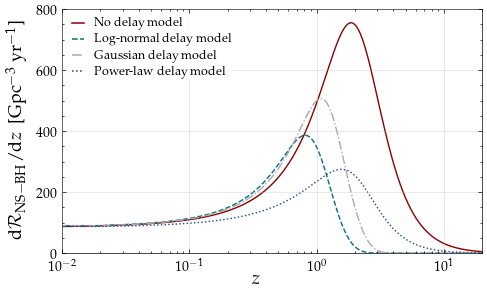

In [25]:
"""
Figure 6.8: 

The 1D and 2D posterior probability distributions for the component masses of the
source binary of GW230529 along with other NSBH and BNS events.

"""

fig, ax = plt.subplots(figsize=FIG_SIZES["rectangle_plot"])

z_array, merger_rate = np.loadtxt(discussion_data_dir + 'merger_rate.txt').T
z_array_log_normal, merger_rate_log_normal = np.loadtxt(discussion_data_dir + 'merger_rate_log_normal.txt').T
z_array_gaussian, merger_rate_gaussian = np.loadtxt(discussion_data_dir + 'merger_rate_gaussian.txt').T
z_array_power_law, merger_rate_power_law = np.loadtxt(discussion_data_dir + 'merger_rate_power_law.txt').T

ax.plot(z_array, merger_rate, '-', color=COLORS_DICT['darkred'])
ax.plot(z_array_log_normal, merger_rate_log_normal, '--', color=COLORS_DICT['teal'])
ax.plot(z_array_gaussian, merger_rate_gaussian, '-.', color=COLORS_DICT['gray'])
ax.plot(z_array_power_law, merger_rate_power_law, ':', color=COLORS_DICT['navy'])


ax.set_xscale("log")

ax.set_xlim(0.01, 20)
ax.set_ylim(0, 800)
ax.set_yticks([0, 200, 400, 600, 800])
ax.tick_params(axis='x', which='major', pad=6)

fig.supxlabel("$z$", x=0.48, y=-0.00, fontsize=13)
fig.supylabel(r"$\text{d}\mathcal{R}_{\rm NS-BH}/\text{d}z\,$ [Gpc$^{-3}$ yr$^{-1}$]", y=0.5, x=0.02, fontsize=13)

# add the legend to the plot
handles = [Line2D([], [], color=COLORS_DICT['darkred'], ls="-"), 
           Line2D([], [], color=COLORS_DICT['teal'], ls="--"),
           Line2D([], [], color=COLORS_DICT['gray'], ls="-."),
           Line2D([], [], color=COLORS_DICT['navy'], ls=":")]

labels = [r"No delay model", r"Log-normal delay model", r"Gaussian delay model", r"Power-law delay model"]
legend = plt.legend(handles, labels, loc=(0.01, 0.710), fontsize=9)
for i in legend.legend_handles:
    i.set_linewidth(1.1)

fig.savefig(discussion_dir + "merger_rate_distribution_comparison.pdf")
fig.savefig(discussion_dir + "merger_rate_distribution_comparison.png")